# BigTable MTLM for LOA (Combined pf and n)
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [22]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, ones, floor, ceil
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten, maximum
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

n_traits = 100


In [23]:
generate_student_name()

'PHUTHY CORE '

In [24]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }


class ProductLayer(Layer):

    def __init__(self, output_dim, kernel_constraint=WeightClip(min_w=-4.0, max_w=4.0), minv=-4,maxv=4, **kwargs):
        
        self.output_dim = output_dim
        super(ProductLayer, self).__init__(**kwargs)
        self.kernel_constraint= constraints.get(kernel_constraint)
        self.min_v = minv
        self.max_v = maxv

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, self.output_dim),
                                      initializer=initializers.RandomUniform(minval=self.min_v,maxval=self.max_v),
#                                       initializer=initializers.Constant(value=2.0),
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        
        super(ProductLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        p = x * self.kernel
        print("shape p", p.shape)
        return p

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
class DifferenceLayer(Layer):

    def __init__(self, output_dim, kernel_constraint=WeightClip(min_w=-4.0, max_w=4.0), minv=-4,maxv=4, invert=False, **kwargs):
        
        self.output_dim = output_dim
        super(DifferenceLayer, self).__init__(**kwargs)
        self.kernel_constraint= constraints.get(kernel_constraint)
        self.min_v = minv
        self.max_v = maxv
        self.invert = invert

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        initialiser = initializers.RandomUniform(minval=self.min_v,maxval=self.max_v)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, self.output_dim),
                                      initializer=initialiser,
#                                       initializer=initializers.Constant(value=2.0),
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        super(DifferenceLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        if self.invert:
            x = tf.Print(x, [x], message="x is:", first_n=-1, summarize=1024)
            k = tf.Print(self.kernel, [self.kernel], message="- kernel is:", first_n=-1, summarize=1024)
            p = x - k
        else:
            k = tf.Print(self.kernel, [self.kernel], message="kernel is:", first_n=-1, summarize=1024)
            x = tf.Print(x, [x], message="- x is:", first_n=-1, summarize=1024)
            p = k - x
#         p = K.print_tensor(p, message="p is:")
        p =  tf.Print(p, [p], message="p is:", first_n=-1, summarize=1024)
        print("shape p", p.shape)
        return p

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [25]:
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )

# q_p_avg = 0.45
run_p_easiest = 0.99
run_p_hardest = 0.01

# max_atts = 10
# q_p_easiest = (1-(1-run_p_easiest)**(1/10))
# q_p_hardest = (1-(1-run_p_hardest)**(1/10))
q_p_easiest = run_p_easiest
q_p_hardest = run_p_hardest

# print("hazards:")
# print(q_p_easiest, q_p_hardest)

pr_k_easiest = q_p_easiest**(1/n_traits)
pr_k_hardest = q_p_hardest**(1/n_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
easy_comp_del = inv_sigmoid(pr_k_easiest)
hard_comp_del = inv_sigmoid(pr_k_hardest)

offset = (easy_comp_del - hard_comp_del)/2
beta_min = 0
# beta_max = round(offset,1)
# theta_min = round(easy_comp_del - offset,1)
# theta_max = round(easy_comp_del,1)
beta_max = offset
theta_min = easy_comp_del - offset
theta_max = easy_comp_del


# beta_min = 0
# beta_max = 10
# theta_min = 5
# theta_max = 15

if theta_min < 0:
    beta_min -= theta_min
    beta_max -= theta_min
    theta_max -= theta_min
    theta_min -= theta_min


print("bs:",beta_min, beta_max)
print("ths:", theta_min, theta_max)

worst_comp_pr = 1/(1+exp(-(theta_min - beta_max)))
best_comp_pr = 1/(1+exp(-(theta_max - beta_min)))

print("worst cmp chance=", worst_comp_pr)
print("best cmp chance=", best_comp_pr)

print("worst Pr=", worst_comp_pr**n_traits)
print("best Pr=", best_comp_pr**n_traits)

# print("worst Run Pr=", 1-(1-(worst_comp_pr**n_traits))**max_atts)
# print("best Run Pr=", 1-(1-(best_comp_pr**n_traits))**max_atts)


nom = array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

sel = nom[[0,2]]
print(sel)
print(sel.shape)


-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
bs: 0 3.075196407410573
ths: 6.130072753253939 9.205269160664512
worst cmp chance= 0.9549925860214361
best cmp chance= 0.9998995016917583
worst Pr= 0.010000000000000165
best Pr= 0.9900000000000009
[[1 2 3]
 [7 8 9]]
(2, 3)


In [26]:
class BigTable(Layer):

    def __init__(self, _dim, min_w=0, max_w=10, **kwargs):
        self.dim = _dim
        self.limits = (min_w, max_w)
        kc =WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
        av_w = (min_w + max_w)/2.0
        initialiser = initializers.RandomUniform(min_w, max_w)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        selector = K.flatten(selector)
        print("flat selector shape", selector.shape)
        print("call kk", self.kernel.shape)
#         selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)

        rows = K.gather(self.kernel, selector)
#         rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [27]:
class Question():
    def __init__(self, qix, min_diff, max_diff, nt=None, nnw=None, optimiser=None):
        #self.MAX_BETA = 15
        mass = random.uniform(min_diff*nt,max_diff*nt)
#         mass = random.choice([(0.8*min_diff+0.2*max_diff)*nt, 0.5*(min_diff+max_diff)*nt, (0.2*min_diff + 0.8*max_diff)*nt])
        base = min_diff*nt
        mass = mass - base
        
        self.id = qix
#         no_dummies = randint(1,(nt-1))
        no_live = nt
#         print("no_dummies=",no_dummies)
#         self.betas = [ round(random.uniform(min_diff, max_diff),1) for _ in range(nt) ]

        not_present= min_diff
        self.betas = [ not_present for _ in range(nt) ]
        choices = list(range(nt))
        shuffle(choices)
        while mass > 0:
            for c in choices:
                curr = self.betas[c]
                if curr >= max_diff:
                    continue
                slyce = min(random.uniform(0,max_diff-curr), mass)
                mass -= slyce
                self.betas[c] += slyce
                if mass <= 0:
                    break            

In [28]:
class Student():
    def __init__(self, psix, min_abil, max_abil, nt=None, nnw=None, optimiser=None):
        #self.MAX_BETA = 15
        mass = random.uniform(min_abil*nt,max_abil*nt)
        base = min_abil*nt
        mass = mass - base
        
        self.id = psix
        self.name = generate_student_name()
#         min_abil = 0
#         max_abil = 10
#         self.thetas = [ round(random.uniform(min_abil, max_abil),1) for _ in range(nt) ]
        not_present= min_abil
        self.thetas = [ not_present for _ in range(nt) ]
        choices = list(range(nt))
        shuffle(choices)
        while mass > 0:
            for c in choices:
                curr = self.thetas[c]
                if curr >= max_abil:
                    continue
                slyce = min(random.uniform(0,max_abil-curr), mass)
                mass -= slyce
                self.thetas[c] += slyce
                if mass <= 0:
                    break                  
    

In [29]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [30]:
def calculate_pass_probability(thetas, betas):
    # additive factors model is:
    # p_pass = 1 / 1 + exp(-z)
    # where z = a + sum[1:n]( -b + gT )
    
    p_pass = 1.0
#     print("th,b",thetas,betas)
    for th,b in zip(thetas,betas):
        z = (th-b)
        p_pass_step = exp(z) / (1.0 + exp(z))
#         print(th,"vs",b,"->",z,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
#     print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [31]:
qopt = Adam()

def create_qs(n_qs, nt=n_traits, nnw=n_traits, optimiser=qopt):
    random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt=nt, nnw=nnw, optimiser=optimiser) for qix in range(n_qs)]
    for q in master_qs:
        nocomps = len(q.betas)
#         mag = sqrt(sum([ pow(b, 2) for b in q.betas if b!=-10 ]))
        mag = sum(q.betas)
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, nocomps))
    
    for q in master_qs:
        print("qid",q.id,q.betas)
    
    qn_table = BigTable((n_qs, nnw),min_w=beta_min, max_w=beta_max)
    
    return master_qs, qn_table

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [32]:
psi_opt = Adam()
def create_students(n_students, nt=n_traits, nnw=n_traits, optimiser=None):
    random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt, nnw=nnw, optimiser=optimiser) for psix in range(n_students)]
    for psi in psi_list:
        print(psi.name, psi.thetas)
        
    psi_table = BigTable((n_students, nnw), min_w=theta_min, max_w=theta_max)
    psi_attn_table = BigTable((n_students, 1), min_w=0, max_w=1)
    print("psi_table wgts", psi_table.get_weights())
    
    return psi_list, psi_table
    

In [33]:
extend_pop=False
extend_by = 90
if extend_pop:
    for _ in range(extend_by):
        nu_psi = Student(nt=n_traits, nq=len(master_qs), optimiser=psi_opt)
        psi_list.append(nu_psi)

In [34]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
    user_patience = 10
    pass_to_remove = True
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            #psi.mastery = [0 for _ in range(nq)]
            qs = [ix for ix in range(len(master_qs))]
#             print("* * * **** USER {}".format(psi.name))
#             print("* * * * ** THETAS {}".format(psi.thetas))

            while(True):
                q_ct = 0
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                while q_ct<user_patience:
                    q_ct+=1
                    pp,passed = attempt_q(psi, q)
                    tup = (psi.id, q.id, passed, (q_ct if passed else 0))
                    attempts.append(tup)
                    attempt_n_map[(q.id,psi.id)] += 1
                    if passed:
                        break
                
                print("p_pass was",pp) #, "run p:", 1-(1-pp)**max_atts)
                
                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)
                                        
                if passed:
                    print("passed in",q_ct)
                    qs.remove(qix)

                spend += q_ct

                if qs == [] or spend>=user_budget:
                    break
    gc.collect()
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map


def generate_qs_model(qn_table, psi_table, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    did_pass = Input(shape=(1,), name="did_pass")
#     did_n = Input(shape=(1,), name="did_n")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)
    dif = subtract([psi_row, qn_row])
    print("dif",dif.shape)
    Prs = Lambda(lambda z: K.exp(z) / (1.0 + K.exp(z)), name="sPr_sigmoid")(dif)
    
    print("Prs",Prs.shape)
    #calculate the hazard rate here
    hz = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
#     print("hz",hz.shape)
    
#     max_att = 10
    #calculate the prob of passing in <= max_att
    #prob of passing at point t:
    #Pr(X=t) = (1-p)^(t-1) * p # i.e. fail^(t-1), then pass 
    
#     Pr = (1-p)^(t-1) * p
    
    
#     hidden = Dense(5, activation="relu")(Prs)
#     hidden = Dense(5, activation="relu")(hidden)
#     hidden = Dense(5, activation="relu")(hidden)
#     n = Dense(1, activation="relu")(hidden)
    n = Lambda(lambda p: (1/p), name="n_calc")(hz)
#     print("n",n.shape)
    n = multiply([n, did_pass], name="n_cancellor")

#     print("did_pass", did_pass.shape)
    print("n'",n.shape)

#     hz = Lambda(lambda hz: tf.Print(hz, [hz], message="hz is:", first_n=-1, summarize=1024))(hz)
#     pazz = Lambda( lambda p : (1.0-K.pow((1-p),max_att)), name="pazz_calc" ) (hz)
#     pazz = Lambda(lambda t: tf.Print(t, [t], message="pazz is:", first_n=-1, summarize=1024))(pazz)

#     hidden2 = Dense(5, activation="relu")(Prs)
#     hidden2 = Dense(5, activation="relu")(hidden2)
#     hidden2 = Dense(5, activation="relu")(hidden2)
#     pazz = Dense(1, activation="sigmoid")(hidden2)
#     print("pazz",pazz.shape)
    
    model = Model(inputs=[qn_sel, psi_sel, did_pass], outputs=[hz,n])
#     model = Model(inputs=[qn_sel, psi_sel], outputs=[n,])
    model.compile(optimizer=optimiser, loss=["binary_crossentropy","mse"], loss_weights=[1.0,1.0])
    return model

In [35]:
def init_weights(master_qs, psi_list, attempts_by_psi, attempts_by_q, q_table, s_table, min_b, max_b, min_th, max_th):
    numpy.random.seed(666)
    psi_wgts = s_table.get_weights()[0]
    for s in psi_list:
#         attz = [tup[2] for tup in attempts_by_psi[s.name]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log(p / (1-p))
        av_th = (min_th + max_th)/2.0
#         psi_wgts[s.id,:] = numpy.random.uniform(max_th-1, max_th, size=psi_wgts.shape[1])
        psi_wgts[s.id,:] = numpy.random.uniform(min_th, max_th, size=psi_wgts.shape[1])

        print(psi_wgts[s.id,:])
    s_table.set_weights([ psi_wgts ])

    qn_wgts = q_table.get_weights()[0]
    for q in master_qs:
#         attz = [tup[2] for tup in attempts_by_q[q]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log((1-p) / p)
        av_b = (min_b + max_b)/2.0
#         qn_wgts[q.id,:]= numpy.random.uniform(min_b, min_b+1, size=qn_wgts.shape[1])
        qn_wgts[q.id,:]= numpy.random.uniform(min_b, max_b, size=qn_wgts.shape[1])

        print(qn_wgts[q.id,:])
    q_table.set_weights([ qn_wgts ])
    

In [36]:
def calc_arr_arr_err(real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None

    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_cos_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    #print("mae is ",mse)
                    if err < curr_err:
    #                     print("best match", cix, rix)
    #                     print(real_col)
    #                     print(pred_col)
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
    #         print("---")
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        cos_dis = cosine(out_col_arr.flatten(), real_wgts.flatten())
        mean_ll = numpy.mean( out_col_arr - real_wgts )
#         if total_err < min_total_err:
        if cos_dis < best_cos_dis:
            min_total_err = total_err
            best_ll = mean_ll
            chosen = out_col_arr
            best_cos_dis = cos_dis
#             print("new total min mae:", min_total_err)
#             print("new best ll", best_ll)
    return chosen, min_total_err, mean_ll, best_cos_dis

In [ ]:
import os
import IPython

def calibrate(master_qs, psi_list, qs_model, q_model, s_model, attempts, attempts_by_psi, attempts_by_q, attempt_n_map, s_table, q_table, n_iter=20, record_param_fit=False):
    es = EarlyStopping(monitor="val_loss", mode="auto", patience=0)
    random.seed(666)
    min_mse = 1000
    min_avg_fit_rmse = math.inf
    min_loss= math.inf
    q_outer_mses = []
    q_outer_accs = []
    s_outer_mses = []
    s_outer_accs = []
    th_mses = []
    b_mses = []
    th_accs= []
    b_accs =[]
    h= []
    avg_fit_rmses = []
    th_fit_rmses = []
    b_fit_rmses = []
    init_patience = 20
    patience = init_patience

    print(attempts[0:100])

    qices = array([int(tup[1]) for tup in attempts]).flatten() #reshape(-1,1)
    psices = array([int(tup[0]) for tup in attempts]).flatten() #reshape(-1,1)
    pfs = array([tup[2] for tup in attempts]).flatten() #reshape(-1,1)
    #ns = array([tup[3] for tup in attempts]).flatten() #reshape(-1,1)
    ns =array( [(attempt_n_map[(q,p)] if pf>0 else 0)  for (q,p,pf) in zip(qices, psices, pfs) ])
    len_all = qices.shape[0]
        
    qz = qices
    sz = psices
    pfz = pfs
    nz = ns

#     for pf in pfs:
#         print(pf)
    
    print(qz)
    print(sz)
    print(pfz)
    print(nz)
#     input("Xsan")
    
    loss = False
    mse = False
    acc = False
    early_stop = True
    min_stop = 0
#     n_iter = 1
    for i in range(n_iter):
#         shuffle(attempts)
#         attemptz = attempts[0:100]
#         qices = array([int(tup[1]) for tup in attemptz]).flatten() #reshape(-1,1)
#         psices = array([int(tup[0]) for tup in attemptz]).flatten() #reshape(-1,1)
#         pfs = array([tup[2] for tup in attemptz]).flatten() #reshape(-1,1)
#         len_all = qices.shape[0]      

#         qz = qices
#         sz = psices
#         pfz = pfs
        
#         psi = random.choice(psi_list)
#         q = random.choice(qs)
#         print(psi.id, psi.name, q.id)
#     while True:
#         numpy.random.shuffle(attempts)
        base_ix = 0
        done = False
#         for j in range(chunkz+1):
        j = 0
        sub_h = []
        
        qs_model.train_on_batch(x=[qz, sz, pfz], y=[pfz,nz])#, epochs=10, shuffle=True, batch_size=1, callbacks=[es])

        if i % 10 == 0:
            topn=20
            pred_pfz, pred_nz = qs_model.predict(x=[qices[0:topn], psices[0:topn], pfs[0:topn]], verbose=0) 
            for j in range(topn):
                print(qices[j], psices[j], pfs[j], ns[j], ":", pred_pfz[j], pred_nz[j])

            tup = qs_model.evaluate(x=[qices, psices, pfs], y=[pfs,ns], verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
#             loss2, mse2, acc2 = s_model.evaluate(x=[qices, psices], y=pfs, verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
#             loss=(loss+loss2)/2
#             mse=(mse+mse2)/2
#             acc=(acc+acc2)/2
            comb_loss, cat_loss, mse = tup
            tup = comb_loss, cat_loss, mse, acc
            sub_h.append(tup)

            psi_wgts = s_table.get_weights()[0]
            th_rmses = []
            for s in psi_list:
                s_thetas = numpy.sort(s.thetas)
                s_wgts = numpy.sort(psi_wgts[s.id])
                err = numpy.mean( numpy.abs(s_thetas - s_wgts) )
#                 err = cosine(s_thetas, s_wgts)
                th_rmses.append(err)

            qn_wgts = q_table.get_weights()[0]
            b_rmses = []
            for q in master_qs:
                q_betas = numpy.sort(q.betas)
                q_wgts = numpy.sort(qn_wgts[q.id])
                err = numpy.mean( numpy.abs(q_betas - q_wgts) )
#                 err = cosine(q_betas, q_wgts)
                b_rmses.append(err)
            
            print("i =",i)
            th_rmse = numpy.mean(th_rmses)
            th_fit_rmses.append(th_rmse)
            print("th RMSE=", th_rmse)
            b_rmse = numpy.mean(b_rmses)
            b_fit_rmses.append(b_rmse)
            print("b RMSE=", b_rmse)
#             print(loss,pf_loss,mse,acc, n_acc)
            print(mse,acc)
            sub_h = numpy.array(sub_h)
            sub_tup = (sub_h[-1,0],sub_h[-1,1],sub_h[-1,2],sub_h[-1,3])
            h.append(sub_tup)
#             av_rmse = (th_rmse/len(psi_list) +b_rmse/len(master_qs))
#             av_rmse =(th_rmse+b_rmse)/2.0
            av_rmse = b_rmse
            print("av RMSE=",av_rmse)
            if av_rmse < min_avg_fit_rmse:
                patience = init_patience
                print("patience reset to", init_patience)
                min_avg_fit_rmse = av_rmse
                min_loss = loss
                qs_model.save_weights("qs_best_weights_LOA_combined.hdf5")
                print("...model saved")
            else:
                if early_stop and i>min_stop:
#                 if loss < min_loss:
#                     print(loss,"<",min_loss)
                    if patience >0:
                        patience -= 1
                        print("patience now", patience)
                    else:
                        print("Earlying stoppin' @",i)
                        break

    #     del h
    #     loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs)

    #     print(loss, mse, acc)
    return h, th_fit_rmses, b_fit_rmses


In [19]:
nn_dimensions = [n_traits]
serieses = []
min_errs = []
n_qs = 30
n_students = 100
opt = Adam() #try 0.5 for 2 dim

for ix,nnw in enumerate(nn_dimensions):
    qs, q_table = create_qs(n_qs, n_traits, nnw, optimiser=opt)
    ss, s_table = create_students(n_students, n_traits, nnw, optimiser=opt)
    attempts, attempts_by_q, attempts_by_psi, attempt_n_map = generate_attempts(qs,ss)
    
    pf = [tup[2] for tup in attempts]
    N = len(pf)
    pN = sum(pf)
    pr = pN/N
    
#     print(attempts)
#     q_model = generate_model(q_table, s_table, opt, mode="q_train")
#     s_model = generate_model(q_table, s_table, opt, mode="s_train")
    q_model = None
    s_model = None
    qs_model = generate_qs_model(q_table, s_table, opt)
#     qs_model = None
#     psi_model = generate_psi_model(s_table, qopt)
    init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, beta_min, beta_max, theta_min, theta_max)
#     input("chunt")    psi_wgts = s_table.get_weights()[0]
#     qn_wgts = q_table.get_weights()[0]

#     print("pass rate is {} of {} = {}".format(pN,N,pr))
#     for _ in range(10):
#         print("*")
#     input("yam")


    h, th_fit_rmses, b_fit_rmses = calibrate(qs,ss, qs_model, q_model, s_model, attempts, attempts_by_psi, attempts_by_q, attempt_n_map, s_table, q_table, n_iter=1000000, record_param_fit=True)
    qs_model.load_weights("qs_best_weights_LOA_combined.hdf5")

    

Q:0, difficulty=140.27 across 100 components
Q:1, difficulty=55.19 across 100 components
Q:2, difficulty=274.33 across 100 components
Q:3, difficulty=139.72 across 100 components
Q:4, difficulty=1.22 across 100 components
Q:5, difficulty=268.60 across 100 components
Q:6, difficulty=203.38 across 100 components
Q:7, difficulty=189.53 across 100 components
Q:8, difficulty=288.47 across 100 components
Q:9, difficulty=240.33 across 100 components
Q:10, difficulty=47.19 across 100 components
Q:11, difficulty=111.30 across 100 components
Q:12, difficulty=304.21 across 100 components
Q:13, difficulty=272.63 across 100 components
Q:14, difficulty=195.55 across 100 components
Q:15, difficulty=193.69 across 100 components
Q:16, difficulty=22.15 across 100 components
Q:17, difficulty=66.40 across 100 components
Q:18, difficulty=71.47 across 100 components
Q:19, difficulty=233.20 across 100 components
Q:20, difficulty=253.38 across 100 components
Q:21, difficulty=71.10 across 100 components
Q:22, 

LATHI FYV  [7.057606459550355, 8.427876374250411, 6.219533688386442, 8.780895660868534, 6.905240678074554, 7.5950324459054075, 7.9631441718109395, 7.5068795886871795, 7.141381838870513, 8.579776544907855, 9.152822899997627, 8.49120844620268, 8.657863214182878, 7.439916937298696, 7.463008609587293, 7.9804021130464955, 7.434304510211286, 8.16725395642177, 8.437472016690121, 7.7719292422490005, 6.333393557089503, 6.988158129012827, 6.41369925620276, 7.655347067410632, 8.809617144535803, 6.930850346311923, 8.402257221442271, 6.630205672772432, 6.675513400986841, 6.522196304453519, 7.407569618710614, 6.3041395129387645, 8.466970266612474, 7.3850454517364525, 9.152642146970488, 7.464036549614775, 7.21795536104514, 9.14629487064878, 6.6008277604117165, 8.47287602823966, 8.984135995560564, 8.03191572581413, 7.151890904752138, 8.568685332907666, 8.271841858844825, 6.465377306508714, 6.1649423927307065, 6.840151661094133, 7.978102864527113, 7.642312642461305, 6.895772715428505, 7.445091672648845

NYPAF POMUW  [6.130072753253939, 7.608482139048224, 6.907199735362819, 6.468419372671232, 6.130072753253939, 6.130072753253939, 7.280456965845041, 6.130072753253939, 6.486714400728406, 6.130072753253939, 7.675960819909147, 6.130072753253939, 6.130072753253939, 6.130072753253939, 6.130072753253939, 6.130072753253939, 6.130072753253939, 6.7520508215161055, 7.586432076198154, 7.206340605395517, 9.191747544295884, 8.633609801035316, 6.130072753253939, 6.130072753253939, 6.130072753253939, 6.513796977932528, 6.130072753253939, 7.394410142591652, 6.130072753253939, 8.808797467906881, 6.130072753253939, 6.130072753253939, 6.130072753253939, 7.634423598659904, 6.130072753253939, 8.204998906093971, 6.130072753253939, 8.787455416576773, 6.130072753253939, 7.104841401630089, 7.848196414468221, 8.138720354323198, 6.130072753253939, 6.130072753253939, 6.681420510422224, 8.24476268823916, 6.130072753253939, 6.130072753253939, 6.130072753253939, 6.130072753253939, 6.130072753253939, 6.130072753253939

KUVAJ RYGO  [7.107569850379035, 9.140515747469589, 8.97723615904056, 7.537041772967661, 8.464612766062023, 9.096236825589243, 9.027792811818957, 8.626124978508825, 8.79101097175105, 8.091212227431217, 9.185694355224626, 8.935559995999856, 9.04949267880521, 9.112739998867191, 7.1953156003804475, 7.773523077054066, 9.130950726451829, 8.637268668393776, 8.548620260617568, 8.837816796618014, 9.16065601583829, 8.896614125119246, 9.036307909136358, 8.778850276930532, 8.784317219473703, 8.036104778203281, 9.198921919769361, 7.173823251746312, 8.59451771461261, 8.786923555254852, 9.017115993023019, 8.885373564919952, 8.554934562813218, 8.507478438823902, 8.698786656558841, 8.716112159763389, 9.149840019173782, 8.704078118145148, 8.70166271421978, 8.842827336667577, 9.027101781551252, 8.948156267670491, 8.43644824218137, 7.97901020498261, 8.399837234170315, 8.434116927830777, 8.956520921386636, 8.362671540491487, 8.454146024639975, 9.173496772615252, 8.950111649250175, 7.347528402803228, 7.8779

passed in 1
p_pass was 0.8722265838841704
passed in 1
p_pass was 0.8105714717731649
passed in 1
p_pass was 0.8640328406402866
passed in 1
p_pass was 0.4879455148443219
passed in 1
p_pass was 0.8180287546425382
passed in 1
p_pass was 0.727152419137513
passed in 1
p_pass was 0.5137733574235227
passed in 2
p_pass was 0.48524257484822625
passed in 2
p_pass was 0.8029588082635974
passed in 1
p_pass was 0.9330480942399708
passed in 1
p_pass was 0.951595993140471
passed in 1
p_pass was 0.7921618843290688
passed in 1
p_pass was 0.7795610428249276
passed in 1
p_pass was 0.9377146685766405
passed in 1
p_pass was 0.944989838924804
passed in 1
p_pass was 0.8533217644848684
passed in 1
p_pass was 0.9489458777445348
passed in 1
p_pass was 0.9681624641969373
passed in 1
p_pass was 0.8967722819381977
passed in 1
p_pass was 0.7927909190614875
passed in 1
p_pass was 0.7742040039502991
passed in 1
p_pass was 0.8250106879735233
passed in 1
p_pass was 0.9504237883606892
passed in 1
p_pass was 0.90895806954

passed in 9
p_pass was 0.4541565555546033
passed in 2
p_pass was 0.3861412591286563
passed in 2
p_pass was 0.5039026447899067
passed in 4
p_pass was 0.020112345759869872
p_pass was 0.6739330112548887
passed in 1
p_pass was 0.020112345759869872
p_pass was 0.03231414904704075
passed in 5
p_pass was 0.020112345759869872
p_pass was 0.020112345759869872
p_pass was 0.048323531218036835
p_pass was 0.5484067245946097
passed in 1
p_pass was 0.8222342799911754
passed in 1
p_pass was 0.09761387326166733
p_pass was 0.7683340836682667
passed in 1
p_pass was 0.06458285811548556
p_pass was 0.048323531218036835
p_pass was 0.020112345759869872
p_pass was 0.04568439428163743
p_pass was 0.020112345759869872
passed in 7
p_pass was 0.0701837932998533
p_pass was 0.0701837932998533
p_pass was 0.0701837932998533
p_pass was 0.3351106424822649
passed in 3
p_pass was 0.04568439428163743
passed in 6
p_pass was 0.09761387326166733
passed in 4
p_pass was 0.0701837932998533
passed in 4
p_pass was 0.16954687373832975

p_pass was 0.2173020853071031
passed in 1
p_pass was 0.4760001297124458
passed in 4
p_pass was 0.17049189438546838
passed in 9
p_pass was 0.07345388600000789
passed in 5
p_pass was 0.5689792268270323
passed in 3
p_pass was 0.671382363633679
passed in 2
p_pass was 0.0987508439676557
passed in 1
p_pass was 0.31375069608176753
passed in 3
p_pass was 0.6160839229172504
passed in 4
p_pass was 0.07123505690119677
p_pass was 0.6227630891718162
passed in 1
p_pass was 0.27764225049997315
passed in 3
p_pass was 0.12366843581793152
p_pass was 0.8242649111835515
passed in 1
p_pass was 0.7892360230829097
passed in 1
p_pass was 0.07123505690119677
p_pass was 0.07123505690119677
passed in 4
p_pass was 0.12366843581793152
passed in 8
p_pass was 0.06534065018048203
p_pass was 0.7287024926503466
passed in 1
p_pass was 0.17813112424568406
passed in 3
p_pass was 0.3792713733454277
passed in 2
p_pass was 0.48679180288687907
passed in 1
p_pass was 0.13103988406318218
passed in 7
p_pass was 0.635358043461571

passed in 1
p_pass was 0.8653485529546426
passed in 2
p_pass was 0.5213745553583972
passed in 3
p_pass was 0.8480520299191315
passed in 2
p_pass was 0.817026568948796
passed in 1
p_pass was 0.496832900493796
passed in 1
p_pass was 0.639641748199344
passed in 1
p_pass was 0.5589824644921358
passed in 2
p_pass was 0.7732588245314307
passed in 1
p_pass was 0.4126859905539652
passed in 3
p_pass was 0.8244475751276246
passed in 1
p_pass was 0.9518459245570163
passed in 2
p_pass was 0.525522470717863
passed in 1
p_pass was 0.827439757740503
passed in 2
p_pass was 0.4516562280325148
passed in 4
p_pass was 0.6561092735777402
passed in 2
p_pass was 0.8350220625132513
passed in 1
p_pass was 0.5991279220669621
passed in 2
p_pass was 0.448817687135649
passed in 1
p_pass was 0.603724772218936
passed in 3
p_pass was 0.9246888034592722
passed in 1
p_pass was 0.7586902239415271
passed in 1
p_pass was 0.8445927291802731
passed in 1
p_pass was 0.6568124958080822
passed in 1
p_pass was 0.8774332131622304

p_pass was 0.8343631001857514
passed in 1
p_pass was 0.9313747375570803
passed in 1
p_pass was 0.944482386359067
passed in 1
p_pass was 0.8385308605123365
passed in 1
p_pass was 0.8761761168654566
passed in 1
p_pass was 0.8727189170046866
passed in 1
p_pass was 0.9618687568734061
passed in 1
p_pass was 0.9622278129139797
passed in 1
p_pass was 0.9890195145911032
passed in 1
p_pass was 0.9004388578711882
passed in 1
p_pass was 0.957450783262792
passed in 1
p_pass was 0.9840773282385015
passed in 1
p_pass was 0.7991420598378945
passed in 2
p_pass was 0.9043451035897982
passed in 1
p_pass was 0.8189787511614122
passed in 1
p_pass was 0.8937862254383468
passed in 1
p_pass was 0.581648805041929
passed in 1
p_pass was 0.6856962335121957
passed in 1
p_pass was 0.9104542749614772
passed in 1
p_pass was 0.7437333337875496
passed in 1
p_pass was 0.9603203117471705
passed in 1
p_pass was 0.53518457080034
passed in 3
p_pass was 0.6506229300783108
passed in 1
p_pass was 0.6435418689977515
passed in

p_pass was 0.785990493048878
passed in 2
p_pass was 0.9701628671422048
passed in 1
p_pass was 0.9611216545589513
passed in 1
p_pass was 0.9832775113423284
passed in 1
p_pass was 0.896038111641739
passed in 1
p_pass was 0.8981255678594257
passed in 1
p_pass was 0.9263045221304038
passed in 1
p_pass was 0.9605341793577543
passed in 1
p_pass was 0.9447666436188371
passed in 1
p_pass was 0.8272561734176247
passed in 1
p_pass was 0.8862854075059412
passed in 1
p_pass was 0.7839113255762064
passed in 1
p_pass was 0.5115890919419949
passed in 9
p_pass was 0.5020206679046826
passed in 3
p_pass was 0.021649606965818444
p_pass was 0.15061360382584466
passed in 6
p_pass was 0.09551933100403058
p_pass was 0.5252205550169617
passed in 5
p_pass was 0.6867284787398431
passed in 1
p_pass was 0.6193158476508877
passed in 2
p_pass was 0.10561273432867456
p_pass was 0.4677642539918532
passed in 3
p_pass was 0.5258686983603876
passed in 2
p_pass was 0.0757336719264555
p_pass was 0.09551933100403058
p_pass

p_pass was 0.6610346271038079
passed in 2
p_pass was 0.2831521979184401
passed in 7
p_pass was 0.6084791930096625
passed in 2
p_pass was 0.614400258586286
passed in 2
p_pass was 0.47135047796256585
passed in 2
p_pass was 0.2839877774073732
passed in 3
p_pass was 0.8076335593758481
passed in 1
p_pass was 0.8666134389025693
passed in 1
p_pass was 0.8917668408754146
passed in 1
p_pass was 0.8833152735574045
passed in 1
p_pass was 0.9428132325545014
passed in 1
p_pass was 0.9336387686942307
passed in 1
p_pass was 0.7845181257156727
passed in 1
p_pass was 0.9882370451198114
passed in 1
p_pass was 0.8461874894939696
passed in 1
p_pass was 0.8674775955656184
passed in 1
p_pass was 0.8500289376548139
passed in 1
p_pass was 0.9833799123377572
passed in 1
p_pass was 0.8881919398690747
passed in 1
p_pass was 0.7859971765746936
passed in 1
p_pass was 0.9619300559470436
passed in 1
p_pass was 0.9314127060951702
passed in 1
p_pass was 0.954101898545586
passed in 1
p_pass was 0.9285100603038395
passe

p_pass was 0.632187530428887
passed in 1
p_pass was 0.6594504518018113
passed in 2
p_pass was 0.4765577353774893
passed in 1
p_pass was 0.9114371633345443
passed in 1
p_pass was 0.9040139314856335
passed in 1
p_pass was 0.6883421946857136
passed in 1
p_pass was 0.5817707878700733
passed in 1
p_pass was 0.8059437760992266
passed in 1
p_pass was 0.8779263005639474
passed in 1
p_pass was 0.8861572378398513
passed in 1
p_pass was 0.6006054206199145
passed in 1
p_pass was 0.5677134403887294
passed in 1
p_pass was 0.9369915180776837
passed in 1
p_pass was 0.8047024998313002
passed in 1
p_pass was 0.9458477621914206
passed in 1
p_pass was 0.7248468130923411
passed in 1
p_pass was 0.5570583426335209
passed in 1
p_pass was 0.7002602893756212
passed in 2
p_pass was 0.8857201505118939
passed in 1
p_pass was 0.582018666161844
passed in 1
p_pass was 0.7825276525906081
passed in 1
p_pass was 0.7290434473466773
passed in 1
p_pass was 0.8153184502041516
passed in 1
p_pass was 0.9645018419075342
passed

p_pass was 0.8353080414331988
passed in 1
p_pass was 0.9528156693554433
passed in 1
p_pass was 0.8154869725033638
passed in 1
p_pass was 0.9341173520564173
passed in 1
p_pass was 0.7970898807595638
passed in 1
p_pass was 0.9044278787966987
passed in 1
p_pass was 0.7609114048945099
passed in 1
p_pass was 0.8623201435299863
passed in 4
p_pass was 0.8426026727299976
passed in 1
p_pass was 0.9409440301247246
passed in 1
p_pass was 0.8046237286973421
passed in 1
p_pass was 0.9304935172556311
passed in 1
p_pass was 0.947553900176857
passed in 1
p_pass was 0.8585762200495606
passed in 1
p_pass was 0.7929532869327226
passed in 1
p_pass was 0.9276509787825029
passed in 1
p_pass was 0.7061978222945676
passed in 1
p_pass was 0.7627027232191405
passed in 1
p_pass was 0.9043616172406753
passed in 1
p_pass was 0.9502498324543721
passed in 1
p_pass was 0.7560130564798578
passed in 4
p_pass was 0.9810477746775094
passed in 1
p_pass was 0.805567027864577
passed in 1
p_pass was 0.8992989555913166
passed

passed in 3
p_pass was 0.31102702896343154
passed in 5
p_pass was 0.016358121704992644
p_pass was 0.48326022333439234
passed in 1
p_pass was 0.4893194026737852
passed in 1
p_pass was 0.08511430474831194
passed in 1
p_pass was 0.5898982488446941
passed in 2
p_pass was 0.054591382910421746
p_pass was 0.054591382910421746
passed in 1
p_pass was 0.8125170866590027
passed in 1
p_pass was 0.08448366582695173
p_pass was 0.2969224313841379
passed in 1
p_pass was 0.03875061898167849
p_pass was 0.025700409910992258
p_pass was 0.6640752814985338
passed in 1
p_pass was 0.4301228311771786
passed in 1
p_pass was 0.5068623552804276
passed in 3
p_pass was 0.7348597077636931
passed in 1
p_pass was 0.3604118426029854
passed in 2
p_pass was 0.015586875269253784
p_pass was 0.13254928374906771
passed in 3
p_pass was 0.15959153543807528
p_pass was 0.14584664873280898
passed in 6
p_pass was 0.015586875269253784
p_pass was 0.025700409910992258
p_pass was 0.08448366582695173
passed in 2
p_pass was 0.1595915354

p_pass was 0.014935932712484
p_pass was 0.014935932712484
p_pass was 0.014935932712484
p_pass was 0.014935932712484
p_pass was 0.014935932712484
p_pass was 0.014935932712484
p_pass was 0.015579966990020072
p_pass was 0.015579966990020072
p_pass was 0.014935932712484
p_pass was 0.014935932712484
p_pass was 0.015579966990020072
p_pass was 0.014935932712484
p_pass was 0.014935932712484
p_pass was 0.015579966990020072
passed in 2
p_pass was 0.014935932712484
p_pass was 0.014935932712484
p_pass was 0.014935932712484
passed in 8
p_pass was 0.32118905883565896
passed in 1
p_pass was 0.8014834059794678
passed in 1
p_pass was 0.9241784787072863
passed in 1
p_pass was 0.5879820573968162
passed in 3
p_pass was 0.7839576975530946
passed in 1
p_pass was 0.75496545877674
passed in 1
p_pass was 0.36504418891573076
passed in 2
p_pass was 0.5771962828635016
passed in 2
p_pass was 0.6983278024860081
passed in 1
p_pass was 0.4670377204250121
passed in 1
p_pass was 0.40128678269903745
passed in 1
p_pass w

passed in 2
p_pass was 0.2172695339877536
passed in 5
p_pass was 0.7758879391592177
passed in 1
p_pass was 0.6322358221535218
passed in 5
p_pass was 0.33984464790220603
passed in 9
p_pass was 0.5958943471089773
passed in 1
p_pass was 0.13749560096830135
passed in 2
p_pass was 0.12082937103111281
passed in 4
p_pass was 0.09913232835523601
p_pass was 0.4708178751786903
passed in 3
p_pass was 0.09913232835523601
passed in 2
p_pass was 0.07649184898886228
p_pass was 0.07649184898886228
passed in 6
p_pass was 0.4180040393934353
passed in 1
p_pass was 0.6227121403293365
passed in 2
p_pass was 0.9476279461509455
passed in 1
p_pass was 0.9274086369288594
passed in 1
p_pass was 0.43331136846855517
passed in 1
p_pass was 0.33740659315184973
passed in 1
p_pass was 0.4476856235352138
passed in 1
p_pass was 0.5236329754475935
passed in 3
p_pass was 0.4899598718648199
passed in 1
p_pass was 0.6898279037416541
passed in 1
p_pass was 0.6272312000163601
passed in 2
p_pass was 0.7044809909757711
passed 

p_pass was 0.9625416868514958
passed in 1
p_pass was 0.7932298174402764
passed in 1
p_pass was 0.30498301081167994
passed in 1
p_pass was 0.7487241416153346
passed in 1
p_pass was 0.8234890552857934
passed in 1
p_pass was 0.2488505319787802
passed in 2
p_pass was 0.203315555974604
passed in 4
p_pass was 0.7321640140096137
passed in 1
p_pass was 0.4458382692778348
passed in 1
p_pass was 0.401356433608698
passed in 2
p_pass was 0.277506970422669
passed in 9
p_pass was 0.639052168398559
passed in 2
p_pass was 0.36914472367733225
passed in 2
p_pass was 0.2788887916119936
passed in 7
p_pass was 0.46886574707229456
passed in 1
p_pass was 0.4848896892788475
passed in 1
p_pass was 0.8601649543274633
passed in 2
p_pass was 0.8534706176572231
passed in 2
p_pass was 0.20680785654101455
passed in 5
p_pass was 0.47933319139080316
passed in 2
p_pass was 0.678303924898963
passed in 1
p_pass was 0.28026264131009604
passed in 3
p_pass was 0.7803588459066148
passed in 1
p_pass was 0.4207682082946456
pas

passed in 1
p_pass was 0.10366564837534915
passed in 10
p_pass was 0.3370205811007563
passed in 2
p_pass was 0.8236654769810898
passed in 1
p_pass was 0.02144254432334079
p_pass was 0.045566366848444166
p_pass was 0.07384640245975528
p_pass was 0.020732920567116196
p_pass was 0.39740196800997396
passed in 4
p_pass was 0.45786835888793304
passed in 1
p_pass was 0.03275664982525904
p_pass was 0.045566366848444166
p_pass was 0.02144254432334079
p_pass was 0.020732920567116196
p_pass was 0.07384640245975528
passed in 9
p_pass was 0.045566366848444166
p_pass was 0.17673709544251673
passed in 4
p_pass was 0.03275664982525904
p_pass was 0.02144254432334079
p_pass was 0.020732920567116196
p_pass was 0.045566366848444166
p_pass was 0.020732920567116196
p_pass was 0.02144254432334079
passed in 2
p_pass was 0.6731869304262361
passed in 1
p_pass was 0.045566366848444166
p_pass was 0.03275664982525904
p_pass was 0.020732920567116196
p_pass was 0.045566366848444166
p_pass was 0.03275664982525904
p_p

p_pass was 0.8045755979305961
passed in 1
p_pass was 0.6821089953024161
passed in 1
p_pass was 0.7786319364787384
passed in 1
p_pass was 0.49860139096666317
passed in 1
p_pass was 0.7531569974394218
passed in 1
p_pass was 0.7834753020032762
passed in 2
p_pass was 0.786184285227558
passed in 1
p_pass was 0.3353624763499331
passed in 2
p_pass was 0.5380180422486874
passed in 1
p_pass was 0.8346217869518663
passed in 1
p_pass was 0.6149540026758434
passed in 2
p_pass was 0.5524846248884263
passed in 1
p_pass was 0.35509955244251684
passed in 1
p_pass was 0.9311943004466997
passed in 2
p_pass was 0.23920038843352712
passed in 4
p_pass was 0.7049985228562384
passed in 1
p_pass was 0.3641035972528871
passed in 1
p_pass was 0.8530549044105744
passed in 1
p_pass was 0.44634845793431777
passed in 2
p_pass was 0.08831418263189557
passed in 1
p_pass was 0.8157442229109885
passed in 1
p_pass was 0.5027596874752316
passed in 4
p_pass was 0.042504287244919586
p_pass was 0.1552775342557733
p_pass was

passed in 5
p_pass was 0.08569383389707029
passed in 5
p_pass was 0.04651310872157226
passed in 9
p_pass was 0.16253421204070462
passed in 1
p_pass was 0.20770460179671443
passed in 1
p_pass was 0.6183210495727327
passed in 1
p_pass was 0.6323452049698756
passed in 1
p_pass was 0.20650220894942672
passed in 9
p_pass was 0.12494244005026639
passed in 6
p_pass was 0.0980262668162611
passed in 1
p_pass was 0.15035154355367497
passed in 3
p_pass was 0.3986739238505569
passed in 1
p_pass was 0.5852818214698134
passed in 1
p_pass was 0.41758214337050503
passed in 3
p_pass was 0.06594857812833557
passed in 5
p_pass was 0.45426419629992854
passed in 2
p_pass was 0.683479353183277
passed in 1
p_pass was 0.9466379024551719
passed in 1
p_pass was 0.8694864192673408
passed in 1
p_pass was 0.7715162059858722
passed in 1
p_pass was 0.8993512612884063
passed in 1
p_pass was 0.6364394320034763
passed in 5
p_pass was 0.4058142392279937
passed in 1
p_pass was 0.9216826053997554
passed in 1
p_pass was 0.

p_pass was 0.0630394230924527
p_pass was 0.09205442086250287
p_pass was 0.07104655054313995
p_pass was 0.09205442086250287
passed in 1
p_pass was 0.7835262630590702
passed in 1
p_pass was 0.07104655054313995
p_pass was 0.07104655054313995
p_pass was 0.07104655054313995
passed in 2
p_pass was 0.0630394230924527
passed in 8
p_pass was 0.2129394726887608
passed in 1
p_pass was 0.712805574494521
passed in 1
p_pass was 0.19647831724167258
passed in 1
p_pass was 0.21761247904264644
passed in 2
p_pass was 0.6544144694022671
passed in 2
p_pass was 0.6603357349803917
passed in 1
p_pass was 0.2881268803301077
passed in 2
p_pass was 0.4148537030009463
passed in 1
p_pass was 0.11790679504380372
passed in 5
p_pass was 0.8791792629260289
passed in 1
p_pass was 0.7688503888497424
passed in 1
p_pass was 0.15921287577865492
passed in 2
p_pass was 0.8053151426409474
passed in 1
p_pass was 0.1328740110642598
p_pass was 0.4475068543829076
passed in 2
p_pass was 0.1328740110642598
passed in 3
p_pass was 0.

passed in 1
p_pass was 0.15191385557869128
passed in 3
p_pass was 0.659741960681949
passed in 2
p_pass was 0.6462868944659756
passed in 1
p_pass was 0.23997540944659637
passed in 1
p_pass was 0.24297335928988428
passed in 1
p_pass was 0.6897069923524147
passed in 1
p_pass was 0.3083597410061514
passed in 4
p_pass was 0.8431924452507626
passed in 1
p_pass was 0.12253064869010488
p_pass was 0.0886264936749872
p_pass was 0.44554009644561177
passed in 1
p_pass was 0.7904271114696991
passed in 1
p_pass was 0.6526234748285518
passed in 1
p_pass was 0.5911325941563325
passed in 1
p_pass was 0.08797865286612727
p_pass was 0.7358199633985599
passed in 1
p_pass was 0.14754964564930084
passed in 4
p_pass was 0.24530564598230584
passed in 4
p_pass was 0.1838685511417528
passed in 1
p_pass was 0.4949829947775
passed in 3
p_pass was 0.7104524135985527
passed in 2
p_pass was 0.8868502180178967
passed in 1
p_pass was 0.12253064869010488
passed in 6
p_pass was 0.357732682891694
passed in 3
p_pass was 0

p_pass was 0.022295737881438404
passed in 3
p_pass was 0.22171502833116008
passed in 9
p_pass was 0.40300479094697145
passed in 1
p_pass was 0.8350162294610413
passed in 1
p_pass was 0.26573854194063856
passed in 3
p_pass was 0.4810215304740064
passed in 3
p_pass was 0.591103663455012
passed in 1
p_pass was 0.30894518475972077
passed in 6
p_pass was 0.773178184590406
passed in 2
p_pass was 0.6812055101436723
passed in 4
p_pass was 0.38428411924417527
passed in 1
p_pass was 0.76456473651666
passed in 2
p_pass was 0.33151949098863237
passed in 4
p_pass was 0.8071340512288165
passed in 1
p_pass was 0.2904191157309128
passed in 7
p_pass was 0.3951078466913455
passed in 1
p_pass was 0.9282677237223629
passed in 2
p_pass was 0.7851668357308524
passed in 1
p_pass was 0.5348728919875366
passed in 1
p_pass was 0.31486660410595657
p_pass was 0.7857907887565875
passed in 3
p_pass was 0.8688860501364039
passed in 1
p_pass was 0.7298349592154739
passed in 1
p_pass was 0.6442268041339756
passed in 1

p_pass was 0.10230084845889525
p_pass was 0.6945298996987949
passed in 2
p_pass was 0.49368282886206555
passed in 1
p_pass was 0.5106319563345975
passed in 1
p_pass was 0.10230084845889525
p_pass was 0.02536595075096943
p_pass was 0.05271575155781349
p_pass was 0.03867609346583897
p_pass was 0.10230084845889525
passed in 9
p_pass was 0.05271575155781349
passed in 2
p_pass was 0.02536595075096943
p_pass was 0.03867609346583897
passed in 4
p_pass was 0.06122090519369995
p_pass was 0.02536595075096943
p_pass was 0.02536595075096943
p_pass was 0.06122090519369995
passed in 7
p_pass was 0.02536595075096943
p_pass was 0.02536595075096943
passed in 3
p_pass was 0.9045538325092741
passed in 1
p_pass was 0.6846801932268608
passed in 2
p_pass was 0.8809134211926436
passed in 1
p_pass was 0.9435319488429329
passed in 1
p_pass was 0.9316902843965402
passed in 1
p_pass was 0.6790517490843961
passed in 2
p_pass was 0.6943307377955978
passed in 1
p_pass was 0.7237450635740567
passed in 1
p_pass was 0

p_pass was 0.011886293476305864
p_pass was 0.020197480544955446
p_pass was 0.04634137551103629
p_pass was 0.0735188267634076
p_pass was 0.2452273907164899
passed in 7
p_pass was 0.8016473361293783
passed in 2
p_pass was 0.4785302533529425
passed in 1
p_pass was 0.04634137551103629
p_pass was 0.0735188267634076
passed in 1
p_pass was 0.6551913666107132
passed in 3
p_pass was 0.01238415549071303
p_pass was 0.06800892882086135
p_pass was 0.7250288477992467
passed in 1
p_pass was 0.03147802293309239
p_pass was 0.11079664871979868
passed in 7
p_pass was 0.04890500442150647
p_pass was 0.4608627903535451
passed in 1
p_pass was 0.06800892882086135
p_pass was 0.13193252062252617
passed in 1
p_pass was 0.07502031256470326
p_pass was 0.07502031256470326
passed in 6
p_pass was 0.029427852264706435
p_pass was 0.13748152080893505
passed in 1
p_pass was 0.033848879591166184
p_pass was 0.04634137551103629
p_pass was 0.11118814667705967
passed in 2
p_pass was 0.029427852264706435
p_pass was 0.020197480

p_pass was 0.028820198355734412
p_pass was 0.12567192535456825
passed in 4
p_pass was 0.08849342008023763
p_pass was 0.06314573140608988
passed in 4
p_pass was 0.20646776401120148
passed in 3
p_pass was 0.527111373178454
passed in 4
p_pass was 0.027930817346514637
p_pass was 0.027930817346514637
passed in 7
p_pass was 0.041230408262896416
p_pass was 0.5643815319075187
passed in 1
p_pass was 0.07047460367427187
p_pass was 0.07047460367427187
passed in 1
p_pass was 0.041230408262896416
p_pass was 0.08849342008023763
p_pass was 0.08849342008023763
passed in 9
p_pass was 0.028820198355734412
p_pass was 0.041230408262896416
passed in 1
p_pass was 0.028820198355734412
p_pass was 0.028820198355734412
p_pass was 0.028820198355734412
p_pass was 0.028820198355734412
p_pass was 0.028820198355734412
passed in 7
p_pass was 0.021249678296325007
p_pass was 0.5173009232362081
passed in 1
p_pass was 0.75522597318199
passed in 2
p_pass was 0.07146527777632329
passed in 8
p_pass was 0.045719974458287606


p_pass was 0.09348508614562766
passed in 4
p_pass was 0.478352137146151
passed in 2
p_pass was 0.7989311573402824
passed in 1
p_pass was 0.4946077197486645
passed in 1
p_pass was 0.24930871100382979
passed in 1
p_pass was 0.6886552094882706
passed in 2
p_pass was 0.24518873219999343
passed in 1
p_pass was 0.625569574855584
passed in 1
p_pass was 0.6114121137523896
passed in 1
p_pass was 0.1696838784752005
passed in 5
p_pass was 0.20965818596638097
passed in 10
p_pass was 0.16695600784448608
passed in 1
p_pass was 0.127318862654662
passed in 10
p_pass was 0.29790341657788644
passed in 4
p_pass was 0.6888648053625833
passed in 1
p_pass was 0.3649729858000831
passed in 6
p_pass was 0.7502630847362256
passed in 1
p_pass was 0.3687744506964113
passed in 2
p_pass was 0.15011750629717613
passed in 3
p_pass was 0.8421607185361376
passed in 1
p_pass was 0.7153638440751204
passed in 1
p_pass was 0.5556539494821969
passed in 2
p_pass was 0.3426948953449776
passed in 1
p_pass was 0.590877721110519

p_pass was 0.09340802930968838
passed in 2
p_pass was 0.12279131529936473
passed in 2
p_pass was 0.07334241064108522
p_pass was 0.13205720752094507
passed in 6
p_pass was 0.6276435966693551
passed in 4
p_pass was 0.7549101492586202
passed in 3
p_pass was 0.37325473494731565
passed in 3
p_pass was 0.23772654963170112
p_pass was 0.07334241064108522
p_pass was 0.6384355534053789
passed in 1
p_pass was 0.23772654963170112
passed in 1
p_pass was 0.1762784453968438
passed in 1
p_pass was 0.507263484736508
passed in 1
p_pass was 0.46302835044825347
passed in 2
p_pass was 0.16266979820989144
passed in 5
p_pass was 0.07334241064108522
passed in 5
p_pass was 0.05183576220007087
p_pass was 0.36481081603386417
passed in 1
p_pass was 0.05183576220007087
p_pass was 0.05183576220007087
passed in 7
p_pass was 0.8964206921307749
passed in 1
p_pass was 0.4923692535352805
passed in 1
p_pass was 0.9526209956663274
passed in 1
p_pass was 0.6176519745579426
passed in 1
p_pass was 0.6979441866771119
passed i

p_pass was 0.783940037108162
passed in 1
p_pass was 0.7990162244744774
passed in 3
p_pass was 0.6333527007956887
passed in 1
p_pass was 0.9367886508437865
passed in 1
p_pass was 0.8900610132890182
passed in 1
p_pass was 0.935598800139374
passed in 1
p_pass was 0.6983638455553329
passed in 2
p_pass was 0.9198323305102533
passed in 1
p_pass was 0.8133690657773626
passed in 1
p_pass was 0.07814237142929464
passed in 6
p_pass was 0.09598561028687298
passed in 1
p_pass was 0.7996649558596662
passed in 1
p_pass was 0.22674111115903706
passed in 3
p_pass was 0.46152695403064864
passed in 1
p_pass was 0.04393210536066079
passed in 9
p_pass was 0.5467273494029878
passed in 2
p_pass was 0.5380407910322014
passed in 2
p_pass was 0.24632507531926723
passed in 2
p_pass was 0.8584353392590316
passed in 1
p_pass was 0.6110216221409421
passed in 6
p_pass was 0.04515218386253639
p_pass was 0.4240967443386965
passed in 1
p_pass was 0.22568494408381543
passed in 7
p_pass was 0.3511584560270988
passed in 

p_pass was 0.8643770738817814
passed in 1
p_pass was 0.2791165856086279
passed in 1
p_pass was 0.45704471389768114
passed in 1
p_pass was 0.940231337649508
passed in 1
p_pass was 0.6671235479652076
passed in 1
p_pass was 0.7423487673438128
passed in 1
p_pass was 0.535172548062505
passed in 2
p_pass was 0.32894696370270016
passed in 3
p_pass was 0.8046304421134539
passed in 1
p_pass was 0.5900563771163501
passed in 1
p_pass was 0.3818275078541482
passed in 1
p_pass was 0.805671684301286
passed in 2
p_pass was 0.8279726011468609
passed in 1
p_pass was 0.3618421375890444
passed in 3
p_pass was 0.7811410323596018
passed in 1
p_pass was 0.706699770367871
passed in 2
p_pass was 0.562637200885769
passed in 1
p_pass was 0.39582658140684235
passed in 7
p_pass was 0.588068973632956
passed in 1
p_pass was 0.27968992965688455
passed in 4
p_pass was 0.5258336959991587
passed in 1
p_pass was 0.641681401285172
passed in 3
p_pass was 0.8283860308720051
passed in 1
p_pass was 0.45906994563581666
passed

passed in 10
p_pass was 0.25030971819088604
passed in 1
p_pass was 0.05264597614086005
passed in 1
p_pass was 0.4598656483216131
passed in 1
p_pass was 0.11931306927069281
passed in 7
p_pass was 0.4301379621056622
passed in 2
p_pass was 0.48563064677479695
passed in 7
p_pass was 0.03770223044135209
p_pass was 0.013340361068597364
p_pass was 0.03770223044135209
p_pass was 0.07448293931568373
passed in 6
p_pass was 0.3630855313828985
passed in 1
p_pass was 0.022216295152721922
p_pass was 0.14425260846010632
passed in 9
p_pass was 0.08238002967037315
p_pass was 0.051876012968219594
passed in 2
p_pass was 0.2974345204100572
passed in 7
p_pass was 0.03213730732404363
p_pass was 0.11524284913311744
p_pass was 0.08238002967037315
p_pass was 0.11524284913311744
passed in 8
p_pass was 0.0736075902355011
passed in 6
p_pass was 0.49094052867324073
passed in 1
p_pass was 0.15399291678261381
passed in 7
p_pass was 0.014046864375565798
p_pass was 0.14166587740935263
passed in 2
p_pass was 0.80644916

passed in 1
p_pass was 0.12888173979765608
p_pass was 0.5278076253494207
passed in 2
p_pass was 0.18015119177652308
passed in 4
p_pass was 0.44592788124202276
passed in 1
p_pass was 0.0637201395016719
passed in 1
p_pass was 0.12888173979765608
passed in 4
p_pass was 0.1806748447309614
passed in 3
p_pass was 0.7286808159691439
passed in 1
p_pass was 0.392581409298433
passed in 1
p_pass was 0.5443673064800151
passed in 1
p_pass was 0.09357374369856458
p_pass was 0.12578472125653153
p_pass was 0.20064788236359846
passed in 2
p_pass was 0.12578472125653153
p_pass was 0.07253800114776726
p_pass was 0.05990683837658215
passed in 4
p_pass was 0.32534412913436245
passed in 1
p_pass was 0.09357374369856458
p_pass was 0.07253800114776726
p_pass was 0.8402390998937408
passed in 1
p_pass was 0.030720787588378217
p_pass was 0.7978771029949485
passed in 2
p_pass was 0.5407380086714797
passed in 1
p_pass was 0.0326211540864844
p_pass was 0.09357374369856458
passed in 3
p_pass was 0.0326211540864844
p

p_pass was 0.0474434128525947
passed in 8
p_pass was 0.7487889402191553
passed in 1
p_pass was 0.022143830212943645
p_pass was 0.022143830212943645
passed in 8
p_pass was 0.5376130464179858
passed in 2
p_pass was 0.1535476955893985
p_pass was 0.022912544095165407
p_pass was 0.1788007623656185
passed in 1
p_pass was 0.3750081996231559
passed in 2
p_pass was 0.07891840250488517
passed in 6
p_pass was 0.8262040718213512
passed in 1
p_pass was 0.1500785594073008
p_pass was 0.1500785594073008
passed in 6
p_pass was 0.3353917626289761
passed in 1
p_pass was 0.5478437891121455
passed in 1
p_pass was 0.18990694598997654
passed in 2
p_pass was 0.48562383383444324
passed in 1
p_pass was 0.6868302263887059
passed in 1
p_pass was 0.10842386152942712
p_pass was 0.5207622167433147
passed in 1
p_pass was 0.03487571497486523
passed in 6
p_pass was 0.10842386152942712
passed in 3
p_pass was 0.05776243205657008
p_pass was 0.5445885209436636
passed in 3
p_pass was 0.0919755162465639
p_pass was 0.40558901

p_pass was 0.9529155928840252
passed in 1
p_pass was 0.8410426802731694
passed in 1
p_pass was 0.7380128719331545
passed in 1
p_pass was 0.7619181577446906
passed in 3
p_pass was 0.9432897596344566
passed in 1
p_pass was 0.9852807103535048
passed in 1
p_pass was 0.9303260539707933
passed in 1
p_pass was 0.86757507433681
passed in 1
p_pass was 0.8698614130774134
passed in 1
p_pass was 0.7371526331206528
passed in 2
p_pass was 0.753282476678919
passed in 1
p_pass was 0.5688178415227648
passed in 1
p_pass was 0.2361916475626586
passed in 6
p_pass was 0.04299465523019068
p_pass was 0.5577037813798292
passed in 1
p_pass was 0.21646753166319405
passed in 4
p_pass was 0.04299465523019068
p_pass was 0.3728059418152699
passed in 1
p_pass was 0.8031534406875394
passed in 1
p_pass was 0.3720691298174693
passed in 1
p_pass was 0.6617430012309504
passed in 1
p_pass was 0.2078710238947796
passed in 4
p_pass was 0.0858661963600041
p_pass was 0.4668286155913902
passed in 1
p_pass was 0.150239740004469

passed in 1
p_pass was 0.9535894471395993
passed in 1
p_pass was 0.8466231903189163
passed in 2
p_pass was 0.8687751915776574
passed in 1
p_pass was 0.808837297809563
passed in 1
p_pass was 0.8101641385357394
passed in 1
p_pass was 0.7255213867602115
passed in 2
p_pass was 0.9694349220987513
passed in 1
p_pass was 0.7858751790960066
passed in 3
p_pass was 0.937140466107783
passed in 1
p_pass was 0.9167479230260093
passed in 1
p_pass was 0.8639293692612313
passed in 1
p_pass was 0.7005336751513799
passed in 2
p_pass was 0.6684180585777364
passed in 1
p_pass was 0.9324001466296629
passed in 1
p_pass was 0.8596293278144298
passed in 1
p_pass was 0.8945396888603722
passed in 1
p_pass was 0.7330941079344861
passed in 1
p_pass was 0.608524928100878
passed in 1
p_pass was 0.6963011688717172
passed in 1
p_pass was 0.9530781302816811
passed in 1
p_pass was 0.6097501525183073
passed in 1
p_pass was 0.7807942762128001
passed in 1
p_pass was 0.7492083136927205
passed in 1
p_pass was 0.784122833886

p_pass was 0.5362785252487653
passed in 2
p_pass was 0.7595419426765805
passed in 2
p_pass was 0.059194640072568576
p_pass was 0.20209707527400686
passed in 1
p_pass was 0.06566412592970351
passed in 9
p_pass was 0.5408286424309138
passed in 2
p_pass was 0.5679292024918262
passed in 2
p_pass was 0.04226700209888493
passed in 3
p_pass was 0.09278124962942884
p_pass was 0.11933054346002464
passed in 2
p_pass was 0.3539870291031357
passed in 1
p_pass was 0.35577879408616375
passed in 2
p_pass was 0.08308220151751176
passed in 3
p_pass was 0.11854596040745402
passed in 2
p_pass was 0.18439533487603316
passed in 4
p_pass was 0.028520705346586957
p_pass was 0.06653586596479784
passed in 5
p_pass was 0.42607981438847975
passed in 4
p_pass was 0.030191857650822922
p_pass was 0.5353718762505218
passed in 1
p_pass was 0.030191857650822922
passed in 3
p_pass was 0.8410419033845385
passed in 1
p_pass was 0.729574987743113
passed in 1
p_pass was 0.028520705346586957
p_pass was 0.059194640072568576


passed in 4
p_pass was 0.2787214296425224
passed in 6
p_pass was 0.21370326347590465
passed in 1
p_pass was 0.8805665408053565
passed in 1
p_pass was 0.2184898247156418
passed in 2
p_pass was 0.3861128104298865
passed in 1
p_pass was 0.39893800635183707
passed in 1
p_pass was 0.8043149641842502
passed in 1
p_pass was 0.5627940109371359
passed in 1
p_pass was 0.13894653270590593
passed in 5
p_pass was 0.726486010890528
passed in 1
p_pass was 0.2706838493317619
passed in 1
p_pass was 0.3709069463102611
passed in 3
p_pass was 0.03650519718101738
p_pass was 0.013982000513550632
passed in 6
p_pass was 0.4919225095132567
passed in 1
p_pass was 0.03650519718101738
p_pass was 0.5882532042437002
passed in 1
p_pass was 0.4977813697541744
passed in 2
p_pass was 0.15070501233462122
passed in 1
p_pass was 0.051797087568427894
p_pass was 0.4854341214466008
passed in 1
p_pass was 0.36104924256265364
passed in 3
p_pass was 0.2773721905219123
passed in 10
p_pass was 0.051797087568427894
p_pass was 0.73

p_pass was 0.029366037956608356
p_pass was 0.2123371805846988
passed in 10
p_pass was 0.5235113257031547
passed in 1
p_pass was 0.12948151935669544
passed in 1
p_pass was 0.4961688169929226
passed in 1
p_pass was 0.0913202693349125
passed in 2
p_pass was 0.7628276951364082
passed in 1
p_pass was 0.029366037956608356
p_pass was 0.6423664064411235
passed in 1
p_pass was 0.1805935950196035
passed in 6
p_pass was 0.21116676246888347
passed in 1
p_pass was 0.029366037956608356
p_pass was 0.8384149221968926
passed in 2
p_pass was 0.029366037956608356
p_pass was 0.029366037956608356
p_pass was 0.029366037956608356
p_pass was 0.11271746576305675
passed in 2
p_pass was 0.029366037956608356
p_pass was 0.029366037956608356
passed in 9
p_pass was 0.20587966275913544
passed in 3
p_pass was 0.7368971042104236
passed in 1
p_pass was 0.39324240105150915
passed in 2
p_pass was 0.7200594888794293
passed in 2
p_pass was 0.24443272218985748
passed in 10
p_pass was 0.15962707693821385
passed in 4
p_pass wa

passed in 10
p_pass was 0.05114416462222613
p_pass was 0.5521065233859002
passed in 2
p_pass was 0.03533696685564341
p_pass was 0.1918358323758257
passed in 7
p_pass was 0.05114416462222613
passed in 3
p_pass was 0.0978015063020537
p_pass was 0.33834418867408617
passed in 1
p_pass was 0.0978015063020537
passed in 5
p_pass was 0.5369025022514946
passed in 1
p_pass was 0.022761977335972346
p_pass was 0.03533696685564341
passed in 1
p_pass was 0.022761977335972346
p_pass was 0.07314802568152862
passed in 1
p_pass was 0.5078628860368333
passed in 1
p_pass was 0.022761977335972346
p_pass was 0.022761977335972346
p_pass was 0.022761977335972346
p_pass was 0.02317906102676715
p_pass was 0.022761977335972346
passed in 9
p_pass was 0.02317906102676715
p_pass was 0.02317906102676715
p_pass was 0.02317906102676715
p_pass was 0.02317906102676715
p_pass was 0.02317906102676715
passed in 2
p_pass was 0.9504174858494282
passed in 1
p_pass was 0.9655030940982975
passed in 1
p_pass was 0.94038210123722

passed in 4
p_pass was 0.06893611128753917
passed in 8
p_pass was 0.7938800803241957
passed in 1
p_pass was 0.16762434273578095
passed in 1
p_pass was 0.08998297022363141
p_pass was 0.45676819153374393
passed in 1
p_pass was 0.8745087997442604
passed in 1
p_pass was 0.07050319555166634
passed in 1
p_pass was 0.4468488759890649
passed in 1
p_pass was 0.5726747360512963
passed in 2
p_pass was 0.2446949064036761
passed in 1
p_pass was 0.6819951642800702
passed in 2
p_pass was 0.6278165665416279
passed in 1
p_pass was 0.5596989285273101
passed in 2
p_pass was 0.2939366692682049
passed in 1
p_pass was 0.6384961624140915
passed in 1
p_pass was 0.1189475521539161
passed in 3
p_pass was 0.08998297022363141
p_pass was 0.7105385204416251
passed in 1
p_pass was 0.08998297022363141
passed in 1
p_pass was 0.21697334434264204
passed in 5
p_pass was 0.8292834611796608
passed in 1
p_pass was 0.4989381265735642
passed in 2
p_pass was 0.8342376104747724
passed in 1
p_pass was 0.34023096138709835
passed 

p_pass was 0.1786723169785699
passed in 4
p_pass was 0.06821853434870839
p_pass was 0.06821853434870839
passed in 4
p_pass was 0.6330844873391718
passed in 1
p_pass was 0.6882817504112481
passed in 3
p_pass was 0.7984958058875157
passed in 1
p_pass was 0.5314143782432466
passed in 3
p_pass was 0.5255347544572828
passed in 1
p_pass was 0.27282752034704283
passed in 3
p_pass was 0.4176411895723878
passed in 1
p_pass was 0.7336578846355946
passed in 2
p_pass was 0.7152182604900595
passed in 1
p_pass was 0.6593944955878893
passed in 1
p_pass was 0.39073116601664126
passed in 3
p_pass was 0.7317726761535398
passed in 1
p_pass was 0.3445038072337444
passed in 2
p_pass was 0.36775645211668656
passed in 1
p_pass was 0.1325668039970949
p_pass was 0.7127106884929346
passed in 2
p_pass was 0.30737125599971954
passed in 1
p_pass was 0.13068487800156836
passed in 1
p_pass was 0.24171769986467215
passed in 1
p_pass was 0.5387009647300948
passed in 4
p_pass was 0.9048221877382523
passed in 1
p_pass w

p_pass was 0.8369221614563509
passed in 1
p_pass was 0.9222854513232135
passed in 1
p_pass was 0.5979914195424817
passed in 5
p_pass was 0.7662781425032352
passed in 1
p_pass was 0.9320528478233081
passed in 1
p_pass was 0.907829061853396
passed in 1
p_pass was 0.921557270491121
passed in 1
p_pass was 0.7918903635612272
passed in 3
p_pass was 0.6386087304549432
passed in 1
p_pass was 0.9524999870158429
passed in 1
p_pass was 0.7340770594929421
passed in 1
p_pass was 0.6994862255092619
passed in 1
p_pass was 0.7937681982846807
passed in 1
p_pass was 0.9397146753970553
passed in 1
p_pass was 0.7985658194871287
passed in 3
p_pass was 0.5992503632409485
passed in 2
p_pass was 0.8539454715401518
passed in 1
p_pass was 0.6751639466636032
passed in 4
p_pass was 0.6721843087420226
passed in 3
p_pass was 0.8962091408838483
passed in 1
p_pass was 0.9691578793043197
passed in 1
p_pass was 0.6927982818588952
passed in 2
p_pass was 0.7972696420114257
passed in 1
p_pass was 0.9185074991661946
passed

p_pass was 0.04725880228243809
p_pass was 0.04725880228243809
passed in 4
p_pass was 0.09380616006322548
passed in 3
p_pass was 0.5223414403285794
passed in 4
p_pass was 0.5569595412223084
passed in 2
p_pass was 0.0717394679936142
p_pass was 0.0717394679936142
p_pass was 0.032987676565566545
p_pass was 0.1824024371543847
passed in 1
p_pass was 0.18679940394711558
passed in 7
p_pass was 0.020717094452383455
p_pass was 0.020717094452383455
p_pass was 0.0717394679936142
p_pass was 0.020717094452383455
p_pass was 0.0717394679936142
p_pass was 0.10201815961291709
passed in 6
p_pass was 0.30077407633332387
passed in 2
p_pass was 0.0717394679936142
p_pass was 0.020717094452383455
p_pass was 0.032987676565566545
p_pass was 0.0717394679936142
passed in 5
p_pass was 0.032987676565566545
passed in 3
p_pass was 0.050586570446063434
p_pass was 0.020717094452383455
p_pass was 0.050586570446063434
passed in 8
p_pass was 0.020717094452383455
passed in 9
p_pass was 0.7332940286574211
passed in 1
p_pass

p_pass was 0.8218676062565109
passed in 2
p_pass was 0.7226872504047198
passed in 1
p_pass was 0.7240885030354167
passed in 1
p_pass was 0.4814337099723521
passed in 1
p_pass was 0.2785437787161032
p_pass was 0.39313412720093066
passed in 1
p_pass was 0.3424464479475071
passed in 1
p_pass was 0.8347446765890328
passed in 1
p_pass was 0.6844054272932338
passed in 1
p_pass was 0.2785437787161032
passed in 3
p_pass was 0.5190786920101065
passed in 5
p_pass was 0.4651696936456782
passed in 1
p_pass was 0.3754421716079604
passed in 6
p_pass was 0.7810233124183874
passed in 1
p_pass was 0.5234979163851026
passed in 2
p_pass was 0.36585204762588897
passed in 1
p_pass was 0.8628233367975876
passed in 1
p_pass was 0.5580658404995943
passed in 1
p_pass was 0.5635629212358613
passed in 4
p_pass was 0.5729263135316365
passed in 1
p_pass was 0.46932339737440376
passed in 1
p_pass was 0.807018562388299
passed in 2
p_pass was 0.9138727633716258
passed in 1
p_pass was 0.8004541233381034
passed in 1
p_

passed in 1
p_pass was 0.35578820534421135
passed in 2
p_pass was 0.7536487133569442
passed in 1
p_pass was 0.739491588977678
passed in 1
p_pass was 0.674146401305925
passed in 1
p_pass was 0.5988447473535806
passed in 1
p_pass was 0.6586799149882204
passed in 1
p_pass was 0.7262788753635195
passed in 1
p_pass was 0.7760441096803657
passed in 2
p_pass was 0.3661733954861922
passed in 2
p_pass was 0.8187751696477277
passed in 1
p_pass was 0.434322601288813
passed in 5
p_pass was 0.19410598548930966
passed in 1
p_pass was 0.1643049332290987
passed in 1
p_pass was 0.43453569969753153
passed in 3
p_pass was 0.6794194631278712
passed in 1
p_pass was 0.23696607329912323
passed in 2
p_pass was 0.12088276336130734
passed in 1
p_pass was 0.205843426168063
passed in 2
p_pass was 0.30401360714473474
passed in 3
p_pass was 0.11913687180236303
passed in 2
p_pass was 0.6408118571652646
passed in 1
p_pass was 0.15961656630793358
passed in 1
p_pass was 0.6229719817814336
passed in 1
p_pass was 0.09376

p_pass was 0.26322803352583024
passed in 1
p_pass was 0.20284871088975504
passed in 4
p_pass was 0.8724052787230032
passed in 1
p_pass was 0.39724148184060876
passed in 2
p_pass was 0.2489563069919748
passed in 2
p_pass was 0.24302873004576125
passed in 1
p_pass was 0.6411556390659863
passed in 2
p_pass was 0.7428853723722715
passed in 1
p_pass was 0.10956645245123356
passed in 9
p_pass was 0.2880613207196994
p_pass was 0.7021313482400097
passed in 1
p_pass was 0.18719963985758598
p_pass was 0.523279329039479
passed in 1
p_pass was 0.15546045004032666
p_pass was 0.13012493740240483
passed in 10
p_pass was 0.15546045004032666
passed in 4
p_pass was 0.10938624758462623
passed in 10
p_pass was 0.44425439257722693
passed in 1
p_pass was 0.6571768637849953
passed in 1
p_pass was 0.08850431679400615
passed in 1
p_pass was 0.18719963985758598
passed in 1
p_pass was 0.6375605854119029
passed in 2
p_pass was 0.8136552286096601
passed in 1
p_pass was 0.5876096602075878
passed in 1
p_pass was 0.0

p_pass was 0.906866523591869
passed in 1
p_pass was 0.5456209316904416
passed in 5
p_pass was 0.29399091987949544
passed in 5
p_pass was 0.21033939447400055
passed in 2
p_pass was 0.6508313712210331
passed in 1
p_pass was 0.7054204060025646
passed in 1
p_pass was 0.703677327457662
passed in 1
p_pass was 0.41460009391078356
passed in 2
p_pass was 0.9266195285242136
passed in 1
p_pass was 0.6714728371122971
passed in 1
p_pass was 0.9464592107639296
passed in 1
p_pass was 0.9805528170878668
passed in 1
p_pass was 0.9420940192378362
passed in 1
p_pass was 0.8262355089271467
passed in 1
p_pass was 0.9720683385241642
passed in 1
p_pass was 0.9132036167385132
passed in 1
p_pass was 0.8357427392543285
passed in 3
p_pass was 0.7521510309732504
passed in 2
p_pass was 0.9558058927739256
passed in 1
p_pass was 0.923789709497374
passed in 1
p_pass was 0.7044959320671627
passed in 1
p_pass was 0.8276088657377708
passed in 1
p_pass was 0.8125725709965138
passed in 1
p_pass was 0.8973965632820431
pass

passed in 8
p_pass was 0.22512744114428387
passed in 4
p_pass was 0.43393716504357366
passed in 1
p_pass was 0.6720576294151933
passed in 1
p_pass was 0.051493777774022455
passed in 5
p_pass was 0.25170581724579033
passed in 8
p_pass was 0.6004478373021244
passed in 1
p_pass was 0.413839917405369
passed in 1
p_pass was 0.7977586366876317
passed in 1
p_pass was 0.05000670232388571
passed in 8
p_pass was 0.09621408569501126
passed in 3
p_pass was 0.10864626143778007
passed in 2
p_pass was 0.7491356375870937
passed in 1
p_pass was 0.5603020263342617
passed in 4
p_pass was 0.28447735481317754
passed in 2
p_pass was 0.2586148278568081
passed in 2
p_pass was 0.13156728155432912
passed in 3
p_pass was 0.1635350411541289
passed in 2
p_pass was 0.6444908857616487
passed in 1
p_pass was 0.0695026042231858
passed in 8
p_pass was 0.49216330774887634
passed in 1
p_pass was 0.13660501406924744
p_pass was 0.13660501406924744
p_pass was 0.13660501406924744
passed in 10
p_pass was 0.214941969245703
pas

p_pass was 0.0844605790275553
p_pass was 0.01717314912465381
p_pass was 0.7369092233507228
passed in 1
p_pass was 0.504794136178386
passed in 1
p_pass was 0.0844605790275553
p_pass was 0.09217583716374066
passed in 10
p_pass was 0.12534524943734998
passed in 7
p_pass was 0.15824808423989262
passed in 2
p_pass was 0.05760181735381879
p_pass was 0.01717314912465381
p_pass was 0.5754175595636931
passed in 1
p_pass was 0.0844605790275553
p_pass was 0.04455005452694019
p_pass was 0.12537816501835497
passed in 6
p_pass was 0.04455005452694019
p_pass was 0.28378240058668197
passed in 1
p_pass was 0.05760181735381879
passed in 1
p_pass was 0.01717314912465381
p_pass was 0.151606479191917
passed in 7
p_pass was 0.0844605790275553
passed in 2
p_pass was 0.04455005452694019
p_pass was 0.04455005452694019
passed in 7
p_pass was 0.038865749919095235
passed in 1
p_pass was 0.6852304320270773
passed in 1
p_pass was 0.01717314912465381
p_pass was 0.01717314912465381
p_pass was 0.01717314912465381
p_pa

passed in 2
p_pass was 0.0722841690547071
passed in 10
p_pass was 0.17159113480347646
p_pass was 0.17159113480347646
passed in 3
p_pass was 0.12831825604965194
passed in 3
p_pass was 0.6026558437549278
passed in 3
p_pass was 0.1331657969018849
passed in 2
p_pass was 0.11186734727404184
p_pass was 0.4082661668555776
passed in 2
p_pass was 0.8593359781417304
passed in 1
p_pass was 0.7928314730520927
passed in 1
p_pass was 0.08716855880338013
passed in 1
p_pass was 0.04571260904482477
p_pass was 0.23431474296396623
passed in 1
p_pass was 0.0874722495718361
passed in 3
p_pass was 0.4761224082689038
passed in 1
p_pass was 0.7511397434324215
passed in 1
p_pass was 0.14230411642283428
passed in 6
p_pass was 0.21799609789914454
passed in 3
p_pass was 0.429256185380473
passed in 7
p_pass was 0.06589155364279488
p_pass was 0.39842149377615693
passed in 1
p_pass was 0.09557381767327777
passed in 6
p_pass was 0.06589155364279488
p_pass was 0.11186734727404184
p_pass was 0.045022160820631894
p_pass

p_pass was 0.4996033597482325
passed in 2
p_pass was 0.8271311111176217
passed in 1
p_pass was 0.9251152212397894
passed in 1
p_pass was 0.5773619956123196
passed in 3
p_pass was 0.3776349577811587
passed in 1
p_pass was 0.42452340110916176
passed in 3
p_pass was 0.4269256249061972
passed in 2
p_pass was 0.47155692888560513
passed in 1
p_pass was 0.627648983972551
passed in 3
p_pass was 0.8471978300007441
passed in 1
p_pass was 0.9481033880260459
passed in 1
p_pass was 0.7882660576853455
passed in 1
p_pass was 0.7288215831582966
passed in 1
p_pass was 0.3393143549346713
passed in 2
p_pass was 0.5454759106328269
passed in 3
p_pass was 0.3306365880991243
passed in 1
p_pass was 0.7552222363068498
passed in 1
p_pass was 0.03945615557030756
passed in 6
p_pass was 0.1647492297858897
passed in 8
p_pass was 0.03592604575542734
p_pass was 0.2706092874665372
passed in 10
p_pass was 0.5069088540391666
passed in 1
p_pass was 0.48574636214676914
passed in 3
p_pass was 0.38226200321337134
passed in 

passed in 1
p_pass was 0.6879641458842696
passed in 2
p_pass was 0.7259559443381713
passed in 1
p_pass was 0.6548615559656381
passed in 1
p_pass was 0.633108158703735
passed in 1
p_pass was 0.937251573291207
passed in 1
p_pass was 0.8331964313184601
passed in 1
p_pass was 0.488590233659671
passed in 2
p_pass was 0.4816054385077036
passed in 1
p_pass was 0.5882506521746458
passed in 4
p_pass was 0.6311769813336193
passed in 1
p_pass was 0.8489854749485525
passed in 1
p_pass was 0.6128678282454475
passed in 4
p_pass was 0.48075394364077667
passed in 1
p_pass was 0.5661953558944888
passed in 1
p_pass was 0.8656293949497875
passed in 1
p_pass was 0.43147427628263335
passed in 1
p_pass was 0.5323797177122136
passed in 1
p_pass was 0.7435588692788032
passed in 1
p_pass was 0.8850711332862885
passed in 1
p_pass was 0.9608417807208293
passed in 1
p_pass was 0.895375531503778
passed in 1
p_pass was 0.9288050789775717
passed in 1
p_pass was 0.8227733935696526
passed in 1
p_pass was 0.89109760156

p_pass was 0.13967615396911875
passed in 2
p_pass was 0.2890563281941078
passed in 6
p_pass was 0.2723245671072049
passed in 1
p_pass was 0.0298255412030704
p_pass was 0.0298255412030704
p_pass was 0.012550095187305356
p_pass was 0.012014912749726742
p_pass was 0.0298255412030704
passed in 1
p_pass was 0.04822093444835601
p_pass was 0.012014912749726742
p_pass was 0.012014912749726742
p_pass was 0.031657174139096744
p_pass was 0.8021506984627653
passed in 1
p_pass was 0.06890482097374484
passed in 1
p_pass was 0.020284258906323505
p_pass was 0.012014912749726742
passed in 8
p_pass was 0.031657174139096744
p_pass was 0.031657174139096744
p_pass was 0.04822093444835601
p_pass was 0.020284258906323505
p_pass was 0.012550095187305356
p_pass was 0.031657174139096744
p_pass was 0.020284258906323505
p_pass was 0.031657174139096744
p_pass was 0.04822093444835601
p_pass was 0.4226620713500441
passed in 4
p_pass was 0.031657174139096744
passed in 1
p_pass was 0.020284258906323505
p_pass was 0.02

p_pass was 0.06483651726064475
p_pass was 0.0944859967995777
passed in 5
p_pass was 0.5036711091472318
passed in 6
p_pass was 0.15397469052249857
passed in 5
p_pass was 0.3936045849517498
passed in 2
p_pass was 0.047079735903694506
p_pass was 0.17502918867372447
passed in 1
p_pass was 0.1714426524180166
p_pass was 0.4373838908078434
passed in 1
p_pass was 0.020631199027722175
p_pass was 0.8225096444010481
passed in 1
p_pass was 0.5243298817509183
passed in 1
p_pass was 0.020631199027722175
passed in 2
p_pass was 0.5185803706988578
passed in 2
p_pass was 0.4839295486473136
passed in 1
p_pass was 0.06732928363215171
p_pass was 0.04604868615878491
p_pass was 0.03121089753502131
p_pass was 0.04604868615878491
p_pass was 0.04604868615878491
p_pass was 0.06732928363215171
p_pass was 0.06732928363215171
p_pass was 0.04604868615878491
p_pass was 0.047079735903694506
p_pass was 0.04376198120616476
p_pass was 0.04376198120616476
p_pass was 0.06732928363215171
passed in 2
p_pass was 0.04376198120

passed in 1
p_pass was 0.4138330247012489
passed in 2
p_pass was 0.2723267088622118
passed in 1
p_pass was 0.11202283485972045
passed in 2
p_pass was 0.460661268400009
passed in 1
p_pass was 0.1878224741784137
passed in 3
p_pass was 0.08017395112346264
passed in 1
p_pass was 0.14430475764058087
p_pass was 0.14430475764058087
passed in 4
p_pass was 0.5766021260053558
passed in 1
p_pass was 0.6739185666250564
passed in 2
p_pass was 0.6203184083341788
passed in 4
p_pass was 0.24166608919596755
passed in 1
p_pass was 0.23109689412538556
passed in 2
p_pass was 0.0426765873153422
p_pass was 0.22604458655348103
passed in 7
p_pass was 0.6505718585625272
passed in 1
p_pass was 0.4089213929055021
passed in 1
p_pass was 0.5427634897952994
passed in 4
p_pass was 0.6801542712856831
passed in 1
p_pass was 0.08283051478533648
p_pass was 0.19185706013319165
passed in 1
p_pass was 0.4063875957757532
passed in 9
p_pass was 0.4693975268293924
passed in 3
p_pass was 0.5476355483604292
passed in 1
p_pass w

passed in 2
p_pass was 0.1154359675033133
passed in 2
p_pass was 0.08168191037127681
passed in 5
p_pass was 0.7575085520448894
passed in 1
p_pass was 0.42328603587005487
passed in 2
p_pass was 0.5608132244584285
passed in 3
p_pass was 0.02721435109113169
passed in 1
p_pass was 0.19136313142905215
passed in 4
p_pass was 0.040071865592770615
p_pass was 0.16377935483411266
passed in 1
p_pass was 0.6997878302615638
passed in 1
p_pass was 0.5475024141894118
passed in 3
p_pass was 0.15853889044376965
passed in 4
p_pass was 0.34364984944906396
passed in 1
p_pass was 0.1975470793982617
passed in 2
p_pass was 0.054296089148382444
passed in 8
p_pass was 0.1178863275979623
passed in 2
p_pass was 0.6247493324060104
passed in 1
p_pass was 0.02811737807078895
p_pass was 0.35612486441481184
passed in 2
p_pass was 0.06251284393902597
passed in 7
p_pass was 0.02811737807078895
passed in 4
p_pass was 0.49132681677238327
passed in 2
p_pass was 0.5086941765969706
passed in 1
p_pass was 0.5598643810376058


p_pass was 0.012005978826260711
p_pass was 0.012505232703633958
passed in 9
p_pass was 0.012005978826260711
p_pass was 0.012005978826260711
p_pass was 0.031247597875816158
passed in 1
p_pass was 0.012005978826260711
p_pass was 0.012005978826260711
p_pass was 0.012005978826260711
p_pass was 0.012005978826260711
p_pass was 0.012005978826260711
p_pass was 0.012005978826260711
p_pass was 0.012005978826260711
p_pass was 0.012005978826260711
p_pass was 0.012005978826260711
p_pass was 0.012005978826260711
p_pass was 0.012005978826260711
p_pass was 0.012005978826260711
p_pass was 0.012005978826260711
p_pass was 0.012005978826260711
passed in 5
p_pass was 0.5011165908070536
passed in 1
p_pass was 0.5226500566029637
passed in 4
p_pass was 0.17484515574309337
passed in 8
p_pass was 0.3895320547325319
passed in 2
p_pass was 0.100308211063302
passed in 5
p_pass was 0.1462562261761865
p_pass was 0.09769505871877385
passed in 4
p_pass was 0.047036783513031546
passed in 9
p_pass was 0.3372268535662439

p_pass was 0.020732573236138304
p_pass was 0.03232824612636535
passed in 1
p_pass was 0.48605651951419176
passed in 4
p_pass was 0.030156432332352875
p_pass was 0.030156432332352875
p_pass was 0.35351512020349374
passed in 1
p_pass was 0.7262723603221392
passed in 1
p_pass was 0.04906067974545055
passed in 8
p_pass was 0.6559971392086225
passed in 1
p_pass was 0.4658947275720459
passed in 1
p_pass was 0.07007256702823336
p_pass was 0.07007256702823336
p_pass was 0.564311087000664
passed in 1
p_pass was 0.13845986063548874
passed in 4
p_pass was 0.4792819908071662
passed in 1
p_pass was 0.012672497330856113
p_pass was 0.13119460596145835
p_pass was 0.07007256702823336
p_pass was 0.10899758721079832
p_pass was 0.07007256702823336
p_pass was 0.020732573236138304
passed in 6
p_pass was 0.048320229645379055
p_pass was 0.048320229645379055
p_pass was 0.048320229645379055
passed in 5
p_pass was 0.10899758721079832
passed in 5
p_pass was 0.13119460596145835
passed in 5
p_pass was 0.03015643233

p_pass was 0.9174543631635778
passed in 1
p_pass was 0.7471319490969702
passed in 2
p_pass was 0.9053849817897833
passed in 1
p_pass was 0.6305879665728833
passed in 1
p_pass was 0.8905064447209328
passed in 1
p_pass was 0.7469875639238782
passed in 1
p_pass was 0.6594003337680289
passed in 2
p_pass was 0.7622396769530162
passed in 1
p_pass was 0.9076485531765095
passed in 1
p_pass was 0.7062625194727173
passed in 1
p_pass was 0.9515285104284724
passed in 1
p_pass was 0.5479815230435392
passed in 1
p_pass was 0.5812817706601764
passed in 2
p_pass was 0.8844794767922377
passed in 1
p_pass was 0.9073878930755644
passed in 1
p_pass was 0.6420032158726531
passed in 1
p_pass was 0.9073005272842899
passed in 1
p_pass was 0.6706219387172734
passed in 1
p_pass was 0.9704030937631506
passed in 1
p_pass was 0.849742210213121
passed in 1
p_pass was 0.7550022017480057
passed in 1
p_pass was 0.5441196520868804
passed in 1
p_pass was 0.9433114885030339
passed in 1
p_pass was 0.6974371773220295
passe

passed in 7
p_pass was 0.12947246388271708
passed in 6
p_pass was 0.6907928262649944
passed in 1
p_pass was 0.7075404010159156
passed in 3
p_pass was 0.7145405014333087
passed in 2
p_pass was 0.19135554581766354
p_pass was 0.7708439666288096
passed in 1
p_pass was 0.16105297747383562
passed in 4
p_pass was 0.19135554581766354
p_pass was 0.9021440967607128
passed in 1
p_pass was 0.4369794043964862
passed in 6
p_pass was 0.7349909443663378
passed in 1
p_pass was 0.7045220525104704
passed in 2
p_pass was 0.3881737424551153
passed in 1
p_pass was 0.13343615168207337
passed in 6
p_pass was 0.8067152828282578
passed in 1
p_pass was 0.25318689800846733
passed in 2
p_pass was 0.21140676324975333
passed in 5
p_pass was 0.5402041581672186
passed in 1
p_pass was 0.24406260181281098
passed in 1
p_pass was 0.6783532646186997
passed in 1
p_pass was 0.19135554581766354
passed in 5
p_pass was 0.3735684503583946
passed in 6
p_pass was 0.30516171656276103
passed in 5
p_pass was 0.05864629695600534
passe

passed in 1
p_pass was 0.6758705685543015
passed in 1
p_pass was 0.7359254927039832
passed in 1
p_pass was 0.5491877944225295
passed in 1
p_pass was 0.9287132770223879
passed in 1
p_pass was 0.6447530404101212
passed in 3
p_pass was 0.776557830126416
passed in 1
p_pass was 0.6537487150224348
passed in 1
p_pass was 0.7506323588915629
passed in 1
p_pass was 0.3212324703155535
passed in 4
p_pass was 0.07661747160344481
p_pass was 0.5378448803021554
passed in 1
p_pass was 0.5663737093995797
passed in 1
p_pass was 0.08883763600216571
p_pass was 0.6190075095882756
passed in 1
p_pass was 0.3700258676652909
passed in 3
p_pass was 0.7371085121371559
passed in 2
p_pass was 0.08883763600216571
p_pass was 0.2214041186190485
passed in 5
p_pass was 0.08883763600216571
p_pass was 0.07661747160344481
passed in 3
p_pass was 0.7819779914915822
passed in 2
p_pass was 0.06382103986236243
p_pass was 0.6005696038981422
passed in 1
p_pass was 0.03383307073933253
passed in 4
p_pass was 0.5729823187562454
pass

p_pass was 0.6066315460710655
passed in 2
p_pass was 0.5499905301334089
passed in 3
p_pass was 0.29564548963071074
passed in 2
p_pass was 0.0676986922378673
p_pass was 0.30832677223103816
passed in 5
p_pass was 0.04238787131429411
p_pass was 0.02042906751154006
p_pass was 0.02042906751154006
p_pass was 0.31467369943608403
p_pass was 0.5209511377601423
passed in 1
p_pass was 0.46566762802572254
passed in 3
p_pass was 0.5081167422302544
passed in 8
p_pass was 0.6994137282404816
passed in 1
p_pass was 0.1675183849436453
passed in 3
p_pass was 0.13353461943686903
p_pass was 0.8219634854260448
passed in 1
p_pass was 0.09624566716542593
p_pass was 0.03261672360376606
passed in 7
p_pass was 0.5405440291889053
passed in 2
p_pass was 0.13353461943686903
passed in 5
p_pass was 0.019909760178810753
p_pass was 0.0676986922378673
passed in 4
p_pass was 0.17787828812232842
passed in 2
p_pass was 0.064933092278621
p_pass was 0.08889648294097295
passed in 4
p_pass was 0.04238787131429411
p_pass was 0.

p_pass was 0.9381445972136837
passed in 1
p_pass was 0.9099707353641108
passed in 1
p_pass was 0.7035557539249886
passed in 2
p_pass was 0.97212334405508
passed in 1
p_pass was 0.5952687585983854
passed in 1
p_pass was 0.5592082663671533
passed in 1
p_pass was 0.6659044815217244
passed in 1
p_pass was 0.8982203955197887
passed in 1
p_pass was 0.6319380361223511
passed in 1
p_pass was 0.558479324065885
passed in 1
p_pass was 0.8450718289784117
passed in 1
p_pass was 0.7139146492931275
passed in 1
p_pass was 0.16102899793180553
p_pass was 0.025887328914065776
p_pass was 0.016340360991959766
p_pass was 0.016340360991959766
p_pass was 0.07935296150978897
p_pass was 0.08532522762645252
passed in 3
p_pass was 0.04149843656869607
passed in 7
p_pass was 0.05952799298521825
passed in 4
p_pass was 0.1511736395343329
passed in 5
p_pass was 0.1598114352713793
passed in 3
p_pass was 0.5077585159346426
passed in 1
p_pass was 0.025887328914065776
p_pass was 0.3942492453166596
passed in 1
p_pass was 0

p_pass was 0.1167470147446313
p_pass was 0.11534516965728443
passed in 1
p_pass was 0.15828406141493231
passed in 4
p_pass was 0.24949405829629503
passed in 4
p_pass was 0.7937173677603604
passed in 1
p_pass was 0.786932901668938
passed in 1
p_pass was 0.08279939106403315
passed in 2
p_pass was 0.41858660297246997
passed in 3
p_pass was 0.6100512362788908
passed in 1
p_pass was 0.1167470147446313
p_pass was 0.0900519787362871
passed in 5
p_pass was 0.1167470147446313
passed in 4
p_pass was 0.5951280052317413
passed in 2
p_pass was 0.21042606491896598
passed in 3
p_pass was 0.04506797293927589
passed in 8
p_pass was 0.8300247540960153
passed in 1
p_pass was 0.965536189618236
passed in 1
p_pass was 0.7696103507252439
passed in 2
p_pass was 0.9159946926655745
passed in 1
p_pass was 0.9422636991771257
passed in 1
p_pass was 0.8347484017375552
passed in 1
p_pass was 0.6872025643446568
passed in 1
p_pass was 0.7755254197798366
passed in 2
p_pass was 0.683302508400118
passed in 2
p_pass was 0

p_pass was 0.02642044512612314
passed in 8
p_pass was 0.17280077201878155
passed in 8
p_pass was 0.12020532370302152
p_pass was 0.22898893828237218
passed in 2
p_pass was 0.5496804167716222
passed in 1
p_pass was 0.5544342575183654
passed in 7
p_pass was 0.7302833812528537
passed in 1
p_pass was 0.7021931355999497
passed in 1
p_pass was 0.3419200821680362
passed in 1
p_pass was 0.7169388733592609
passed in 1
p_pass was 0.6260635835827453
passed in 1
p_pass was 0.1924292810101518
passed in 7
p_pass was 0.41173104073183775
passed in 1
p_pass was 0.275565249070225
passed in 10
p_pass was 0.7508719497979318
passed in 2
p_pass was 0.1513979525396572
passed in 1
p_pass was 0.7320949980420869
passed in 1
p_pass was 0.23153277244063108
passed in 10
p_pass was 0.709397782483414
passed in 2
p_pass was 0.6004281714714618
passed in 3
p_pass was 0.3362163504316102
passed in 2
p_pass was 0.35050823297385386
passed in 3
p_pass was 0.11979579689078408
p_pass was 0.29504034412707114
passed in 2
p_pass 

passed in 1
p_pass was 0.8789867400704529
passed in 1
p_pass was 0.0718439523659219
p_pass was 0.0718439523659219
passed in 10
p_pass was 0.1647927660267106
passed in 1
p_pass was 0.11838036709743781
passed in 2
p_pass was 0.6454994015624093
passed in 1
p_pass was 0.2298010347120186
passed in 7
p_pass was 0.50968761932527
passed in 1
p_pass was 0.1521105471170444
p_pass was 0.20592033926255388
p_pass was 0.04146140362093173
p_pass was 0.5430271595042803
passed in 1
p_pass was 0.1545547723750274
passed in 8
p_pass was 0.08014475503014573
passed in 4
p_pass was 0.1521105471170444
p_pass was 0.11361254614066053
p_pass was 0.20592033926255388
passed in 4
p_pass was 0.3875373602185537
passed in 1
p_pass was 0.14984776581106712
passed in 6
p_pass was 0.05852890178102471
p_pass was 0.8530920795775752
passed in 1
p_pass was 0.5667272631529494
passed in 3
p_pass was 0.5918570694557029
passed in 1
p_pass was 0.11361254614066053
p_pass was 0.11208763035666705
passed in 1
p_pass was 0.429453809338

passed in 2
p_pass was 0.9888171580705374
passed in 1
p_pass was 0.8708905219559445
passed in 1
p_pass was 0.9295023997211589
passed in 1
p_pass was 0.7939992349720588
passed in 1
p_pass was 0.9714535827527795
passed in 1
p_pass was 0.7958493319654469
passed in 1
p_pass was 0.9599015393260601
passed in 1
p_pass was 0.8392961347293114
passed in 1
p_pass was 0.9781417083754116
passed in 1
p_pass was 0.9046869556643974
passed in 1
p_pass was 0.8906987760517193
passed in 1
p_pass was 0.9625397746560864
passed in 1
p_pass was 0.8329662925414646
passed in 1
p_pass was 0.9621060288760701
passed in 1
p_pass was 0.8921154848414103
passed in 1
p_pass was 0.8736994797840575
passed in 1
p_pass was 0.903658027630388
passed in 1
p_pass was 0.9889004109367415
passed in 1
p_pass was 0.7970030240453665
passed in 1
p_pass was 0.8997676516681319
passed in 1
p_pass was 0.9471830437681028
passed in 1
p_pass was 0.9368362484559488
passed in 1
p_pass was 0.9038380421141248
passed in 1
p_pass was 0.8558051747

p_pass was 0.28616363890345414
passed in 4
p_pass was 0.42661275006257193
passed in 3
p_pass was 0.8918952035873017
passed in 1
p_pass was 0.3876059856476906
passed in 1
p_pass was 0.5408345087877964
passed in 8
p_pass was 0.6892317720254959
passed in 1
p_pass was 0.8231130792742238
passed in 1
p_pass was 0.28820261207623993
passed in 5
p_pass was 0.4273692433035699
passed in 1
p_pass was 0.8963330856239777
passed in 1
p_pass was 0.5544515726406448
passed in 1
p_pass was 0.5432631601834383
passed in 1
p_pass was 0.580384027311766
passed in 4
p_pass was 0.5398052224650082
passed in 1
p_pass was 0.8384110876920798
passed in 1
p_pass was 0.6700730056859129
passed in 1
p_pass was 0.7962434065101949
passed in 3
p_pass was 0.33212303247220054
passed in 2
p_pass was 0.8549054213779923
passed in 1
p_pass was 0.13181613824286414
p_pass was 0.15149273076384218
passed in 3
p_pass was 0.7404725170948889
passed in 4
p_pass was 0.09432153887456916
passed in 6
p_pass was 0.6763836953378055
passed in 

passed in 1
p_pass was 0.5991387186933502
passed in 1
p_pass was 0.08434309511361777
passed in 4
p_pass was 0.5640294658491578
passed in 1
p_pass was 0.06253134945591159
passed in 10
p_pass was 0.08340304094628595
passed in 2
p_pass was 0.1527961167987204
passed in 1
p_pass was 0.12518461921924803
p_pass was 0.5658699149186661
passed in 1
p_pass was 0.044688028014934746
passed in 10
p_pass was 0.8544467573813165
passed in 1
p_pass was 0.5861327826624356
passed in 1
p_pass was 0.2190959474132765
passed in 1
p_pass was 0.7154484992602695
passed in 1
p_pass was 0.8091714061580983
passed in 1
p_pass was 0.21213898877136853
passed in 9
p_pass was 0.22709316229383505
passed in 6
p_pass was 0.420205159311429
passed in 6
p_pass was 0.3891095378757852
passed in 2
p_pass was 0.04429090825286534
p_pass was 0.11349893229283249
passed in 3
p_pass was 0.08980198333102113
p_pass was 0.5516509129922591
passed in 1
p_pass was 0.6779405625545344
passed in 1
p_pass was 0.5868901978515028
passed in 1
p_pa

p_pass was 0.9130149282775842
passed in 2
p_pass was 0.8856074850115856
passed in 1
p_pass was 0.9704227916543928
passed in 1
p_pass was 0.6964111511955671
passed in 2
p_pass was 0.9038074550438298
passed in 1
p_pass was 0.9323258959398069
passed in 1
p_pass was 0.6993842245985653
passed in 1
p_pass was 0.7873553878519686
passed in 3
p_pass was 0.8869653891646982
passed in 1
p_pass was 0.9583382790845741
passed in 1
p_pass was 0.9422992624448626
passed in 1
p_pass was 0.8707101277299103
passed in 1
p_pass was 0.9702449826074572
passed in 1
p_pass was 0.977085047535681
passed in 1
p_pass was 0.8311566189215219
passed in 1
p_pass was 0.7888680605948283
passed in 1
p_pass was 0.9018646878062381
passed in 1
p_pass was 0.8523738200460369
passed in 1
p_pass was 0.9604609970079938
passed in 1
p_pass was 0.8336819310963145
passed in 1
p_pass was 0.9286991453503669
passed in 1
p_pass was 0.8961100795951867
passed in 1
p_pass was 0.9828460908015001
passed in 1
p_pass was 0.9883915704704423
passe

p_pass was 0.024115155691063095
p_pass was 0.15317806957921257
passed in 8
p_pass was 0.024115155691063095
passed in 5
p_pass was 0.03620633739956499
p_pass was 0.03620633739956499
p_pass was 0.03620633739956499
p_pass was 0.03620633739956499
p_pass was 0.03620633739956499
passed in 9
p_pass was 0.48789537647736275
passed in 2
p_pass was 0.7516240513433535
passed in 1
p_pass was 0.5606751049447106
passed in 3
p_pass was 0.48610641168453944
passed in 2
p_pass was 0.6755873447602276
passed in 1
p_pass was 0.7732909353750075
passed in 1
p_pass was 0.5076261891671624
passed in 1
p_pass was 0.5594857215975233
passed in 2
p_pass was 0.8568210179289285
passed in 2
p_pass was 0.792594050841634
passed in 2
p_pass was 0.8695378627126745
passed in 1
p_pass was 0.6574909674435944
passed in 2
p_pass was 0.9561276934107332
passed in 1
p_pass was 0.8519086159669573
passed in 1
p_pass was 0.4826631674858924
passed in 2
p_pass was 0.8840369420236435
passed in 1
p_pass was 0.39534106147805737
passed in 

passed in 1
p_pass was 0.6782278089761413
passed in 1
p_pass was 0.5367643755942593
passed in 1
p_pass was 0.9283360955681145
passed in 1
p_pass was 0.42940874825300585
passed in 4
p_pass was 0.7297640192491672
passed in 1
p_pass was 0.36517162234379397
passed in 5
p_pass was 0.3148456452082756
passed in 2
p_pass was 0.42799748698716794
passed in 4
p_pass was 0.2602049869145313
passed in 4
p_pass was 0.8230015580383414
passed in 2
p_pass was 0.3457074458233363
passed in 5
p_pass was 0.33977267422375057
passed in 2
p_pass was 0.42838454037918705
passed in 3
p_pass was 0.8241786742353102
passed in 2
p_pass was 0.8358107377662491
passed in 2
p_pass was 0.8201947945594538
passed in 1
p_pass was 0.42492242800000896
passed in 3
p_pass was 0.9113209583708656
passed in 1
p_pass was 0.724037154684989
passed in 1
p_pass was 0.5344222854655678
passed in 1
p_pass was 0.5001808356628199
passed in 1
p_pass was 0.7237032532446392
passed in 1
p_pass was 0.48793910792291906
passed in 3
p_pass was 0.859

passed in 1
p_pass was 0.8605615109038833
passed in 1
p_pass was 0.9892834389041495
passed in 1
p_pass was 0.8019436353944307
passed in 1
p_pass was 0.147811826207395
passed in 2
p_pass was 0.07474802705134637
p_pass was 0.034267884142286924
p_pass was 0.5212673321275447
passed in 3
p_pass was 0.05009692094090878
passed in 5
p_pass was 0.10501134191598364
passed in 5
p_pass was 0.022011484494437513
p_pass was 0.17940469889837188
passed in 3
p_pass was 0.17131115948472
passed in 1
p_pass was 0.4809632023710239
passed in 3
p_pass was 0.034267884142286924
p_pass was 0.7691644454230385
passed in 1
p_pass was 0.045541786930648864
passed in 8
p_pass was 0.07474802705134637
passed in 8
p_pass was 0.597197811835739
passed in 1
p_pass was 0.034267884142286924
p_pass was 0.034267884142286924
p_pass was 0.18118130971912527
p_pass was 0.022011484494437513
p_pass was 0.05385831265420251
p_pass was 0.09909723353181564
p_pass was 0.021249836566582574
p_pass was 0.337890555645722
passed in 1
p_pass wa

passed in 1
p_pass was 0.6654759913002471
passed in 1
p_pass was 0.7785501278507266
passed in 1
p_pass was 0.6493364948752374
passed in 2
p_pass was 0.9309616633035313
passed in 1
p_pass was 0.834484351889549
passed in 1
p_pass was 0.7023621402047374
passed in 2
p_pass was 0.6370247737690218
passed in 2
p_pass was 0.9280860724179448
passed in 2
p_pass was 0.9566799909406672
passed in 1
p_pass was 0.879041528895573
passed in 1
p_pass was 0.8210613732673441
passed in 2
p_pass was 0.9527752265393606
passed in 1
p_pass was 0.9574514570943709
passed in 1
p_pass was 0.9319301798695571
passed in 1
p_pass was 0.8122375749695636
passed in 1
p_pass was 0.8607208365681586
passed in 1
p_pass was 0.9587427588011874
passed in 1
p_pass was 0.9570070970209581
passed in 1
p_pass was 0.966708883246519
passed in 2
p_pass was 0.8792571624103135
passed in 2
p_pass was 0.8913585672050743
passed in 1
p_pass was 0.7967236204141223
passed in 1
p_pass was 0.9821773459740404
passed in 2
p_pass was 0.987506521210

passed in 1
p_pass was 0.07489388439080662
passed in 6
p_pass was 0.46850787587292086
passed in 1
p_pass was 0.27849728751466557
passed in 1
p_pass was 0.6771207101084162
passed in 1
p_pass was 0.928660545456323
passed in 1
p_pass was 0.6731071492022255
passed in 4
p_pass was 0.9231529932127076
passed in 1
p_pass was 0.7975274830338355
passed in 1
p_pass was 0.9251859147950972
passed in 1
p_pass was 0.9763878338778679
passed in 1
p_pass was 0.8485720798234212
passed in 1
p_pass was 0.8680291301433588
passed in 2
p_pass was 0.89680711673796
passed in 2
p_pass was 0.9098492640384231
passed in 1
p_pass was 0.7093611711786463
passed in 2
p_pass was 0.809379693192018
passed in 1
p_pass was 0.6115231585988946
passed in 3
p_pass was 0.8009297828015587
passed in 1
p_pass was 0.9705418880806872
passed in 1
p_pass was 0.7318320960439983
passed in 1
p_pass was 0.81247943819569
passed in 1
p_pass was 0.820034622514879
passed in 1
p_pass was 0.9326141030504339
passed in 1
p_pass was 0.9481554236884

p_pass was 0.03885722677264867
p_pass was 0.03885722677264867
p_pass was 0.1030759707176377
p_pass was 0.3318355284608746
passed in 5
p_pass was 0.1030759707176377
passed in 6
p_pass was 0.05696531489400086
passed in 5
p_pass was 0.7552481386795774
passed in 1
p_pass was 0.19782230787560257
passed in 6
p_pass was 0.10808022356919574
p_pass was 0.10808022356919574
passed in 6
p_pass was 0.0826814207675859
passed in 7
p_pass was 0.02420945429803167
p_pass was 0.024820397748908235
p_pass was 0.14436105299442906
passed in 8
p_pass was 0.8336911179575939
passed in 1
p_pass was 0.17966594893292337
passed in 2
p_pass was 0.056512102371167744
p_pass was 0.024820397748908235
p_pass was 0.46235546793975
passed in 4
p_pass was 0.5332770373180225
passed in 1
p_pass was 0.41902573405678806
passed in 2
p_pass was 0.2984970696221014
passed in 4
p_pass was 0.056512102371167744
p_pass was 0.02420945429803167
passed in 7
p_pass was 0.1057630872824569
passed in 6
p_pass was 0.03885722677264867
passed in 

p_pass was 0.260052714128439
p_pass was 0.49225960074207187
passed in 1
p_pass was 0.4268053697719623
passed in 1
p_pass was 0.8963988239796287
passed in 1
p_pass was 0.7190976436904652
passed in 1
p_pass was 0.260052714128439
passed in 7
p_pass was 0.4146911026924124
passed in 1
p_pass was 0.713724597890583
passed in 1
p_pass was 0.5195552648724522
passed in 1
p_pass was 0.8092013307813023
passed in 2
p_pass was 0.885381242104786
passed in 1
p_pass was 0.4215530505237764
passed in 2
p_pass was 0.5040191067615418
passed in 1
p_pass was 0.9274795206098972
passed in 1
p_pass was 0.7201219727190343
passed in 1
p_pass was 0.4087971307609454
passed in 2
p_pass was 0.4765735469521459
passed in 2
p_pass was 0.8291679162262587
passed in 1
p_pass was 0.3695483033855984
passed in 1
p_pass was 0.5904653602686718
passed in 3
p_pass was 0.701916140503467
passed in 2
p_pass was 0.2871740580454081
passed in 5
p_pass was 0.8201424042789743
passed in 2
p_pass was 0.5639205312672815
passed in 1
p_pass w

p_pass was 0.7925404615716894
passed in 1
p_pass was 0.8455863783407581
passed in 1
p_pass was 0.7896219555221801
passed in 1
p_pass was 0.9804166713696435
passed in 1
p_pass was 0.9189590494684361
passed in 1
p_pass was 0.8782235820991237
passed in 1
p_pass was 0.9526998366235537
passed in 1
p_pass was 0.7675970150630546
passed in 1
p_pass was 0.9470000632722316
passed in 1
p_pass was 0.9028812054051214
passed in 1
p_pass was 0.8288374777823879
passed in 1
p_pass was 0.9145776053665033
passed in 1
p_pass was 0.5823748131501096
passed in 1
p_pass was 0.8995408415221314
passed in 1
p_pass was 0.8624447980138942
passed in 1
p_pass was 0.8867806860357121
passed in 1
p_pass was 0.7678595807922958
passed in 2
p_pass was 0.6202971957204354
passed in 1
p_pass was 0.9656047787178561
passed in 1
p_pass was 0.9097937571060011
passed in 1
p_pass was 0.9227749784127356
passed in 1
p_pass was 0.7186409775305056
passed in 1
p_pass was 0.8931522144425754
passed in 1
p_pass was 0.7250454014983431
pass

p_pass was 0.500488437391036
passed in 2
p_pass was 0.02052456575361922
p_pass was 0.02052456575361922
p_pass was 0.7520126628238682
passed in 1
p_pass was 0.47879713499064647
passed in 1
p_pass was 0.5234139846889779
passed in 2
p_pass was 0.10148297111739625
passed in 2
p_pass was 0.04765103937732792
p_pass was 0.14616529261490585
passed in 5
p_pass was 0.09601686320909984
passed in 1
p_pass was 0.01992573203505157
p_pass was 0.01992573203505157
p_pass was 0.4918411566634001
passed in 1
p_pass was 0.01992573203505157
p_pass was 0.6933037963407312
passed in 2
p_pass was 0.02052456575361922
p_pass was 0.5396907414186389
passed in 2
p_pass was 0.01992573203505157
p_pass was 0.01992573203505157
p_pass was 0.049779532325747014
p_pass was 0.049779532325747014
p_pass was 0.049779532325747014
p_pass was 0.02052456575361922
p_pass was 0.01992573203505157
p_pass was 0.14362864279946003
passed in 5
p_pass was 0.04765103937732792
passed in 1
p_pass was 0.045143784136902954
passed in 6
p_pass was

p_pass was 0.9361316682972767
passed in 1
p_pass was 0.9329124284023022
passed in 2
p_pass was 0.8897623907093525
passed in 1
p_pass was 0.7250181829403468
passed in 2
p_pass was 0.7601314750572786
passed in 2
p_pass was 0.8238865467142089
passed in 1
p_pass was 0.8359754161813752
passed in 1
p_pass was 0.7819661189862308
passed in 2
p_pass was 0.9621938971928553
passed in 1
p_pass was 0.7051074635805419
passed in 3
p_pass was 0.9431542749406246
passed in 1
p_pass was 0.9573673656831927
passed in 1
p_pass was 0.9465858199920166
passed in 1
p_pass was 0.7403357571875736
passed in 1
p_pass was 0.7932369177246414
passed in 1
p_pass was 0.8149480198106439
passed in 1
p_pass was 0.9215948032166571
passed in 1
p_pass was 0.7638653456787874
passed in 1
p_pass was 0.7598232463756392
passed in 1
p_pass was 0.9100721338521163
passed in 1
p_pass was 0.9766059646566754
passed in 1
p_pass was 0.8614693857526705
passed in 1
p_pass was 0.9385471588493303
passed in 1
p_pass was 0.8891667370483054
pass

p_pass was 0.6851015797705869
passed in 1
p_pass was 0.15832018784080207
p_pass was 0.5070998066884481
passed in 2
p_pass was 0.30317214596589376
passed in 2
p_pass was 0.4376547406310207
passed in 2
p_pass was 0.09404836057490494
passed in 1
p_pass was 0.15832018784080207
p_pass was 0.15832018784080207
passed in 7
p_pass was 0.4583072954671268
passed in 4
p_pass was 0.5983480187299113
passed in 1
p_pass was 0.7607402819102976
passed in 1
p_pass was 0.9446091083729281
passed in 1
p_pass was 0.760342185569719
passed in 1
p_pass was 0.42312678881118215
passed in 1
p_pass was 0.4995106660033013
passed in 2
p_pass was 0.5484332133667326
passed in 1
p_pass was 0.574203163611772
passed in 2
p_pass was 0.7188364881264225
passed in 1
p_pass was 0.4192570781194623
passed in 1
p_pass was 0.8644841222502953
passed in 1
p_pass was 0.6103747172177424
passed in 1
p_pass was 0.8231111148402974
passed in 1
p_pass was 0.8587680305478689
passed in 1
p_pass was 0.8281918978015678
passed in 2
p_pass was 0

p_pass was 0.7777004464535324
passed in 1
p_pass was 0.8317373611654562
passed in 1
p_pass was 0.336384956054922
passed in 6
p_pass was 0.8611892836892996
passed in 2
p_pass was 0.8886580804242639
passed in 1
p_pass was 0.30027535665458843
passed in 2
p_pass was 0.7192573488162084
passed in 1
p_pass was 0.5545393005387215
passed in 1
p_pass was 0.43085813908423876
passed in 5
p_pass was 0.6516754962612609
passed in 2
p_pass was 0.7527917660842445
passed in 1
p_pass was 0.37235658476447975
passed in 6
p_pass was 0.36158054050296273
passed in 1
p_pass was 0.42045229564350306
passed in 2
p_pass was 0.5915542498563133
passed in 1
p_pass was 0.7894013523405541
passed in 1
p_pass was 0.5505710465001512
passed in 1
p_pass was 0.28469942548896393
passed in 8
p_pass was 0.5016833696691873
passed in 1
p_pass was 0.8659544035141046
passed in 1
p_pass was 0.3754572531822246
passed in 5
p_pass was 0.281576081260476
passed in 3
p_pass was 0.3288374585656711
passed in 4
p_pass was 0.5210986000706954


p_pass was 0.05317227456889596
passed in 9
p_pass was 0.0729812857323169
passed in 7
p_pass was 0.928770428081315
passed in 1
p_pass was 0.7993773792557652
passed in 1
p_pass was 0.8632478542881722
passed in 1
p_pass was 0.9256880545811769
passed in 1
p_pass was 0.8829121661398432
passed in 1
p_pass was 0.8173173104906971
passed in 1
p_pass was 0.8635241846396776
passed in 1
p_pass was 0.9538292623882177
passed in 1
p_pass was 0.876441302131522
passed in 1
p_pass was 0.8340209779006085
passed in 1
p_pass was 0.7997812392839913
passed in 1
p_pass was 0.8778102283626069
passed in 1
p_pass was 0.8394304174212055
passed in 2
p_pass was 0.9527501455865655
passed in 1
p_pass was 0.9222425121835206
passed in 1
p_pass was 0.9478796655259069
passed in 1
p_pass was 0.7927630720328142
passed in 1
p_pass was 0.9077430041853629
passed in 1
p_pass was 0.7760175091572263
passed in 1
p_pass was 0.975817918264039
passed in 1
p_pass was 0.9547936252415703
passed in 1
p_pass was 0.750240324864161
passed 

passed in 2
p_pass was 0.6601057971668663
passed in 1
p_pass was 0.7336487867476187
passed in 1
p_pass was 0.8615157261326027
passed in 1
p_pass was 0.9684546848201654
passed in 1
p_pass was 0.7186468986450419
passed in 1
p_pass was 0.6914132721732643
passed in 1
p_pass was 0.6168449660186741
passed in 5
p_pass was 0.9111831031057426
passed in 1
p_pass was 0.5934843062195952
passed in 2
p_pass was 0.7676647668523756
passed in 1
p_pass was 0.5874908809654568
passed in 2
p_pass was 0.8901790680201388
passed in 1
p_pass was 0.9229867574205785
passed in 1
p_pass was 0.974133560305411
passed in 1
p_pass was 0.6671721488405352
passed in 2
p_pass was 0.7830941860724481
passed in 1
p_pass was 0.7887480640384019
passed in 1
p_pass was 0.853477011225075
passed in 1
p_pass was 0.9477200485019148
passed in 1
p_pass was 0.788854969467221
passed in 1
p_pass was 0.6531827677487201
passed in 2
p_pass was 0.745758299167993
passed in 1
p_pass was 0.9167205426972659
passed in 1
p_pass was 0.1226647317200

p_pass was 0.057164494866577854
passed in 5
p_pass was 0.5398519109605787
passed in 1
p_pass was 0.0909419121434455
p_pass was 0.7180500958904719
passed in 1
p_pass was 0.169748770622655
passed in 4
p_pass was 0.4277625211734174
passed in 1
p_pass was 0.5370371294343181
passed in 1
p_pass was 0.09044330252270205
passed in 8
p_pass was 0.0909419121434455
p_pass was 0.029237944915260706
passed in 5
p_pass was 0.02839408480247127
p_pass was 0.34702840266280516
passed in 1
p_pass was 0.7739222737115833
passed in 1
p_pass was 0.0909419121434455
passed in 5
p_pass was 0.19922974839568358
passed in 5
p_pass was 0.02839408480247127
p_pass was 0.042527328596255486
p_pass was 0.5265049916368959
passed in 1
p_pass was 0.042527328596255486
passed in 2
p_pass was 0.17573756481610073
passed in 8
p_pass was 0.5565837874913658
passed in 2
p_pass was 0.13199633679758177
p_pass was 0.8364681168694318
passed in 1
p_pass was 0.02839408480247127
passed in 2
p_pass was 0.13199633679758177
passed in 4
p_pass

passed in 1
p_pass was 0.6460696664406619
passed in 1
p_pass was 0.4266464789298079
passed in 3
p_pass was 0.7581481661574174
passed in 1
p_pass was 0.5727784763159589
passed in 1
p_pass was 0.3742615228497788
passed in 3
p_pass was 0.4249128882926356
passed in 2
p_pass was 0.7914170986666174
passed in 1
p_pass was 0.8193058158856233
passed in 1
p_pass was 0.5538647584108524
passed in 1
p_pass was 0.30318977515489004
passed in 7
p_pass was 0.38263131955257507
passed in 1
p_pass was 0.933817662503169
passed in 1
p_pass was 0.3579778532627758
passed in 5
p_pass was 0.7773158713620477
passed in 1
p_pass was 0.253658572848301
passed in 4
p_pass was 0.8520554766361261
passed in 1
p_pass was 0.668091349200032
passed in 1
p_pass was 0.12410053695295005
passed in 4
p_pass was 0.5587092037115415
passed in 2
p_pass was 0.18560798106824145
passed in 1
p_pass was 0.5593924419870814
passed in 1
p_pass was 0.3518739732735375
passed in 1
p_pass was 0.18076627288514885
passed in 4
p_pass was 0.1398365

passed in 5
p_pass was 0.3515809941503013
passed in 3
p_pass was 0.11349936514507729
passed in 4
p_pass was 0.784133942413385
passed in 2
p_pass was 0.3575482391147609
passed in 4
p_pass was 0.18606668611561739
passed in 2
p_pass was 0.19831253243287292
passed in 3
p_pass was 0.8306308289853334
passed in 3
p_pass was 0.5487249518295336
passed in 1
p_pass was 0.1129717737890242
p_pass was 0.6387952522816658
passed in 1
p_pass was 0.02561103164532197
p_pass was 0.18027161479842793
passed in 1
p_pass was 0.30314153522073795
passed in 8
p_pass was 0.11172269557814254
p_pass was 0.5482416874363913
passed in 1
p_pass was 0.04974891487597409
p_pass was 0.1129717737890242
passed in 2
p_pass was 0.0243680382388905
p_pass was 0.05850775675668637
passed in 8
p_pass was 0.03991589779398148
passed in 9
p_pass was 0.08019092857956067
passed in 7
p_pass was 0.11172269557814254
passed in 7
p_pass was 0.04974891487597409
passed in 9
p_pass was 0.5181913886573042
passed in 1
p_pass was 0.025611031645321

p_pass was 0.6661335585811085
passed in 3
p_pass was 0.958959985485781
passed in 1
p_pass was 0.6444865282897233
passed in 2
p_pass was 0.03635110274112255
passed in 1
p_pass was 0.015015188667802154
p_pass was 0.6891890564040614
passed in 1
p_pass was 0.03372385092513512
p_pass was 0.11839383055665571
passed in 3
p_pass was 0.279824412733527
passed in 7
p_pass was 0.44208568044679625
passed in 6
p_pass was 0.4869479895030207
passed in 2
p_pass was 0.024277131470096153
p_pass was 0.038488062272460564
p_pass was 0.47053357202443485
passed in 1
p_pass was 0.024277131470096153
p_pass was 0.07888953529235428
passed in 5
p_pass was 0.05265694114230153
p_pass was 0.3671393434970366
passed in 1
p_pass was 0.7316828671535874
passed in 3
p_pass was 0.05265694114230153
passed in 8
p_pass was 0.05459447059027355
p_pass was 0.569144081790908
passed in 1
p_pass was 0.1455036633432298
passed in 5
p_pass was 0.03372385092513512
p_pass was 0.25603916210935473
passed in 1
p_pass was 0.03848806227246056

p_pass was 0.06890177225037733
passed in 9
p_pass was 0.12387024999271068
passed in 8
p_pass was 0.21783716026466454
passed in 3
p_pass was 0.05318362435870252
p_pass was 0.03516732311347634
p_pass was 0.4222054591192631
passed in 1
p_pass was 0.5422946914020311
passed in 2
p_pass was 0.03516732311347634
p_pass was 0.7846759427172607
passed in 1
p_pass was 0.07216422739206395
p_pass was 0.34673449743679724
passed in 3
p_pass was 0.03516732311347634
passed in 2
p_pass was 0.0332396919495157
p_pass was 0.5461451464414466
passed in 4
p_pass was 0.08931765228504744
passed in 5
p_pass was 0.07216422739206395
p_pass was 0.05318362435870252
passed in 4
p_pass was 0.07216422739206395
passed in 6
p_pass was 0.0332396919495157
passed in 3
p_pass was 0.03429736661001994
passed in 10
p_pass was 0.8052045636826253
passed in 1
p_pass was 0.04929818676651862
passed in 6
p_pass was 0.4895920334710766
passed in 1
p_pass was 0.14222462771247638
passed in 1
p_pass was 0.287460708801225
passed in 2
p_pass

p_pass was 0.3896791145003492
passed in 1
p_pass was 0.18953081123020382
passed in 6
p_pass was 0.08475950412763661
passed in 1
p_pass was 0.08612683638914949
p_pass was 0.109623394158238
passed in 7
p_pass was 0.08612683638914949
passed in 6
p_pass was 0.755143863733764
passed in 1
p_pass was 0.5497994032057129
passed in 4
p_pass was 0.8983106952840588
passed in 1
p_pass was 0.943233950163682
passed in 1
p_pass was 0.9826745173326383
passed in 1
p_pass was 0.8068313406938277
passed in 1
p_pass was 0.8149638692305321
passed in 2
p_pass was 0.7268969219408261
passed in 1
p_pass was 0.6986164453222423
passed in 3
p_pass was 0.8051224120040058
passed in 2
p_pass was 0.8506144706035044
passed in 2
p_pass was 0.8581011803061221
passed in 1
p_pass was 0.9502713899959875
passed in 1
p_pass was 0.9460175653783665
passed in 1
p_pass was 0.8873322633261623
passed in 2
p_pass was 0.9388057084923916
passed in 1
p_pass was 0.9214280438604606
passed in 1
p_pass was 0.7784337498094236
passed in 1
p_p

passed in 1
p_pass was 0.9569118397035047
passed in 1
p_pass was 0.8104496400653204
passed in 1
p_pass was 0.9685688814351102
passed in 1
p_pass was 0.8786660774684457
passed in 1
p_pass was 0.7213517949288265
passed in 1
p_pass was 0.6954252914317727
passed in 1
p_pass was 0.6793413713342068
passed in 1
p_pass was 0.5202206072705848
passed in 1
p_pass was 0.7195743159687279
passed in 1
p_pass was 0.5653315067478586
passed in 1
p_pass was 0.7414737185376618
passed in 2
p_pass was 0.5043114148467973
passed in 2
p_pass was 0.5701457792948552
passed in 1
p_pass was 0.11622109522101112
passed in 1
p_pass was 0.4350091840497719
passed in 2
p_pass was 0.1350197476494498
passed in 5
p_pass was 0.46576732305239504
passed in 2
p_pass was 0.10539943300224011
passed in 8
p_pass was 0.19653836760748342
passed in 3
p_pass was 0.6863923529791952
passed in 1
p_pass was 0.8184466547250052
passed in 1
p_pass was 0.2437094414297103
passed in 2
p_pass was 0.2820690778871366
passed in 1
p_pass was 0.14407

p_pass was 0.5789928575887446
passed in 2
p_pass was 0.5289568552138478
passed in 7
p_pass was 0.08711860744372665
p_pass was 0.24279566692308716
passed in 6
p_pass was 0.24599273811152675
passed in 5
p_pass was 0.15621981149148798
passed in 5
p_pass was 0.7810662408587058
passed in 1
p_pass was 0.601414865711166
passed in 1
p_pass was 0.39458021558537043
passed in 7
p_pass was 0.13634034498699227
p_pass was 0.13634034498699227
passed in 8
p_pass was 0.19589496148711016
passed in 2
p_pass was 0.08711860744372665
passed in 3
p_pass was 0.09379110742855497
passed in 5
p_pass was 0.05925781148699339
p_pass was 0.6146422548069951
passed in 1
p_pass was 0.13619504625979653
passed in 1
p_pass was 0.05939413073295111
p_pass was 0.8205885710128037
passed in 1
p_pass was 0.2548532472254077
passed in 9
p_pass was 0.181690730631583
passed in 6
p_pass was 0.6418245314665149
passed in 1
p_pass was 0.5595964943196015
passed in 2
p_pass was 0.05939413073295111
p_pass was 0.2691267660686221
passed in 

p_pass was 0.6679998916371931
passed in 2
p_pass was 0.18651997079402322
passed in 2
p_pass was 0.5796801721422951
passed in 3
p_pass was 0.11902030268117328
passed in 2
p_pass was 0.6371093447212199
passed in 4
p_pass was 0.6444278559583724
passed in 3
p_pass was 0.09296293886451032
p_pass was 0.6889824820404337
passed in 1
p_pass was 0.4804620643944143
passed in 2
p_pass was 0.09197625363593061
passed in 8
p_pass was 0.7832850765018942
passed in 1
p_pass was 0.43942916146442484
passed in 2
p_pass was 0.24462467675997726
passed in 2
p_pass was 0.31616917583313586
passed in 2
p_pass was 0.8860020282056845
passed in 1
p_pass was 0.8650564577683757
passed in 1
p_pass was 0.5131320306546725
passed in 1
p_pass was 0.6755868751742068
passed in 1
p_pass was 0.24872778820404445
passed in 2
p_pass was 0.7558641983883971
passed in 1
p_pass was 0.35533046061773294
passed in 2
p_pass was 0.15538555091928558
passed in 3
p_pass was 0.09296293886451032
p_pass was 0.6921201453235293
passed in 1
p_pas

p_pass was 0.07896184625820686
p_pass was 0.050275591840285856
passed in 8
p_pass was 0.07896184625820686
p_pass was 0.07896184625820686
passed in 5
p_pass was 0.07569993774375315
passed in 8
p_pass was 0.023242688132549615
p_pass was 0.023242688132549615
p_pass was 0.023242688132549615
passed in 9
p_pass was 0.9567193294939209
passed in 1
p_pass was 0.8687273411638292
passed in 2
p_pass was 0.8695035453456607
passed in 1
p_pass was 0.9631381185799129
passed in 1
p_pass was 0.9573708383637485
passed in 1
p_pass was 0.850271509448307
passed in 1
p_pass was 0.9884075884710224
passed in 1
p_pass was 0.8346879218561848
passed in 1
p_pass was 0.9641294395917829
passed in 1
p_pass was 0.8961808805627988
passed in 1
p_pass was 0.8981893721176966
passed in 1
p_pass was 0.8673234892418836
passed in 1
p_pass was 0.9316946492652135
passed in 1
p_pass was 0.9696773571336517
passed in 1
p_pass was 0.8509420742496943
passed in 1
p_pass was 0.94336379739337
passed in 1
p_pass was 0.9306764681840902
p

p_pass was 0.706250050869225
passed in 2
p_pass was 0.3462272830490181
passed in 1
p_pass was 0.555787981935407
passed in 5
p_pass was 0.03792471857311439
p_pass was 0.03792471857311439
passed in 7
p_pass was 0.7832441592063157
passed in 3
p_pass was 0.5393465963524634
passed in 1
p_pass was 0.40883131208515877
passed in 2
p_pass was 0.03609239877982794
p_pass was 0.43255297404094556
passed in 2
p_pass was 0.06594449924037298
passed in 8
p_pass was 0.8466213051712619
passed in 1
p_pass was 0.055467862597139775
passed in 3
p_pass was 0.38514258409793434
passed in 1
p_pass was 0.5736155846091231
passed in 1
p_pass was 0.03609239877982794
passed in 8
p_pass was 0.7432093414966919
passed in 2
p_pass was 0.63999144695954
passed in 1
p_pass was 0.4211025295424378
passed in 2
p_pass was 0.3730467572289685
passed in 1
p_pass was 0.22315623424703973
passed in 4
p_pass was 0.2792593644933748
passed in 5
p_pass was 0.2290042853394034
passed in 4
p_pass was 0.5237831268921888
passed in 2
p_pass wa

p_pass was 0.9761604977894618
passed in 1
p_pass was 0.61045213647733
passed in 2
p_pass was 0.9594394402822648
passed in 1
p_pass was 0.738059730547464
passed in 2
p_pass was 0.9604500463225277
passed in 1
p_pass was 0.9224723798568363
passed in 1
p_pass was 0.7867387006445484
passed in 1
p_pass was 0.797123912326764
passed in 2
p_pass was 0.9328843417939594
passed in 1
p_pass was 0.9144750854453603
passed in 1
p_pass was 0.8731211383327655
passed in 2
p_pass was 0.716970889304926
passed in 1
p_pass was 0.7661737366112402
passed in 1
p_pass was 0.8766633168049166
passed in 2
p_pass was 0.8554484282479223
passed in 3
p_pass was 0.9307041354383807
passed in 1
p_pass was 0.6118878688217273
passed in 2
p_pass was 0.7156258061616777
passed in 1
p_pass was 0.6775996618899359
passed in 1
p_pass was 0.7503806224085197
passed in 1
p_pass was 0.6823427676778095
passed in 1
p_pass was 0.6860924504501489
passed in 1
p_pass was 0.9266915772263197
passed in 1
p_pass was 0.7946493306055695
passed in

passed in 1
p_pass was 0.4873986814013814
passed in 1
p_pass was 0.48640766193614454
passed in 2
p_pass was 0.8343808198468325
passed in 1
p_pass was 0.8042094805819846
passed in 1
p_pass was 0.581574270052988
passed in 1
p_pass was 0.8902002960271
passed in 1
p_pass was 0.7041187894228208
passed in 1
p_pass was 0.9448437160476356
passed in 1
p_pass was 0.7170093946717965
passed in 2
p_pass was 0.9425405202369447
passed in 1
p_pass was 0.9174453964771191
passed in 1
p_pass was 0.871000887867399
passed in 1
p_pass was 0.9071226275433173
passed in 1
p_pass was 0.6342361362643052
passed in 1
p_pass was 0.8303488297244221
passed in 1
p_pass was 0.8946374147386184
passed in 1
p_pass was 0.6773068325905036
passed in 1
p_pass was 0.5834178613302041
passed in 1
p_pass was 0.9649398415510033
passed in 1
p_pass was 0.14900972814772473
passed in 6
p_pass was 0.4586437100986226
passed in 7
p_pass was 0.17003563501434033
passed in 8
p_pass was 0.8181998409995368
passed in 1
p_pass was 0.09114563174

passed in 4
p_pass was 0.13008423067725539
passed in 3
p_pass was 0.6358279706410614
passed in 1
p_pass was 0.45610885962001835
passed in 1
p_pass was 0.06631930634670664
passed in 8
p_pass was 0.5139990867040135
passed in 1
p_pass was 0.15148585135472922
p_pass was 0.7112919964055608
passed in 1
p_pass was 0.1659835244370361
passed in 5
p_pass was 0.43209690391355127
passed in 2
p_pass was 0.23723576524851386
passed in 6
p_pass was 0.8241338439397453
passed in 1
p_pass was 0.08993422925739895
passed in 4
p_pass was 0.3207634754311419
passed in 6
p_pass was 0.15148585135472922
passed in 7
p_pass was 0.06638956701110109
p_pass was 0.06638956701110109
passed in 6
p_pass was 0.626995110308228
passed in 3
p_pass was 0.6187854489823561
passed in 2
p_pass was 0.7643535930963187
passed in 1
p_pass was 0.3087525325801573
passed in 1
p_pass was 0.21232116566782475
passed in 2
p_pass was 0.21783216847818013
passed in 7
p_pass was 0.756641937507055
passed in 1
p_pass was 0.3017484446097554
passed

[ 7.05669594  8.51629734  9.16881943  6.92909002  7.64555073  6.83182096
  7.52864885  8.7470665   7.03404379  8.86215973  6.43026924  7.678689
  7.58860779  8.66046524  6.21414232  8.30409336  8.36913776  6.29508305
  8.28594303  8.44174385  8.63984776  7.80802345  7.68441057  8.52900982
  8.31370735  7.57371664  7.10686255  8.43418121  7.02433157  7.74697447
  7.08521986  7.09861755  6.45441818  7.41100645  6.52106571  6.91917515
  9.18822193  8.48387337  6.86793852  8.62396717  7.40124607  8.35263348
  7.55984306  7.11902714  6.59747028  7.28053904  6.55701733  6.53408241
  9.06698227  8.80450249  6.70498562  6.80697441  9.08185101  7.99177361
  8.61837101  7.19256115  8.76267433  8.29231262  9.16217136  7.65573645
  9.19220829  6.81734037  8.62488842  8.76277637  7.31799793  6.25233126
  8.18309116  7.83747149  6.897192    6.64330769  9.07901859  7.3933363
  7.25658607  7.10374403  8.54100418  7.0353241   8.91124058  7.5833993
  7.38657856  7.54198694  7.9100461   8.86793804  8.010

[ 6.50223827  8.21831322  6.70970583  6.67059755  6.64033413  6.22224188
  6.47091961  7.87758732  8.27372837  8.87037849  7.27377129  9.01552105
  7.65352249  7.86983395  9.001441    8.7858839   9.01499748  7.84829044
  7.26736879  8.7983551   7.86824751  8.91929054  9.10243034  7.28066158
  6.5346117   7.74817228  9.18526363  7.54924011  9.15938663  7.85866928
  8.82732677  7.4499011   7.82397985  7.6714797   7.58982563  8.41377449
  8.71384048  8.47383308  8.18181896  8.57461739  6.63972855  7.88308525
  6.13043308  6.31399632  6.55815983  6.26018524  6.58983421  6.5565753
  8.86382484  8.58757782  7.00606775  6.99681854  8.55198193  8.73101711
  7.53576612  7.06225824  6.47126913  7.37458801  8.24163151  6.27494955
  6.53330946  8.93469906  7.12220907  7.50841856  7.27009058  8.08669853
  6.41746855  8.36764812  6.55731297  8.68571377  6.76111555  6.80620003
  8.18645191  7.66393805  8.32209301  7.90426826  9.11123371  7.31465816
  8.60847282  8.4818964   8.97739029  6.28031111  8.

[ 8.12580681  6.35877275  7.43662834  6.39659691  6.41218138  9.17040157
  6.80242395  8.88787651  9.03045177  7.30266333  6.15406656  6.28663874
  9.09370708  7.18457937  8.14605141  7.40572786  7.11744213  7.14981508
  7.3427062   7.93500948  7.61553431  9.18692112  8.10374641  6.26280165
  6.21960258  7.73691368  7.35880136  8.12075806  7.87217999  7.95776606
  8.84076691  7.02562809  8.1351347   7.6977973   7.00267506  6.15689468
  7.21839905  7.72047806  7.92531729  6.6550107   6.80119085  7.53743935
  6.39688158  8.76634789  8.63695335  7.6230135   8.58158398  8.74468231
  9.06436157  6.35555935  9.09496498  6.17621374  7.80636168  9.19532585
  7.93048859  7.47460461  7.70998287  8.38673496  7.25721359  6.34302282
  8.92855644  8.44420147  7.77116728  7.52767324  9.11489964  7.45743084
  7.15012264  8.05573463  7.16084003  8.74996281  8.74174023  8.10993671
  8.04423809  7.36793327  9.12697315  7.45261765  8.9773283   8.84154892
  8.857234    8.9086895   6.97794247  7.14001369  7

[ 7.0385108   7.32019806  7.83845711  8.79612541  7.81633091  7.34572363
  7.29105425  6.31261015  8.39197922  7.05528355  6.97239828  9.01872158
  7.32523918  6.91341639  8.63506031  8.73719501  8.41522598  6.64909077
  7.30367422  7.16952944  6.58961058  8.63740635  6.16272593  7.6627388
  7.33526802  6.65835333  9.09068489  6.51251221  8.08255005  8.55421448
  8.67059612  8.73494053  7.23038387  8.13870049  7.17818117  8.97800636
  6.91866159  8.51898384  6.90413332  6.37342644  8.32868195  7.12830067
  7.61401129  8.02593899  9.07646084  6.44514561  7.32464123  7.96757507
  9.1507864   6.93070126  6.26957178  6.19400215  6.89917421  7.0178299
  8.78620243  8.25696564  8.84028816  7.01739645  7.91034269  6.35206461
  9.05885696  8.0880394   7.35035467  8.09067059  7.29921389  7.07800865
  7.51356459  6.36675215  8.91568565  6.30062103  6.54364395  7.85809326
  8.69464016  8.11203861  8.04980278  7.49850607  7.4036274   6.22435141
  7.04095745  6.52166605  8.11509514  8.38978958  9.1

[ 8.20591164  6.79929638  7.35015678  7.06899071  7.85791254  8.10991573
  6.36843729  8.96596241  7.60773325  6.348598    7.50718784  8.80126286
  6.31570625  8.6136322   7.77076054  6.36060476  7.53705168  7.01707363
  8.33572674  6.44682646  8.54284     7.74952126  8.45736027  7.77269125
  6.27469778  8.2838068   9.19380665  6.75210333  6.88611078  8.40625477
  6.81070614  7.20551014  6.70768261  7.74714088  8.18061066  7.79277229
  6.86628485  8.75085926  7.68678188  8.59307575  7.86207056  7.61578703
  8.53982067  6.14613199  7.71837187  6.74947691  8.93152046  8.35566139
  8.51893616  6.22818041  8.88136292  8.1206665   7.86295223  7.16999102
  7.80162811  7.9136405   7.37228251  7.16948271  7.33806705  7.92383099
  8.72541809  8.40317154  7.05791807  6.27734518  6.86611128  6.57202768
  8.66700649  7.66185474  8.46211433  8.27893925  7.83545542  6.63445807
  7.86775732  7.67054081  8.04346848  8.65204144  6.25700045  8.33141994
  8.57179737  8.04811096  8.22271824  6.84464979  6

[ 6.3196497   8.01484299  6.83012819  8.24526024  8.10917854  9.05999088
  8.80341148  6.40982151  7.56335497  6.91849661  6.97053814  9.12854195
  6.70392084  6.88918972  6.27918053  6.56876755  7.60033035  8.59923935
  7.76441574  6.13595104  8.74161434  8.83068562  7.12272739  7.84656715
  7.76825237  8.8879137   8.34913254  7.68985224  7.36656809  8.37802505
  9.02716637  8.82322788  7.83609056  6.47948408  6.48058558  7.79060555
  8.82788563  8.60412121  8.71681499  7.7695322   9.17479324  8.56529427
  7.8976841   8.47344398  6.56236792  8.3226366   6.96228886  6.79075813
  6.73382282  7.42538643  8.95889378  7.63702726  8.6868248   8.56714725
  6.25053692  8.61172771  7.36800289  7.8661747   8.53609943  7.93732977
  6.30859327  6.85351896  8.83069324  8.67281628  8.38990688  8.47761059
  6.53135061  7.42278004  8.55420589  7.15310812  8.15158939  8.22821331
  9.113204    7.13816881  8.23401833  7.09731054  7.96021461  8.30349064
  8.50543213  7.8564086   6.56405258  7.94869947  8

[ 7.97229195  6.65456629  9.02498531  7.31482983  6.16947651  9.12895489
  7.26018095  9.08866215  8.85962391  6.55345106  9.16212749  6.82681417
  6.888237    9.14696026  6.17635489  8.45218086  9.09316444  7.19736242
  6.50528288  7.38272095  9.16281986  7.11536598  7.09813547  8.84664154
  6.73908567  8.28202438  8.41872787  9.12932205  8.11364651  7.79437876
  9.01896191  8.3115654   8.69086838  8.08465195  7.83663464  7.53261042
  8.30471611  7.22592402  8.62342548  7.89732456  7.72982597  6.28880787
  7.65968847  6.88358784  6.66176271  7.60280609  6.33127022  7.13441801
  8.92479324  8.79148865  8.73674202  7.6429143   6.61709356  8.72925854
  7.37681103  7.4642334   7.3004179   6.99167633  7.87261343  8.48530579
  7.2631793   6.98098898  6.53636551  6.67607355  8.55067444  7.74314928
  8.5082283   7.98937178  8.04474354  6.53715897  8.67481327  7.52558565
  8.61544991  8.31238937  8.36396122  8.22312737  7.71734905  8.78041077
  7.65193653  7.79893064  8.54229641  6.34797096  8

[ 6.96313143  8.97603321  8.25439358  8.9511261   8.35440636  6.49859905
  7.32584572  8.48416901  6.42371178  8.97557926  9.1967802   6.36443424
  6.58831549  8.01671124  7.52553225  8.27614307  8.0876379   7.53285456
  6.84441853  8.40997314  6.32218266  8.74511814  7.01056385  8.6009388
  7.27053595  9.10983086  9.12407684  8.42823887  7.67560434  9.12640667
  8.50600719  8.8343792   7.30482006  7.38315725  6.51929045  6.5875206
  6.74680233  6.47018147  6.57895184  6.71205711  8.11419106  6.64874983
  6.44339705  6.99302101  8.5917778   6.86931276  6.34127092  6.4953928
  6.29849672  8.6708765   6.97734404  7.2810359   8.41730499  7.38852501
  8.86909199  6.19527864  8.51904202  7.00787687  9.14624786  8.85229206
  9.17846012  8.48346806  7.12845516  8.62806606  6.27575874  7.24662638
  6.57293797  7.54700804  8.65833664  8.04739761  6.18537998  6.79700518
  8.89139462  9.15480328  6.44612789  8.16280937  8.35340214  7.03050375
  8.33527946  7.32771587  7.21912622  6.31149626  8.93

[ 7.95070648  7.89455366  8.92783928  8.85609436  7.37122774  8.28794479
  7.97669601  8.95516014  8.10101986  7.7641077   7.19124365  8.4945507
  8.08971405  9.05636692  7.86924648  7.79946184  7.94987822  6.89202166
  8.65662384  6.70082474  6.76687574  6.6055398   8.02714062  9.15155792
  6.60403872  6.19342804  8.81771564  6.8633132   8.2745142   6.34838104
  8.09333801  8.25471592  8.67984581  8.68215561  8.69565582  6.71571016
  8.0269537   8.76591873  8.5613718   8.76507854  7.15180016  6.99517441
  6.32510471  6.75663471  8.12887383  6.93429995  8.72754192  7.53335762
  6.86166334  8.45234489  7.27271032  7.43344069  7.80815935  8.55457973
  7.23953104  8.92929459  9.06523323  7.90255594  7.06607103  7.24089479
  8.90316296  8.17382622  6.96163654  8.72603512  7.4746666   6.80158615
  6.45076036  6.44947767  6.98180151  7.72076511  6.40340376  6.75077438
  7.89387321  6.64560413  7.78728771  6.14304161  7.20390177  6.58693075
  8.73967171  9.14283848  6.8092227   7.3216815   8.

[ 8.70605946  9.03412247  8.09781551  6.40796804  7.46659184  7.05344915
  7.97358227  6.25944901  8.54243565  6.27314186  7.17555046  8.48383331
  6.55238771  7.63437843  6.13454628  8.82032871  6.98304462  8.76246071
  8.66718197  7.13666916  7.13633823  6.60972261  7.99925804  9.07672787
  6.96492672  8.40005493  6.81603909  6.35782576  7.26075077  8.02987766
  8.67707634  7.70325422  6.14171267  7.88901806  7.08332396  6.44348049
  7.3608036   7.60929632  7.46141481  6.20390034  8.68540859  7.01649618
  6.84677124  9.12266254  8.30406666  7.36438704  8.8493185   9.11316299
  7.72446728  8.3407259   8.18019867  7.22536898  6.66577101  9.11760902
  8.61810303  7.18154573  7.34704018  7.60673332  7.3229785   8.77051926
  9.01251698  7.81741524  7.98501444  6.22389746  6.31286526  6.5588913
  8.5653677   8.31560993  7.07381964  8.60853863  8.9514389   6.83580875
  6.22429991  7.53519011  6.36093855  7.05198812  8.16486359  7.80926561
  8.24117279  6.6449995   6.76806831  8.37911415  7.

[ 7.38173532  8.7492609   6.26440191  7.12110472  7.98444128  9.04483128
  7.97542048  7.29441977  6.72028112  7.12200928  6.66787624  7.81669235
  8.44949722  9.16244698  8.09271717  8.05181408  6.63010645  8.61886883
  7.18967152  7.95450211  6.19227552  7.19388628  6.87124968  8.65425587
  8.61236     6.79324675  6.56779337  6.71031475  8.59916973  7.89346981
  6.43106651  8.96675968  6.83575773  8.29917049  7.65584326  6.82730722
  6.56185055  7.66639233  8.85016155  6.78438091  6.94031715  6.17989635
  7.52617741  8.27619648  7.00408983  8.40302277  7.96049213  7.54974127
  7.5171566   8.9081707   9.1051054   8.052145    7.19891357  7.78715849
  6.28250313  8.65884686  7.71717978  8.8000803   7.91457939  7.811759
  6.902946    7.91094732  6.91296911  6.75270891  8.93472004  6.45488834
  8.44551373  7.45545101  8.72445583  6.29128551  8.57733536  7.83571815
  8.95875645  7.43072557  6.69744015  8.18664837  9.14593506  7.11972666
  8.82912254  8.08616066  8.51230907  8.10964108  8.4

[ 8.9831295   8.76304817  6.60368109  8.17720795  9.04020691  7.13806534
  9.06199741  8.67224216  6.37447929  6.6194334   6.90144634  6.52731419
  7.65761948  8.87035847  6.2933445   6.5119791   7.13968182  8.77653503
  8.06490612  8.85822773  8.0956192   9.20352268  6.96586418  8.15224743
  7.73769665  7.15294123  8.2186079   7.18112183  8.60441875  8.99200535
  7.98693514  7.9988308   8.07074451  6.71813583  6.59314775  8.48925018
  9.16948318  8.52592945  8.39304161  8.24559593  8.68119907  8.20489597
  7.90742779  8.37541485  7.21844578  6.52621698  6.53699732  8.17727852
  8.32094193  9.02409649  7.2065382   6.75989819  6.53691626  7.82542896
  7.55183172  9.18505955  8.82612038  7.67626286  8.52652359  9.04899979
  7.16891479  6.88266897  8.7284441   6.4503665   8.5383482   6.80149078
  7.41610718  8.11656094  7.19196463  7.06556273  8.69140911  7.86731148
  7.7767911   6.47398758  7.10988951  6.44488144  6.75602865  6.6220727
  8.48382854  7.89225388  7.0658884   9.03806782  6.

  8.18296528  7.50147581  6.42516041  8.39467621]
[ 6.6475544   8.49347687  7.01965284  8.75035667  8.98018169  8.83154488
  8.0744791   6.29471397  8.7341404   6.42336845  8.97655964  7.83329248
  8.80406189  7.39711285  6.93654537  7.91145182  7.45222282  6.89208841
  8.44606781  6.711308    8.88022614  8.04997063  6.9386816   7.01813221
  7.19950104  8.12246227  7.24538565  7.90351295  7.10104561  7.53872204
  8.76734734  7.40570784  7.47178841  8.37961102  8.63393974  8.74833584
  7.47942972  6.46135235  7.25328636  6.59403944  7.68349838  7.58942509
  8.59520245  8.21921062  8.63220692  7.06995964  9.12707329  8.40171814
  7.20084429  6.36809301  8.04505634  7.28877115  6.29866171  7.82132101
  8.09252834  6.87449217  8.48441505  8.64920139  6.86910439  8.86556721
  7.96540356  7.37694263  8.79383564  7.033113    8.98051548  8.08786201
  6.59647942  6.59812975  8.97868443  8.21938229  8.14306545  7.88707352
  7.16136217  6.70116663  8.16346264  6.21849203  6.57240963  9.0984745
  

[ 6.82585716  8.3933239   8.81982803  7.7440033   8.45844173  6.38885355
  7.48865652  7.32191277  7.54259109  8.38824558  7.72887564  8.4170332
  7.44803524  8.74232483  8.50604343  6.71217537  6.17944479  8.60593605
  8.57498932  8.75359249  9.01700306  6.54838753  8.65014267  6.83077526
  8.14515114  6.89286804  6.77453089  8.18861008  8.104249    7.30046892
  6.41382122  6.2468195   8.4079895   8.73372269  6.30023575  8.84730053
  6.28734016  6.76347971  8.7488451   6.87565756  8.16242504  6.80516148
  8.39716911  8.1360693   8.40877151  6.34483194  7.58737135  6.92566347
  7.60697746  8.72751045  8.46446228  8.05031109  6.48145628  7.90256166
  6.86921835  6.30890465  8.5020504   6.88718224  6.55122805  6.18204784
  7.18538857  6.7853384   7.31838417  8.43827343  6.23004723  7.16266108
  6.7528224   8.93900585  6.92320633  8.05080128  6.90557861  8.68121338
  8.29660892  8.76260185  8.55868053  7.40180206  7.55282021  6.81038189
  7.58721399  9.06025505  8.10924625  8.1340456   8.

  6.88406944  7.87060452  8.18642044  8.5808773 ]
[ 6.69564247  8.302495    8.29016495  7.62335253  7.17695379  8.2341547
  9.1322298   8.56593418  7.24087048  7.75776911  7.33655453  6.30416536
  6.27499056  7.00831652  7.00005198  7.18577433  7.41285801  7.16165495
  8.12276745  8.63482857  7.25942421  9.07256031  6.74320698  8.09317112
  8.2151165   7.86719894  7.0991168   6.29946566  8.7925148   8.95212555
  8.15847778  6.97910023  8.67458439  7.58280659  7.89625978  8.43141174
  6.27144098  7.98355436  8.30787182  6.8513813   7.61401939  7.65025997
  7.79858637  7.42615843  7.06421757  7.41334105  9.06452274  7.52135801
  6.57603979  8.14637184  7.25845432  7.48647118  6.37998486  7.57640648
  6.72726202  8.99640656  6.53955364  8.23219299  7.00547647  7.59053135
  6.66348267  7.60133314  9.15588188  6.86621428  6.85040283  9.08700466
  6.50526094  6.53949308  7.29337502  7.59864902  9.02880287  7.49706984
  6.66001606  7.89809227  8.26246166  6.77992392  6.61110067  7.29171848
  

[ 6.18579912  6.33704901  7.12693167  6.33968258  8.66006947  7.92868233
  7.96581793  9.16781616  6.76008606  8.41998959  8.58316612  6.41388893
  7.79921198  6.46239662  6.99015999  7.49512911  7.70268726  6.79130316
  6.58549261  8.92229176  6.80647326  7.28279972  6.8098774   8.71522903
  7.66766119  6.33541203  7.42379141  9.18136311  7.19807529  7.20411634
  8.46688557  6.27873659  7.54850197  9.19246864  9.07456684  8.9616375
  6.95915747  7.6413703   7.5902524   8.70487976  7.19473028  9.17229557
  8.39577484  7.8738327   6.5187006   6.69563341  8.98353004  8.74322033
  6.57003355  8.6182251   6.77241755  9.02863693  6.14622545  8.03668785
  8.08121777  7.97618055  8.96632004  7.26052046  6.61037016  8.81707954
  8.03722954  7.88307524  8.08727837  9.02202129  6.7211318   8.5602684
  6.95294809  8.24670219  7.99973679  9.13149929  6.41784763  8.95598507
  6.36310768  9.04873943  7.7197814   7.89034557  6.85437393  8.09620762
  8.61925602  9.12961102  6.19415951  7.82210207  6.6

[ 8.64157963  8.76860714  7.17341566  8.48173618  7.26724482  8.34479427
  7.35162973  7.35336828  7.27671337  8.23188496  6.9544239   7.25945139
  6.61447001  6.37957191  6.13186073  7.1564064   6.59202099  6.74986744
  7.23825836  6.17325211  7.97857666  8.94701004  7.40676546  7.32294369
  7.89170027  8.14673615  6.5426054   7.30201912  7.1099658   7.94524193
  7.60474205  6.72126484  6.61265135  7.53750277  8.95983028  6.29091501
  8.05398655  7.59875774  7.53292084  8.05675125  7.04155493  7.51739407
  8.05208778  7.94516134  8.88295364  8.29280376  6.95778799  6.45158529
  6.70319414  6.50362444  8.12269497  6.47561312  8.20004177  8.01476383
  8.94738579  8.40697098  6.62850857  7.34881115  7.09405756  8.68331623
  6.26624393  7.97442245  8.60586929  7.99706888  7.56606007  8.7032032
  8.57551575  7.46981907  8.93400097  6.95683956  7.16649294  6.6499629
  7.90315437  7.94433498  6.6332531   7.97436523  6.32842398  6.93690348
  6.19334555  8.96020699  6.6247797   7.15727615  7.9

  8.03040314  7.38702297  6.28538275  7.28960323]
[ 8.29026794  7.06395817  6.56748056  7.34737587  8.62321472  6.96773195
  7.89717436  7.26908541  6.72114944  7.43147278  6.60051298  7.39148712
  8.38293457  6.88878489  7.39546299  6.88873816  6.97541809  6.29371643
  7.54520702  7.43834305  8.47718334  7.32140636  6.82610226  7.62433863
  8.55199432  6.478899    7.36547327  8.49941349  7.09042501  7.34902191
  9.09420872  8.14075375  6.76397943  6.1659627   7.55577087  6.2667923
  8.3212595   7.96507215  7.50975323  8.59654999  7.0353055   7.51647472
  8.20336819  6.80178404  8.85956001  7.49206781  8.25336361  7.93311834
  8.99874306  6.40312052  6.13469791  8.52024937  7.02913475  6.18826532
  8.75816536  7.09539127  6.47254038  6.34387636  7.60172176  7.64441919
  8.2914505   8.07367992  8.57532787  6.39090395  7.76424313  7.5597682
  7.8115859   7.61453342  8.64962292  7.12684822  6.462749    8.43713951
  7.47062826  6.35430527  7.94803095  8.16159725  8.22661018  8.10325527
  7

  9.00239277  7.63838387  6.45576906  6.46758509]
[ 6.28564548  7.24586105  7.73898935  6.87560225  7.94315147  8.84547615
  8.99695396  8.44455719  7.50219202  7.08346319  7.48884773  6.19085693
  8.71290398  6.38848734  8.06295776  9.12319374  7.53326511  7.38724232
  6.14738464  6.77542782  7.75106001  7.82529974  8.61588383  6.32704735
  6.75111866  6.76975012  7.66887903  6.48668098  8.97183323  7.0215621
  8.94077873  6.9366641   8.21582127  6.44286442  7.32469845  9.14727402
  6.55663872  7.64057255  6.49965382  6.13196993  6.43891478  8.58103561
  8.10838985  8.70860195  6.77689409  8.04966259  7.44180584  6.86529589
  8.11643028  8.53066444  6.29197645  6.90632486  8.20444775  8.9144783
  9.11556244  6.46441126  6.88267756  8.32429028  6.35184097  6.57959652
  6.44892073  6.9900136   6.14106464  9.19676113  8.20056343  7.15011454
  6.67582226  7.33857489  8.30865669  7.69896412  8.76735592  6.36527205
  6.3463912   8.79660892  9.14264011  8.54240608  8.08695984  7.85294056
  7

[ 7.4961009   8.76125908  8.00772476  9.02730751  8.61293221  8.11788273
  8.22049236  8.05459213  7.46054411  7.06205559  8.59909153  9.12157631
  6.68902254  8.03415203  6.30452394  8.69681072  6.73025608  7.05106449
  8.11518574  7.96013498  7.22434855  7.34430313  8.58930016  6.16087246
  6.83748579  7.43719625  8.77398968  8.0869627   7.14225149  6.91268206
  6.20421839  6.33347178  6.36638975  7.00334501  8.58703136  7.3193078
  6.87734413  8.93875313  8.70034695  8.25584984  8.89029884  7.59974527
  8.16873455  6.68192244  8.85074139  8.12669945  7.11649799  8.09611797
  8.80906963  8.85725498  7.01681328  7.02918339  9.06990433  8.49756432
  6.3826685   8.45658684  7.27149105  7.38734818  7.8416543   8.49016953
  7.53496695  8.88600731  8.31447983  6.60534525  7.78344965  7.13388252
  6.21650314  6.98551464  8.44342899  8.29848957  8.27033234  8.83709908
  7.51501799  8.70009995  6.15505219  7.35174227  8.36118507  8.82488918
  6.54970741  7.90839481  7.33386946  8.21333694  7.

[ 8.11399269  8.38244915  7.39646053  7.08443785  6.28565693  8.30122852
  6.95238686  6.99035025  7.49411678  7.66719532  6.89008808  8.67468452
  8.7497015   7.81432629  6.89516258  6.32532501  7.57341099  6.9839015
  7.88882875  8.8245554   7.32970095  6.8658042   6.76468515  9.1488924
  7.96359348  9.05018044  8.46021366  6.56535435  7.98329687  7.8057642
  8.28264904  9.01549435  8.89916992  7.65916443  6.52927017  8.3051424
  6.6083827   7.81248093  7.48025227  7.47055721  7.75583267  8.75080585
  8.96884251  8.87151146  6.51101542  6.46981907  8.45879745  7.11769724
  8.18426228  8.12487602  8.92550278  8.33766937  6.88391495  6.33923197
  7.46166658  8.93935871  6.28790045  6.28504753  8.89811802  6.3760581
  7.06435156  7.14524984  8.1308012   7.8207984   6.39428711  6.55378246
  8.85461044  6.63352871  7.55479813  6.35795784  6.55395842  8.33714294
  7.49707842  8.70831585  7.28023911  8.16924667  7.78554916  8.27063751
  6.40052223  7.83932066  7.51717663  6.40005922  7.7986

[ 8.77864933  7.24613333  6.61410379  6.38669348  6.65396404  6.69256115
  7.42197418  8.23304367  7.77601528  7.09082079  8.69674587  6.63911724
  9.09578228  7.45909739  6.81200361  6.58935928  6.83284998  6.37459564
  6.90736866  6.7450695   6.77534437  7.7865591   7.89482546  6.56360102
  8.28040314  7.02303267  7.82218695  7.86230421  7.12815046  7.74487925
  8.52573776  7.53432178  7.56001568  7.46714592  7.25764704  6.1648674
  8.90912724  6.5222168   7.62723827  7.77778435  7.33492661  8.12100887
  6.77624464  7.56270266  6.42773581  7.54822063  6.40433645  8.05957794
  8.35371494  6.55522585  6.18880415  6.65879583  7.87552881  6.70327854
  8.46675682  7.54867935  8.14157677  7.65139818  8.4078598   6.58860493
  6.87425709  7.95135355  6.80196142  8.45685482  7.89104414  9.13627529
  7.09486914  6.38084173  6.42033529  8.15917206  6.1306963   8.81657696
  8.84138203  7.09613466  9.07345295  6.14323854  8.22047615  7.45085526
  7.75170803  9.2008543   7.86728334  9.140728    6.

  8.06897259  7.74905491  6.27095509  8.04396915]
[ 7.0341053   7.93878174  7.67122269  8.49506664  8.0046854   8.99951839
  6.20078135  6.50660515  7.58831501  8.53191948  8.68512535  9.16211224
  7.82282209  8.54557705  9.16815376  8.98452091  8.95202923  7.53452682
  7.86754465  8.99077415  6.54516268  7.14170313  7.94972467  7.95669127
  6.68604803  8.50678635  8.33535957  8.27197456  6.51675653  6.47599745
  8.63031483  8.91810226  6.98958397  7.45774508  8.97579575  7.89920235
  8.1744194   7.82831955  7.89626646  8.81416225  6.62052536  6.82642317
  6.27448988  6.33470297  7.40759277  8.45767689  8.9875927   7.60852957
  6.14228678  7.53494787  9.20298481  7.59856415  8.37208748  8.90662479
  7.59086323  7.18321943  6.90371752  8.13295937  6.14753056  6.74527979
  7.33769131  7.38844824  8.14692402  6.85167742  9.0211544   7.21617603
  8.04072475  6.56669331  6.88622522  6.71273756  6.65810919  8.52704716
  6.6774025   7.11735296  8.11814404  8.2934761   9.12547302  9.03797054
 

  7.74798155  6.56078005  7.95886374  8.31194305]
[ 7.32140255  6.42074347  6.79151869  7.96675873  6.19852638  8.72212887
  9.04403782  6.42590904  7.13889742  7.36025953  6.71572638  6.41203308
  9.13827801  7.50220203  7.08093071  7.17159081  6.95426273  6.49215317
  7.66666079  6.58408737  6.73061943  8.22843266  8.88459587  7.94005728
  7.37939692  8.09387016  7.72790051  7.36938095  8.82766819  7.39293242
  8.93050766  9.07094479  7.78877831  7.41669464  9.19357491  7.95353603
  6.49502134  8.69791603  7.98768568  6.28820229  7.21798515  6.96861649
  8.40963268  7.14840651  7.83942175  6.27228022  7.20411873  6.6264987
  7.98483181  6.80400324  8.3184433   7.10131931  6.41667032  7.75436354
  8.07009888  8.35013199  9.02451229  6.2715354   8.22181129  6.23929358
  6.67190981  8.63376522  8.65796089  6.95776224  7.48224783  6.28706741
  7.3146615   7.47482491  7.9767108   8.5064621   6.85767221  7.36965179
  7.64480114  6.17590332  9.05241489  7.59611464  6.78617287  8.26699162
  

  8.62537956  6.23254347  8.04852962  6.91113377]
[ 7.24615622  6.33835125  6.40798664  8.56531239  7.64510107  9.14208412
  6.40503454  8.10973454  7.88358784  7.37770748  9.08788586  9.13406563
  6.9261837   8.26202965  7.85229683  6.57508612  9.13029671  7.97999382
  7.32666731  6.79540491  8.29843998  9.18837452  8.7719593   8.04775429
  8.51580143  6.59640694  8.75085258  8.01568222  6.57851839  8.32420254
  6.46503448  6.23213768  6.96779633  8.17883587  6.66703129  8.45411968
  6.9367857   8.66783047  6.93084335  7.4433198   7.73190689  6.31356239
  7.52817726  7.23814535  7.09324408  8.35012436  6.24975777  8.62586594
  8.72655487  6.50771666  8.63157463  7.9890976   7.95132399  8.63962078
  7.00422239  7.79246092  7.73494625  6.80912876  7.99421787  6.18179369
  9.19379044  6.27634335  6.63765192  8.59527683  7.13860273  8.31627655
  7.55903625  7.0064187   7.20249176  8.83609962  7.19484711  6.95357895
  7.97391605  6.37618399  7.7359724   8.84628391  7.02798557  7.19693661
 

  2.92088556  2.98373055  1.35440886  0.95297569]
[ 2.0560379   2.58337593  1.39786506  2.03422022  1.1341126   1.92717946
  0.89255923  0.43835312  1.34485877  1.97135758  1.61334002  1.54461765
  2.9112525   2.27230906  0.7138508   0.47285467  2.60468054  2.991745
  2.55992842  0.25080121  2.09523463  1.52400672  0.09088909  2.48356318
  2.87725186  0.349536    2.43637156  3.01744604  1.83669853  2.88682032
  0.41504914  1.86504269  0.81091863  1.76700079  2.32341409  2.24465632
  1.2660284   2.48164749  0.9233638   2.11855626  0.4445906   1.96382987
  0.97409356  2.97528338  0.07610714  2.84903312  0.94190687  0.11553682
  1.37104177  2.992311    2.13554549  1.96638942  2.49597239  1.02248061
  2.21715283  2.27328229  0.20155142  1.47220635  2.70814896  0.41543087
  0.11654111  2.5752182   2.63059306  1.12061679  2.36391902  2.99882627
  0.92372352  1.03328538  0.71100026  0.71284533  1.62528932  0.98402476
  0.43099439  0.23581637  0.34507558  0.90816998  1.12176061  1.66266263
  2

[ 1  3  3 ..., 20 20 20]
[  0   0   0 ..., 999 999 999]
[1 0 1 ..., 0 0 1]
[1 0 2 ..., 0 0 3]
1 0 1 1 : [ 0.62577593] [ 1.59801602]
3 0 0 0 : [ 0.63764411] [ 0.]
3 0 1 2 : [ 0.63764411] [ 1.56827295]
28 0 1 1 : [ 0.58685237] [ 1.70400608]
17 0 1 1 : [ 0.65244544] [ 1.53269517]
4 0 1 1 : [ 0.62679011] [ 1.59543037]
6 0 1 1 : [ 0.61869466] [ 1.61630619]
13 0 0 0 : [ 0.59286427] [ 0.]
13 0 0 0 : [ 0.59286427] [ 0.]
13 0 0 0 : [ 0.59286427] [ 0.]
13 0 0 0 : [ 0.59286427] [ 0.]
13 0 0 0 : [ 0.59286427] [ 0.]
13 0 0 0 : [ 0.59286427] [ 0.]
13 0 0 0 : [ 0.59286427] [ 0.]
13 0 0 0 : [ 0.59286427] [ 0.]
13 0 0 0 : [ 0.59286427] [ 0.]
13 0 0 0 : [ 0.59286427] [ 0.]
13 0 1 11 : [ 0.59286427] [ 1.68672669]
18 0 1 1 : [ 0.57536769] [ 1.73801899]
2 0 0 0 : [ 0.6526702] [ 0.]
i = 0
th RMSE= 77.314331448
b RMSE= 86.7727134785
28.2231522348 False
av RMSE= 86.7727134785
patience reset to 20
...model saved
1 0 1 1 : [ 0.62587607] [ 1.59776044]
3 0 0 0 : [ 0.63203716] [ 0.]
3 0 1 2 : [ 0.63203716] [ 1.582

i = 100
th RMSE= 70.6923275951
b RMSE= 79.4003285146
28.0228694444 False
av RMSE= 79.4003285146
patience reset to 20
...model saved
1 0 1 1 : [ 0.62603945] [ 1.59734344]
3 0 0 0 : [ 0.57764482] [ 0.]
3 0 1 2 : [ 0.57764482] [ 1.73116755]
28 0 1 1 : [ 0.59172732] [ 1.68996763]
17 0 1 1 : [ 0.65455687] [ 1.52775109]
4 0 1 1 : [ 0.63066924] [ 1.58561718]
6 0 1 1 : [ 0.55568463] [ 1.79958189]
13 0 0 0 : [ 0.52505392] [ 0.]
13 0 0 0 : [ 0.52505392] [ 0.]
13 0 0 0 : [ 0.52505392] [ 0.]
13 0 0 0 : [ 0.52505392] [ 0.]
13 0 0 0 : [ 0.52505392] [ 0.]
13 0 0 0 : [ 0.52505392] [ 0.]
13 0 0 0 : [ 0.52505392] [ 0.]
13 0 0 0 : [ 0.52505392] [ 0.]
13 0 0 0 : [ 0.52505392] [ 0.]
13 0 0 0 : [ 0.52505392] [ 0.]
13 0 1 11 : [ 0.52505392] [ 1.90456629]
18 0 1 1 : [ 0.57573891] [ 1.73689842]
2 0 0 0 : [ 0.59351873] [ 0.]
i = 110
th RMSE= 70.0711062977
b RMSE= 78.697844701
28.0004849707 False
av RMSE= 78.697844701
patience reset to 20
...model saved
1 0 1 1 : [ 0.62578452] [ 1.59799421]
3 0 0 0 : [ 0.5727822

1 0 1 1 : [ 0.62225145] [ 1.60706735]
3 0 0 0 : [ 0.53406948] [ 0.]
3 0 1 2 : [ 0.53406948] [ 1.87241554]
28 0 1 1 : [ 0.59655207] [ 1.67629957]
17 0 1 1 : [ 0.65418953] [ 1.52860904]
4 0 1 1 : [ 0.63555825] [ 1.57341993]
6 0 1 1 : [ 0.4971315] [ 2.01154017]
13 0 0 0 : [ 0.45986217] [ 0.]
13 0 0 0 : [ 0.45986217] [ 0.]
13 0 0 0 : [ 0.45986217] [ 0.]
13 0 0 0 : [ 0.45986217] [ 0.]
13 0 0 0 : [ 0.45986217] [ 0.]
13 0 0 0 : [ 0.45986217] [ 0.]
13 0 0 0 : [ 0.45986217] [ 0.]
13 0 0 0 : [ 0.45986217] [ 0.]
13 0 0 0 : [ 0.45986217] [ 0.]
13 0 0 0 : [ 0.45986217] [ 0.]
13 0 1 11 : [ 0.45986217] [ 2.1745646]
18 0 1 1 : [ 0.57415229] [ 1.74169815]
2 0 0 0 : [ 0.5354234] [ 0.]
i = 210
th RMSE= 64.1693759348
b RMSE= 71.8053738619
27.7424853329 False
av RMSE= 71.8053738619
patience reset to 20
...model saved
1 0 1 1 : [ 0.62174857] [ 1.6083672]
3 0 0 0 : [ 0.53042078] [ 0.]
3 0 1 2 : [ 0.53042078] [ 1.88529563]
28 0 1 1 : [ 0.59697706] [ 1.67510629]
17 0 1 1 : [ 0.65399593] [ 1.52906156]
4 0 1 1 :

i = 310
th RMSE= 58.6872818712
b RMSE= 64.8900376121
27.4031650201 False
av RMSE= 64.8900376121
patience reset to 20
...model saved
1 0 1 1 : [ 0.61785668] [ 1.61849833]
3 0 0 0 : [ 0.5037728] [ 0.]
3 0 1 2 : [ 0.5037728] [ 1.98502183]
28 0 1 1 : [ 0.60230207] [ 1.66029644]
17 0 1 1 : [ 0.65254265] [ 1.53246689]
4 0 1 1 : [ 0.64306337] [ 1.55505669]
6 0 1 1 : [ 0.4309569] [ 2.32041764]
13 0 0 0 : [ 0.38699108] [ 0.]
13 0 0 0 : [ 0.38699108] [ 0.]
13 0 0 0 : [ 0.38699108] [ 0.]
13 0 0 0 : [ 0.38699108] [ 0.]
13 0 0 0 : [ 0.38699108] [ 0.]
13 0 0 0 : [ 0.38699108] [ 0.]
13 0 0 0 : [ 0.38699108] [ 0.]
13 0 0 0 : [ 0.38699108] [ 0.]
13 0 0 0 : [ 0.38699108] [ 0.]
13 0 0 0 : [ 0.38699108] [ 0.]
13 0 1 11 : [ 0.38699108] [ 2.58403897]
18 0 1 1 : [ 0.57059759] [ 1.75254858]
2 0 0 0 : [ 0.4710781] [ 0.]
i = 320
th RMSE= 58.1549656629
b RMSE= 64.2022917977
27.3629508714 False
av RMSE= 64.2022917977
patience reset to 20
...model saved
1 0 1 1 : [ 0.61756629] [ 1.61925936]
3 0 0 0 : [ 0.50219303]

1 0 1 1 : [ 0.61828738] [ 1.61737084]
3 0 0 0 : [ 0.49491525] [ 0.]
3 0 1 2 : [ 0.49491525] [ 2.02054787]
28 0 1 1 : [ 0.61038756] [ 1.6383034]
17 0 1 1 : [ 0.65410274] [ 1.52881181]
4 0 1 1 : [ 0.65222275] [ 1.5332185]
6 0 1 1 : [ 0.38366866] [ 2.60641575]
13 0 0 0 : [ 0.3311241] [ 0.]
13 0 0 0 : [ 0.3311241] [ 0.]
13 0 0 0 : [ 0.3311241] [ 0.]
13 0 0 0 : [ 0.3311241] [ 0.]
13 0 0 0 : [ 0.3311241] [ 0.]
13 0 0 0 : [ 0.3311241] [ 0.]
13 0 0 0 : [ 0.3311241] [ 0.]
13 0 0 0 : [ 0.3311241] [ 0.]
13 0 0 0 : [ 0.3311241] [ 0.]
13 0 0 0 : [ 0.3311241] [ 0.]
13 0 1 11 : [ 0.3311241] [ 3.02001572]
18 0 1 1 : [ 0.57065445] [ 1.75237393]
2 0 0 0 : [ 0.41586334] [ 0.]
i = 420
th RMSE= 52.9903500505
b RMSE= 57.4525722069
26.8828756277 False
av RMSE= 57.4525722069
patience reset to 20
...model saved
1 0 1 1 : [ 0.61877149] [ 1.61610544]
3 0 0 0 : [ 0.49485186] [ 0.]
3 0 1 2 : [ 0.49485186] [ 2.02080679]
28 0 1 1 : [ 0.61149138] [ 1.63534606]
17 0 1 1 : [ 0.65465748] [ 1.52751637]
4 0 1 1 : [ 0.6533

i = 520
th RMSE= 48.1452910047
b RMSE= 51.092564402
26.2160491917 False
av RMSE= 51.092564402
patience reset to 20
...model saved
1 0 1 1 : [ 0.62920922] [ 1.58929646]
3 0 0 0 : [ 0.5019483] [ 0.]
3 0 1 2 : [ 0.5019483] [ 1.99223709]
28 0 1 1 : [ 0.62873518] [ 1.59049475]
17 0 1 1 : [ 0.66522348] [ 1.50325418]
4 0 1 1 : [ 0.67032534] [ 1.49181294]
6 0 1 1 : [ 0.34411436] [ 2.90601063]
13 0 0 0 : [ 0.27937022] [ 0.]
13 0 0 0 : [ 0.27937022] [ 0.]
13 0 0 0 : [ 0.27937022] [ 0.]
13 0 0 0 : [ 0.27937022] [ 0.]
13 0 0 0 : [ 0.27937022] [ 0.]
13 0 0 0 : [ 0.27937022] [ 0.]
13 0 0 0 : [ 0.27937022] [ 0.]
13 0 0 0 : [ 0.27937022] [ 0.]
13 0 0 0 : [ 0.27937022] [ 0.]
13 0 0 0 : [ 0.27937022] [ 0.]
13 0 1 11 : [ 0.27937022] [ 3.57947969]
18 0 1 1 : [ 0.58057928] [ 1.72241759]
2 0 0 0 : [ 0.36495391] [ 0.]
i = 530
th RMSE= 47.6777551671
b RMSE= 50.4859027402
26.1353510383 False
av RMSE= 50.4859027402
patience reset to 20
...model saved
1 0 1 1 : [ 0.63076508] [ 1.58537626]
3 0 0 0 : [ 0.50336677]

1 0 1 1 : [ 0.64860022] [ 1.54178178]
3 0 0 0 : [ 0.52152669] [ 0.]
3 0 1 2 : [ 0.52152669] [ 1.91744745]
28 0 1 1 : [ 0.65443963] [ 1.52802479]
17 0 1 1 : [ 0.68424904] [ 1.46145618]
4 0 1 1 : [ 0.6938076] [ 1.44132173]
6 0 1 1 : [ 0.32258165] [ 3.09999037]
13 0 0 0 : [ 0.24544759] [ 0.]
13 0 0 0 : [ 0.24544759] [ 0.]
13 0 0 0 : [ 0.24544759] [ 0.]
13 0 0 0 : [ 0.24544759] [ 0.]
13 0 0 0 : [ 0.24544759] [ 0.]
13 0 0 0 : [ 0.24544759] [ 0.]
13 0 0 0 : [ 0.24544759] [ 0.]
13 0 0 0 : [ 0.24544759] [ 0.]
13 0 0 0 : [ 0.24544759] [ 0.]
13 0 0 0 : [ 0.24544759] [ 0.]
13 0 1 11 : [ 0.24544759] [ 4.07418966]
18 0 1 1 : [ 0.59929055] [ 1.66863966]
2 0 0 0 : [ 0.32856581] [ 0.]
i = 630
th RMSE= 43.195276038
b RMSE= 44.8708864449
25.1392274782 False
av RMSE= 44.8708864449
patience reset to 20
...model saved
1 0 1 1 : [ 0.65092552] [ 1.53627408]
3 0 0 0 : [ 0.52404344] [ 0.]
3 0 1 2 : [ 0.52404344] [ 1.90823877]
28 0 1 1 : [ 0.65736794] [ 1.52121806]
17 0 1 1 : [ 0.68649238] [ 1.45668042]
4 0 1 1

i = 730
th RMSE= 39.1184053398
b RMSE= 39.9007875468
23.7078822259 False
av RMSE= 39.9007875468
patience reset to 20
...model saved
1 0 1 1 : [ 0.67524362] [ 1.48094702]
3 0 0 0 : [ 0.55193955] [ 0.]
3 0 1 2 : [ 0.55193955] [ 1.81179261]
28 0 1 1 : [ 0.68769598] [ 1.45413089]
17 0 1 1 : [ 0.70989668] [ 1.40865564]
4 0 1 1 : [ 0.72214824] [ 1.38475728]
6 0 1 1 : [ 0.3183319] [ 3.14137554]
13 0 0 0 : [ 0.22194211] [ 0.]
13 0 0 0 : [ 0.22194211] [ 0.]
13 0 0 0 : [ 0.22194211] [ 0.]
13 0 0 0 : [ 0.22194211] [ 0.]
13 0 0 0 : [ 0.22194211] [ 0.]
13 0 0 0 : [ 0.22194211] [ 0.]
13 0 0 0 : [ 0.22194211] [ 0.]
13 0 0 0 : [ 0.22194211] [ 0.]
13 0 0 0 : [ 0.22194211] [ 0.]
13 0 0 0 : [ 0.22194211] [ 0.]
13 0 1 11 : [ 0.22194211] [ 4.50567961]
18 0 1 1 : [ 0.62667626] [ 1.59572029]
2 0 0 0 : [ 0.29468873] [ 0.]
i = 740
th RMSE= 38.7419829589
b RMSE= 39.4099151304
23.5386101319 False
av RMSE= 39.4099151304
patience reset to 20
...model saved
1 0 1 1 : [ 0.67765868] [ 1.47566915]
3 0 0 0 : [ 0.554819

1 0 1 1 : [ 0.69835567] [ 1.43193507]
3 0 0 0 : [ 0.57939214] [ 0.]
3 0 1 2 : [ 0.57939214] [ 1.72594678]
28 0 1 1 : [ 0.71593565] [ 1.39677358]
17 0 1 1 : [ 0.73109639] [ 1.3678087]
4 0 1 1 : [ 0.74566138] [ 1.34109128]
6 0 1 1 : [ 0.33247778] [ 3.00771976]
13 0 0 0 : [ 0.20871527] [ 0.]
13 0 0 0 : [ 0.20871527] [ 0.]
13 0 0 0 : [ 0.20871527] [ 0.]
13 0 0 0 : [ 0.20871527] [ 0.]
13 0 0 0 : [ 0.20871527] [ 0.]
13 0 0 0 : [ 0.20871527] [ 0.]
13 0 0 0 : [ 0.20871527] [ 0.]
13 0 0 0 : [ 0.20871527] [ 0.]
13 0 0 0 : [ 0.20871527] [ 0.]
13 0 0 0 : [ 0.20871527] [ 0.]
13 0 1 11 : [ 0.20871527] [ 4.79121637]
18 0 1 1 : [ 0.65139431] [ 1.53516841]
2 0 0 0 : [ 0.26650196] [ 0.]
i = 840
th RMSE= 35.4233201821
b RMSE= 34.3931459233
21.5858076131 False
av RMSE= 34.3931459233
patience reset to 20
...model saved
1 0 1 1 : [ 0.70048237] [ 1.42758763]
3 0 0 0 : [ 0.58190191] [ 0.]
3 0 1 2 : [ 0.58190191] [ 1.71850264]
28 0 1 1 : [ 0.7185306] [ 1.39172924]
17 0 1 1 : [ 0.73297173] [ 1.36430907]
4 0 1 1

i = 940
th RMSE= 32.8987137679
b RMSE= 29.8654482927
19.1331166267 False
av RMSE= 29.8654482927
patience reset to 20
...model saved
1 0 1 1 : [ 0.71943277] [ 1.38998389]
3 0 0 0 : [ 0.60395497] [ 0.]
3 0 1 2 : [ 0.60395497] [ 1.65575254]
28 0 1 1 : [ 0.74185848] [ 1.34796596]
17 0 1 1 : [ 0.74884099] [ 1.33539701]
4 0 1 1 : [ 0.76723289] [ 1.30338526]
6 0 1 1 : [ 0.36271882] [ 2.75695658]
13 0 0 0 : [ 0.20088053] [ 0.]
13 0 0 0 : [ 0.20088053] [ 0.]
13 0 0 0 : [ 0.20088053] [ 0.]
13 0 0 0 : [ 0.20088053] [ 0.]
13 0 0 0 : [ 0.20088053] [ 0.]
13 0 0 0 : [ 0.20088053] [ 0.]
13 0 0 0 : [ 0.20088053] [ 0.]
13 0 0 0 : [ 0.20088053] [ 0.]
13 0 0 0 : [ 0.20088053] [ 0.]
13 0 0 0 : [ 0.20088053] [ 0.]
13 0 1 11 : [ 0.20088053] [ 4.97808313]
18 0 1 1 : [ 0.67448211] [ 1.48261905]
2 0 0 0 : [ 0.24313664] [ 0.]
i = 950
th RMSE= 32.6863148997
b RMSE= 29.4835078003
18.8619269735 False
av RMSE= 29.4835078003
patience reset to 20
...model saved
1 0 1 1 : [ 0.72111058] [ 1.38674986]
3 0 0 0 : [ 0.60586

1 0 1 1 : [ 0.73484886] [ 1.36082411]
3 0 0 0 : [ 0.62106997] [ 0.]
3 0 1 2 : [ 0.62106997] [ 1.61012459]
28 0 1 1 : [ 0.76184499] [ 1.312603]
17 0 1 1 : [ 0.76093698] [ 1.31416929]
4 0 1 1 : [ 0.78415185] [ 1.27526319]
6 0 1 1 : [ 0.39015645] [ 2.56307435]
13 0 0 0 : [ 0.20103849] [ 0.]
13 0 0 0 : [ 0.20103849] [ 0.]
13 0 0 0 : [ 0.20103849] [ 0.]
13 0 0 0 : [ 0.20103849] [ 0.]
13 0 0 0 : [ 0.20103849] [ 0.]
13 0 0 0 : [ 0.20103849] [ 0.]
13 0 0 0 : [ 0.20103849] [ 0.]
13 0 0 0 : [ 0.20103849] [ 0.]
13 0 0 0 : [ 0.20103849] [ 0.]
13 0 0 0 : [ 0.20103849] [ 0.]
13 0 1 11 : [ 0.20103849] [ 4.97417164]
18 0 1 1 : [ 0.6921401] [ 1.44479418]
2 0 0 0 : [ 0.23196033] [ 0.]
i = 1050
th RMSE= 30.8983856215
b RMSE= 26.595797256
16.0140761755 False
av RMSE= 26.595797256
patience reset to 20
...model saved
1 0 1 1 : [ 0.73618829] [ 1.35834813]
3 0 0 0 : [ 0.62247831] [ 0.]
3 0 1 2 : [ 0.62247831] [ 1.60648167]
28 0 1 1 : [ 0.7636947] [ 1.3094238]
17 0 1 1 : [ 0.76198155] [ 1.3123678]
4 0 1 1 : [ 

i = 1150
th RMSE= 29.7768448921
b RMSE= 24.8636163357
13.5290799941 False
av RMSE= 24.8636163357
patience reset to 20
...model saved
1 0 1 1 : [ 0.74688953] [ 1.33888614]
3 0 0 0 : [ 0.63367879] [ 0.]
3 0 1 2 : [ 0.63367879] [ 1.57808661]
28 0 1 1 : [ 0.78015113] [ 1.28180289]
17 0 1 1 : [ 0.77023596] [ 1.29830348]
4 0 1 1 : [ 0.79968041] [ 1.25049961]
6 0 1 1 : [ 0.41415933] [ 2.4145298]
13 0 0 0 : [ 0.2085578] [ 0.]
13 0 0 0 : [ 0.2085578] [ 0.]
13 0 0 0 : [ 0.2085578] [ 0.]
13 0 0 0 : [ 0.2085578] [ 0.]
13 0 0 0 : [ 0.2085578] [ 0.]
13 0 0 0 : [ 0.2085578] [ 0.]
13 0 0 0 : [ 0.2085578] [ 0.]
13 0 0 0 : [ 0.2085578] [ 0.]
13 0 0 0 : [ 0.2085578] [ 0.]
13 0 0 0 : [ 0.2085578] [ 0.]
13 0 1 11 : [ 0.2085578] [ 4.79483366]
18 0 1 1 : [ 0.70668077] [ 1.41506612]
2 0 0 0 : [ 0.23584351] [ 0.]
i = 1160
th RMSE= 29.6962265533
b RMSE= 24.7446307895
13.3413399307 False
av RMSE= 24.7446307895
patience reset to 20
...model saved
1 0 1 1 : [ 0.74768305] [ 1.33746517]
3 0 0 0 : [ 0.63455415] [ 0.]

1 0 1 1 : [ 0.75350136] [ 1.32713759]
3 0 0 0 : [ 0.64062464] [ 0.]
3 0 1 2 : [ 0.64062464] [ 1.56097651]
28 0 1 1 : [ 0.79354513] [ 1.26016784]
17 0 1 1 : [ 0.77502525] [ 1.29028058]
4 0 1 1 : [ 0.81111097] [ 1.2328769]
6 0 1 1 : [ 0.42882124] [ 2.33197403]
13 0 0 0 : [ 0.21945618] [ 0.]
13 0 0 0 : [ 0.21945618] [ 0.]
13 0 0 0 : [ 0.21945618] [ 0.]
13 0 0 0 : [ 0.21945618] [ 0.]
13 0 0 0 : [ 0.21945618] [ 0.]
13 0 0 0 : [ 0.21945618] [ 0.]
13 0 0 0 : [ 0.21945618] [ 0.]
13 0 0 0 : [ 0.21945618] [ 0.]
13 0 0 0 : [ 0.21945618] [ 0.]
13 0 0 0 : [ 0.21945618] [ 0.]
13 0 1 11 : [ 0.21945618] [ 4.55671835]
18 0 1 1 : [ 0.71551341] [ 1.39759779]
2 0 0 0 : [ 0.24716955] [ 0.]
i = 1260
th RMSE= 29.0738637976
b RMSE= 23.9251365009
11.8952297656 False
av RMSE= 23.9251365009
patience reset to 20
...model saved
1 0 1 1 : [ 0.75401497] [ 1.32623363]
3 0 0 0 : [ 0.64111555] [ 0.]
3 0 1 2 : [ 0.64111555] [ 1.55978119]
28 0 1 1 : [ 0.79476911] [ 1.25822711]
17 0 1 1 : [ 0.77538484] [ 1.28968215]
4 0 1

i = 1360
th RMSE= 28.6298034136
b RMSE= 23.6298338647
11.1628160383 False
av RMSE= 23.6298338647
patience reset to 20
...model saved
1 0 1 1 : [ 0.75757605] [ 1.31999946]
3 0 0 0 : [ 0.64415729] [ 0.]
3 0 1 2 : [ 0.64415729] [ 1.55241585]
28 0 1 1 : [ 0.80569774] [ 1.24116027]
17 0 1 1 : [ 0.77755886] [ 1.28607631]
4 0 1 1 : [ 0.82168311] [ 1.21701419]
6 0 1 1 : [ 0.43822616] [ 2.28192663]
13 0 0 0 : [ 0.22782905] [ 0.]
13 0 0 0 : [ 0.22782905] [ 0.]
13 0 0 0 : [ 0.22782905] [ 0.]
13 0 0 0 : [ 0.22782905] [ 0.]
13 0 0 0 : [ 0.22782905] [ 0.]
13 0 0 0 : [ 0.22782905] [ 0.]
13 0 0 0 : [ 0.22782905] [ 0.]
13 0 0 0 : [ 0.22782905] [ 0.]
13 0 0 0 : [ 0.22782905] [ 0.]
13 0 0 0 : [ 0.22782905] [ 0.]
13 0 1 11 : [ 0.22782905] [ 4.389256]
18 0 1 1 : [ 0.72211522] [ 1.38482058]
2 0 0 0 : [ 0.25628331] [ 0.]
i = 1370
th RMSE= 28.5909990658
b RMSE= 23.6224671234
11.1144223227 False
av RMSE= 23.6224671234
patience reset to 20
...model saved
1 0 1 1 : [ 0.75776732] [ 1.31966627]
3 0 0 0 : [ 0.64428

i = 1470
th RMSE= 28.2312075337
b RMSE= 23.6327993927
10.8208724819 False
av RMSE= 23.6327993927
patience now 15
1 0 1 1 : [ 0.75753456] [ 1.32007182]
3 0 0 0 : [ 0.6428811] [ 0.]
3 0 1 2 : [ 0.6428811] [ 1.55549765]
28 0 1 1 : [ 0.81432635] [ 1.22800887]
17 0 1 1 : [ 0.77610934] [ 1.28847826]
4 0 1 1 : [ 0.82953256] [ 1.20549822]
6 0 1 1 : [ 0.44030854] [ 2.27113461]
13 0 0 0 : [ 0.2294008] [ 0.]
13 0 0 0 : [ 0.2294008] [ 0.]
13 0 0 0 : [ 0.2294008] [ 0.]
13 0 0 0 : [ 0.2294008] [ 0.]
13 0 0 0 : [ 0.2294008] [ 0.]
13 0 0 0 : [ 0.2294008] [ 0.]
13 0 0 0 : [ 0.2294008] [ 0.]
13 0 0 0 : [ 0.2294008] [ 0.]
13 0 0 0 : [ 0.2294008] [ 0.]
13 0 0 0 : [ 0.2294008] [ 0.]
13 0 1 11 : [ 0.2294008] [ 4.35918283]
18 0 1 1 : [ 0.72475713] [ 1.37977254]
2 0 0 0 : [ 0.25814521] [ 0.]
i = 1480
th RMSE= 28.1975863978
b RMSE= 23.6402063386
10.8015887122 False
av RMSE= 23.6402063386
patience now 14
1 0 1 1 : [ 0.75734854] [ 1.32039607]
3 0 0 0 : [ 0.64252257] [ 0.]
3 0 1 2 : [ 0.64252257] [ 1.55636561]
28

i = 1580
th RMSE= 27.8874411583
b RMSE= 23.7696800848
10.6576888187 False
av RMSE= 23.7696800848
patience now 4
1 0 1 1 : [ 0.75495642] [ 1.32457972]
3 0 0 0 : [ 0.63774335] [ 0.]
3 0 1 2 : [ 0.63774335] [ 1.56802893]
28 0 1 1 : [ 0.82039094] [ 1.21893108]
17 0 1 1 : [ 0.77201545] [ 1.29531085]
4 0 1 1 : [ 0.83524001] [ 1.19726062]
6 0 1 1 : [ 0.43817374] [ 2.28219986]
13 0 0 0 : [ 0.22679064] [ 0.]
13 0 0 0 : [ 0.22679064] [ 0.]
13 0 0 0 : [ 0.22679064] [ 0.]
13 0 0 0 : [ 0.22679064] [ 0.]
13 0 0 0 : [ 0.22679064] [ 0.]
13 0 0 0 : [ 0.22679064] [ 0.]
13 0 0 0 : [ 0.22679064] [ 0.]
13 0 0 0 : [ 0.22679064] [ 0.]
13 0 0 0 : [ 0.22679064] [ 0.]
13 0 0 0 : [ 0.22679064] [ 0.]
13 0 1 11 : [ 0.22679064] [ 4.40935326]
18 0 1 1 : [ 0.72518963] [ 1.37894964]
2 0 0 0 : [ 0.25631019] [ 0.]
i = 1590
th RMSE= 27.8580742189
b RMSE= 23.7914422639
10.6461633444 False
av RMSE= 23.7914422639
patience now 3
1 0 1 1 : [ 0.75472951] [ 1.32497799]
3 0 0 0 : [ 0.63732195] [ 0.]
3 0 1 2 : [ 0.63732195] [ 1.5

elements in h: 169
(30.440875959623931, 0.86202882323594066, 29.578847119816977, 0.0)
(30.413105746377919, 0.85243089329137778, 29.560674839446968, 0.0)
(30.384662969116434, 0.84279813133002912, 29.541864845115374, 0.0)
(30.355814771064853, 0.83323348357510585, 29.522581344389529, 0.0)
(30.326603120471646, 0.82375522405818613, 29.502847916671474, 0.0)
(30.29717460455262, 0.81441437389028426, 29.482760249467216, 0.0)
(30.267400611455258, 0.80517679711812995, 29.462223859547787, 0.0)
(30.237329180922931, 0.79605848131184154, 29.441270677928898, 0.0)
(30.206856718547826, 0.78702758734962064, 29.419829153393195, 0.0)
(30.176064647479091, 0.77811205868762645, 29.397952588221145, 0.0)
(30.144869500825148, 0.76929168272641768, 29.375577835088905, 0.0)
(30.113236392096017, 0.76056505467136915, 29.352671311782441, 0.0)
(30.081149442272345, 0.7519341158061088, 29.329215337154849, 0.0)
(30.048428027277659, 0.74335606981986035, 29.305071972145178, 0.0)
(30.015071327180227, 0.73483799124750049, 29.

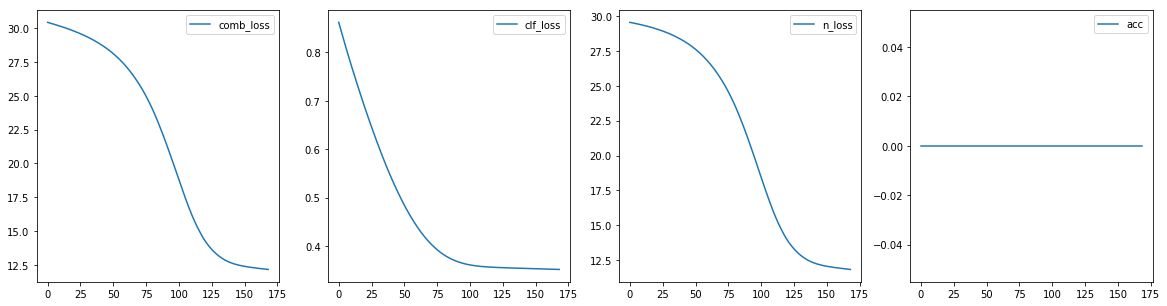

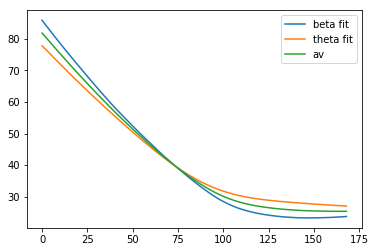

In [34]:
print("elements in h:", len(h))
for tup in h:
    print(tup)

comb_loss, clf_loss, n_loss, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=4)
axes[0].plot(comb_loss, label="comb_loss")
axes[1].plot(clf_loss, label="clf_loss")
axes[2].plot(n_loss, label="n_loss")
axes[3].plot(acc, label="acc")

fig.set_size_inches(20, 5)
for i in [0,1,2,3]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="beta fit")
plt.plot(th_fit_rmses, label="theta fit")
plt.plot(av_fit_rmses, label="av")
plt.legend()
plt.show()
# fig = plt.gcf()
# fig.set_size_inches(8, 5)
# plt.xlabel("#iterations")
# plt.ylabel("fit error (RMSE)")
# plt.suptitle("Neural-MLTM Parameter Fitting")
# plt.title("(skills=5, items=10, students=100)")
# plt.legend()
# plt.show()


In [21]:
real_wgtz = array([ q.betas for q in qs ])
pred_wgtz = q_table.get_weights()[0]
chosen, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

print("real", real_wgtz)
# print(pred_wgts)
print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

real [[ 0.08695135  0.          2.24661523 ...,  0.89267674  1.7183651
   1.47487956]
 [ 0.          0.26870938  0.         ...,  2.24385199  2.01939344
   2.72157438]
 [ 2.79958944  2.98936053  2.96329512 ...,  3.01115309  1.46526372
   2.83875447]
 ..., 
 [ 0.          0.54469546  0.         ...,  0.88753211  1.91090758  0.        ]
 [ 0.          0.          0.         ...,  0.          0.01117074  0.        ]
 [ 3.07476749  3.0751371   3.06539391 ...,  3.07246306  3.07421298
   3.06875504]]
out [[ 0.3210336   1.54131603  2.03127456 ...,  1.77324915  0.72571385
   1.50900757]
 [ 2.03975916  2.10105634  0.         ...,  2.15857887  0.84220344
   1.18963444]
 [ 2.02584124  2.31385565  3.07172894 ...,  3.04175353  2.17357039
   1.58278811]
 ..., 
 [ 0.48254472  1.93220174  1.31197977 ...,  1.1367619   1.15947413
   1.08853078]
 [ 0.05134754  0.60097605  0.42580113 ...,  1.42156458  0.08324129
   1.23604929]
 [ 3.0751965   3.0751965   3.0751965  ...,  3.0751965   3.0751965
   3.0751965 

In [ ]:
print(itemz.shape)

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


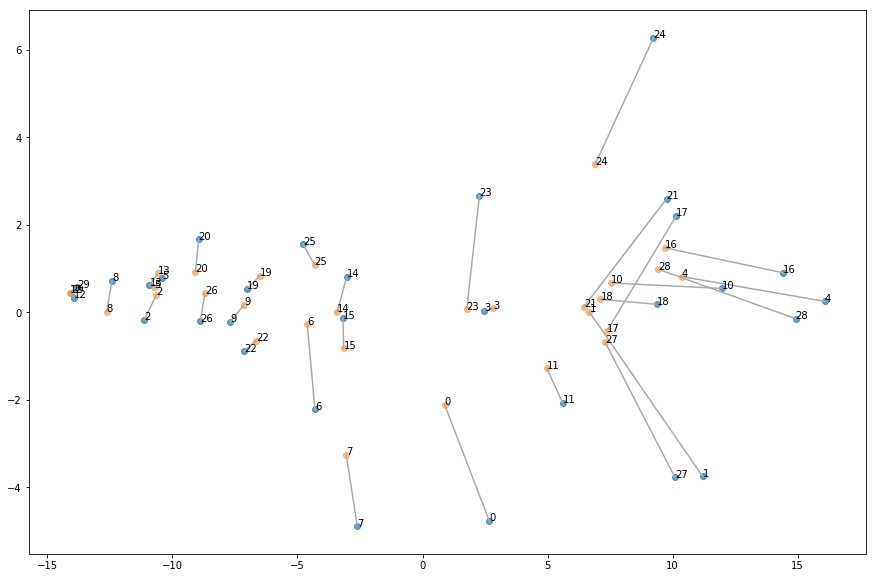

In [36]:
fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
# pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])

itemz_2 = itemz
itemz_2 = pca.fit_transform(itemz_2)
# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

itemz_pred = chosen
itemz_pred = pca.transform(itemz_pred)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(15, 10)

for x,xh,y,yh in zip(itemz_2[:,0],itemz_pred[:,0],itemz_2[:,1],itemz_pred[:,1]):
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")

fig.gca().scatter(itemz_2[:,0], itemz_2[:,1], alpha=0.7)
fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

for i, txt in enumerate(itemz_2):
    fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

for i, txt in enumerate(itemz_pred):
    fig.gca().annotate(i, (itemz_pred[i,0], itemz_pred[i,1]))
    
fig.show()

In [ ]:
psi_wgts = s_table.get_weights()[0]
print(psi_wgts)
for psi in ss:
    print(psi.id, psi.thetas, psi_wgts[psi.id])
print("qs ====")
qn_wgts = q_table.get_weights()[0]
print(qn_wgts)
for qn in qs:
    print(qn.id, qn.betas, qn_wgts[qn.id])

In [ ]:
n_traits = 5
nn_dimensions = [1,3,5,7,9]
serieses = []
min_errs = []
n_qs = 10
n_students = 250
for ix,nnw in enumerate(nn_dimensions):
    qs = create_qs(n_qs, n_traits, nnw, optimiser=qopt)
    ss = create_students(n_students, n_traits, nnw, optimiser=qopt)
    attempts_by_psi, attempts_by_q = generate_attempts(qs,ss)
    print(qs[0].pred_betas.get_weights()[0][0])
    print(ss[0].pred_theta.get_weights()[0][0])
    resultz = calibrate(qs,ss,attempts_by_q, attempts_by_psi, n_iter=70)
    serieses.append( resultz )
#     if ix < len(serieses): #append to old series
#         (_mses,_accs) = serieses[ix]
#         _mses += mses
#         _accs += accs
#         serieuses[ix] = (_mses,_accs)
#     else: #create new series
#         serieses.append((mses,accs))
    
from pygame import mixer
mixer.init()
mixer.music.load('calibration_complete.mp3')
mixer.music.play()

In [ ]:
# import pickle
# pickle.dump( serieses, open( "serieses.p", "wb" ) )

xmax=10
xs = range(len(serieses[0][0]))[0:xmax]
print(len(serieses))
for s in serieses:
    print(len(s))
# plt.plot(xs, numpy.multiply(1,theta_rmses), 'b--')
# plt.plot(xs, numpy.multiply(1,beta_rmses), 'b')
fig, axes = plt.subplots(nrows=3, ncols=2)
print(axes.shape)
for (mses,accs, th_mses,th_accs, b_mses,b_accs),c,d in zip(serieses,["r--","y--","k-","c--","b--"],nn_dimensions):
    axes[0,0].plot(xs, numpy.multiply(1,mses[0:xmax]), c, label="nnw={}".format(d))
    axes[0,1].plot(xs, numpy.multiply(1,accs[0:xmax]), c, label="nnw={}".format(d))
    axes[1,0].plot(xs, numpy.multiply(1,th_mses[0:xmax]), c, label="nnw={}".format(d))
    axes[1,1].plot(xs, numpy.multiply(1,th_accs[0:xmax]), c, label="nnw={}".format(d))
    axes[2,0].plot(xs, numpy.multiply(1,b_mses[0:xmax]), c, label="nnw={}".format(d))
    axes[2,1].plot(xs, numpy.multiply(1,b_accs[0:xmax]), c, label="nnw={}".format(d))

# plt.plot(xs, accs, "m")
# plt.plot(xs, numpy.multiply(1,s_outer_accs), "g")7
# plt.plot(xs, numpy.multiply(1,q_outer_accs), "k")

# plt.plot(xs, numpy.multiply(1,mses), "m--")
# plt.plot(xs, numpy.multiply(1,s_outer_mses), "g--")
# plt.plot(xs, numpy.multiply(1,q_outer_mses), "k--")
for ix in range(axes.shape[0]):
    subcats = ["Combined","Student","Question"]
    for iy in range(axes.shape[1]):
        axes[ix,iy].set_xlabel("#iterations")
        axes[ix,iy].legend()
        if iy==0:
            axes[ix,iy].set_title("{} fit error".format(subcats[ix]))
            axes[ix,iy].set_ylabel("fit error (RMSE)")
        else:
            axes[ix,iy].set_title("{} fit accuracy".format(subcats[ix]))
            axes[ix,iy].set_ylabel("prediction accuracy")

fig.suptitle("Neural-MLTM Parameter Fitting (k={}, q={}, s={})".format(n_traits, n_qs, n_students))
fig.set_size_inches(18, 18)

fig.show()

In [ ]:
xs = range(len(serieses[0][0]))
print(len(serieses))
for s in serieses:
    print(len(s))
# plt.plot(xs, numpy.multiply(1,theta_rmses), 'b--')
# plt.plot(xs, numpy.multiply(1,beta_rmses), 'b')
fig, axes = plt.subplots(nrows=1, ncols=2)
print(axes.shape)

min_mses = []
max_accs = []
bmin_mses = []
bmax_accs = []

for (mses,accs, th_mses,th_accs, b_mses,b_accs),c,d in zip(serieses,["r--","y--","k-","c--","b--"],nn_dimensions):
    mm = min(th_mses)
    ma = max(th_accs)
    min_mses.append(mm)
    max_accs.append(ma)
    mm = min(b_mses)
    ma = max(b_accs)
    bmin_mses.append(mm)
    bmax_accs.append(ma)
    

axes[0].plot(nn_dimensions, numpy.multiply(1,min_mses))
axes[0].plot(nn_dimensions, numpy.multiply(1,bmin_mses))
axes[1].plot(nn_dimensions, numpy.multiply(1,max_accs))
axes[1].plot(nn_dimensions, numpy.multiply(1,bmax_accs))
axes[0].axvline(x=5, linestyle="--")
axes[1].axvline(x=5, linestyle="--")

fig.suptitle("Neural-MLTM Parameter Fitting (k={}, q={}, s={})".format(n_traits, n_qs, n_students))
fig.set_size_inches(18,4)

fig.show()